## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
from qibo import matrices, optimizers
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [2]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [72]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            return np.diff([schedule(step/r, p) for step in range(1, r+1)])
        
        con1 = {'type': 'ineq', 'fun': derivative}
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters, 
                        method, options=options, constraints=con1)
        if m.success == False or m.fun < 0:
            return np.nan, m.x
        return m.fun, m.x        
        
    def compute_query(self, params, schedule, r, b):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = self.Psuc(beta[k+1])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = self.Psuc(beta[r-1])        
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Z = np.sum(np.exp(-beta * self.E))
        Zt =  Z * np.exp(beta * self.Emin)
        N = 2**self.n        
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example


Reference value: 55.14033784355961
Optimized value: 54.34097674815433
Best params: [-1.07142847]
Cross-check: 54.34097674815433

Reference value: 55.14033784355961
Optimized value: 51.17589533535576
Best params: [-5.38043234  2.44565084]
Cross-check: 51.17589533535576



<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 55.14033784355961
Optimized value: 47.05174305297194
Best params: [-14.84095793  15.31807799  -5.65011056]
Cross-check: 47.05174305297194



<ipython-input-4-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 55.14033784355961
Optimized value: 43.496917338670116
Best params: [-32.1653551   55.56680409 -45.57110585  14.28545002]
Cross-check: 43.496917338670116


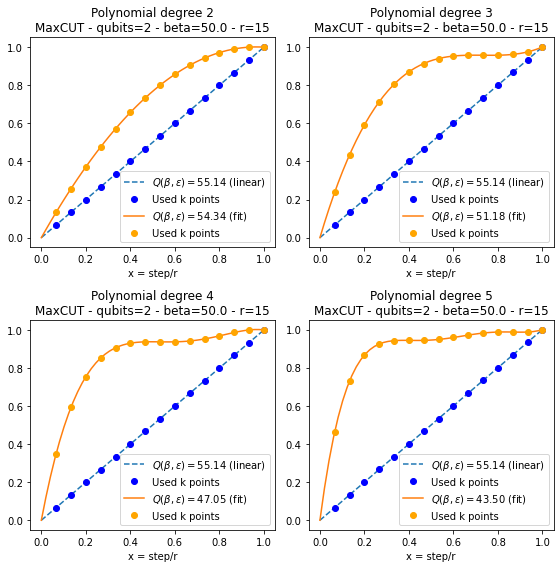

In [7]:
# setup
nqubits = 2
r = 15
beta = 50

model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f
    

plt.figure(figsize=(8,8))
for d in range(4):
    print()
    plt.subplot(2,2,d+1)
    plt.tight_layout()
    initial_guess = np.zeros(d+1)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))

    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();

## Example 2

<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 39.22904632154152
Optimized value: 30.66116919041711
Best params: [-9.97295968  4.00794168  5.96606137 -4.33883888]
Cross-check: 30.66116919041711
Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565
Reference value: 71.13731330403408
Optimized value: 44.486368549883565
Best params: [-32.45074555  55.42963534 -44.58139951  13.61992473]
Cross-check: 44.486368549883565
Reference value: 39.22904632154152
Optimized value: 30.66116919041711
Best params: [-9.97295968  4.00794168  5.96606137 -4.33883888]
Cross-check: 30.66116919041711


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 412.976585726458
Optimized value: 401.39380159261947
Best params: [-2.39898421  1.23831164  0.84188499 -0.62742249]
Cross-check: 401.39380159261947


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 744.9603470285257
Optimized value: 720.5822766821117
Best params: [-2.0391489   0.81018994  1.4189532  -1.03623585]
Cross-check: 720.5822766821117


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 144.5080878751085
Optimized value: 119.59622625586101
Best params: [-5.2470345   0.96533792  2.47509243 -1.27845721]
Cross-check: 119.59622625586101


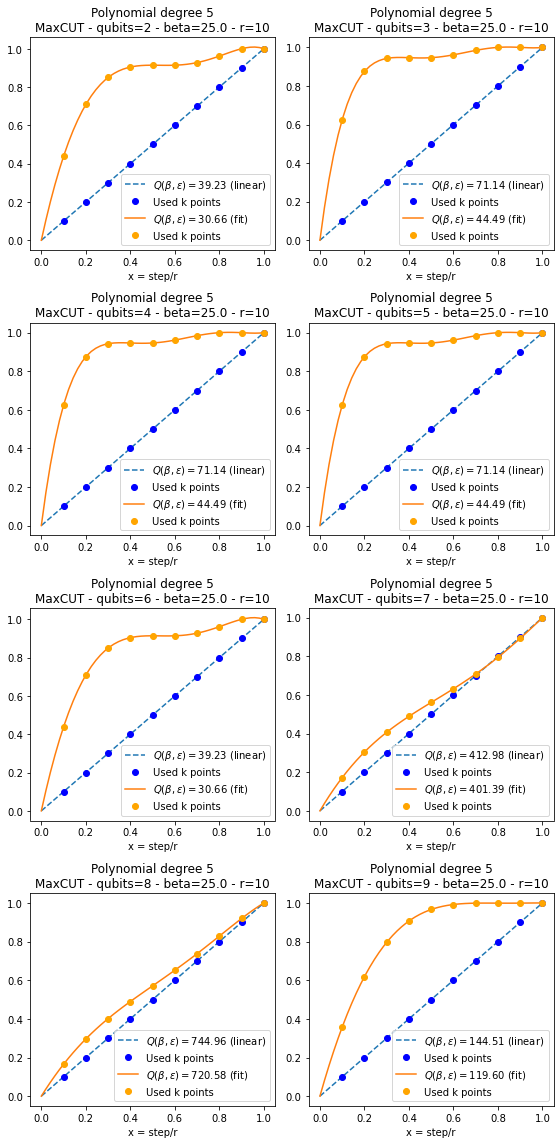

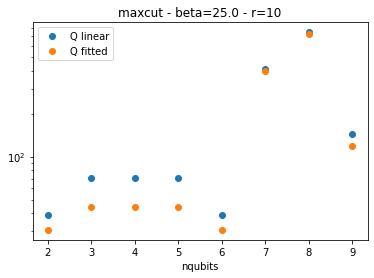

In [41]:
# setup
r = 10
beta = 25

qref = []
qopt = []

plt.figure(figsize=(8,16))
for nqubits in range(2, 10):
    plt.subplot(4,2,nqubits-1)
    plt.tight_layout()    
    
    model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

    def myschedule(t, params):
        f = sum(p * t ** (i + 2) for i, p in enumerate(params))
        f += (1 - np.sum(params)) * t
        return f

    initial_guess = np.zeros(4)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))
    qref.append(reference)
    qopt.append(result)
    
    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();
plt.savefig('maxcut_beta%d_r%d_pol%d.png' % (beta, r, len(initial_guess)+1))

plt.figure()
plt.title('maxcut - beta=%.1f - r=%d' % (beta, r))
plt.plot(range(2,10), qref, 'o', label='Q linear')
plt.plot(range(2,10), qopt, 'o', label='Q fitted')
plt.yscale('log')
plt.legend();
plt.xlabel('nqubits')
plt.savefig('all_maxcut_beta%d_r%d_pol%d.png' % (beta, r, len(initial_guess)+1))

## Example 3

Reference value: 5.193893674612351
Optimized value: 5.193893674612351
Best params: [0.1 0.  0.  0. ]
Cross-check: 5.193893674612351
Reference value: 6.19705532772187
Optimized value: 6.19705532772187
Best params: [0.1 0.  0.  0. ]
Cross-check: 6.19705532772187
Reference value: 11.425696597488782
Optimized value: 9.091727995482584
Best params: [-0.11367251 -0.32050877 -0.37392684 -0.40063593]
Cross-check: 9.091727995482584
Reference value: 14.96950434946173
Optimized value: 13.12269509095543
Best params: [-0.11367274 -0.32050876 -0.37392676 -0.40063589]
Cross-check: 13.12269509095543
Reference value: 20.57295205246205
Optimized value: 19.16830167025402
Best params: [-0.11367244 -0.32050878 -0.37392683 -0.40063597]
Cross-check: 19.16830167025402


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 13.204433220700135
Optimized value: 10.929497983867495
Best params: [-3.69952912 -2.22097183  0.20198834  2.2741182 ]
Cross-check: 10.929497983867495


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 22.9948513596238
Optimized value: 17.626905118923506
Best params: [-2.08827723 -1.33307303  0.00842584  1.15986921]
Cross-check: 17.626905118923506
Reference value: 25.178779037674303
Optimized value: 22.355537088501567
Best params: [-3.69955168 -2.22093074  0.20196093  2.27412318]
Cross-check: 22.355537088501567


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: divide by zero encountered in true_divide
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: divide by zero encountered in true_divide
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 33.2259107650509
Optimized value: 27.273695316895903
Best params: [-2.21372911 -1.31531159  0.02813772  1.13997626]
Cross-check: 27.273695316895903
Reference value: 19.675351626391393
Optimized value: 17.143434263164934
Best params: [-2.11865769 -1.38059908 -0.03451741  1.19997961]
Cross-check: 17.143434263164934


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 60.78986728037438
Optimized value: 48.58474655481744
Best params: [-2.22772408 -1.3057083   0.03737425  1.13113684]
Cross-check: 48.58474655481744


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 29.26743933783735
Optimized value: 25.117306000316233
Best params: [-1.28969736 -0.85522761 -0.07765144  0.59911132]
Cross-check: 25.117306000316233


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 30.17213492800561
Optimized value: 27.882474002973062
Best params: [-0.74802568 -0.58733507 -0.13420792  0.29901632]
Cross-check: 27.882474002973062


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 75.54463532732419
Optimized value: 73.69413618644278
Best params: [-2.67476607  0.11445566  0.87875393 -0.31348702]
Cross-check: 73.69413618644278


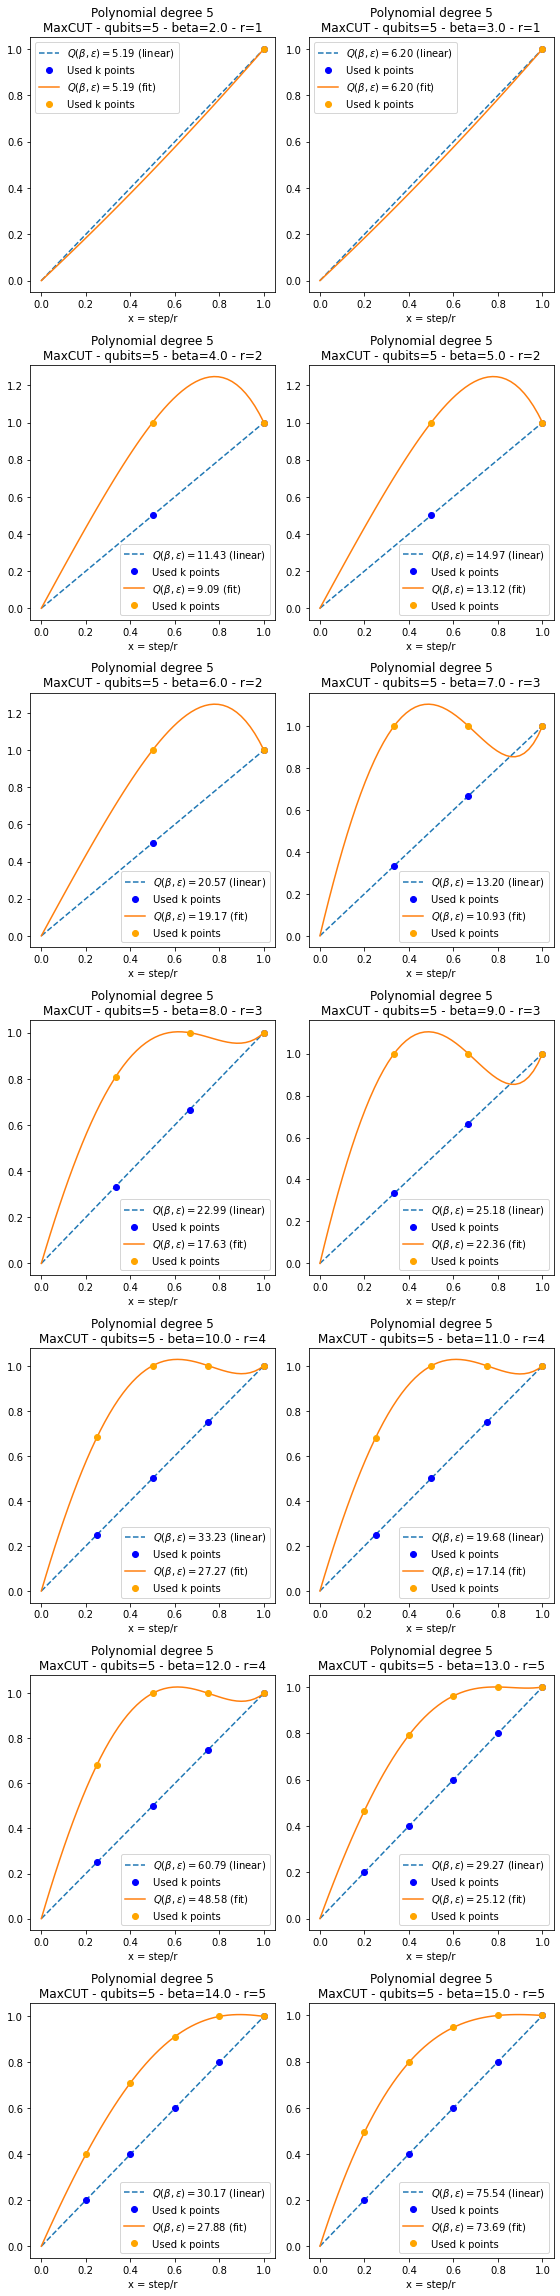

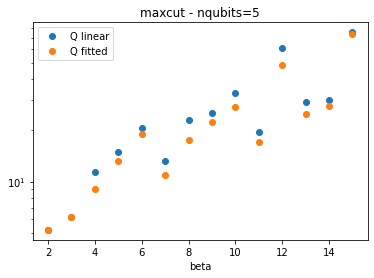

In [58]:
# setup
nqubits = 5

qref = []
qopt = []

plt.figure(figsize=(8,32))
for beta in range(2, 16):    
    plt.subplot(7,2,beta-1)
    plt.tight_layout()    
    r = np.int64(np.ceil(beta/3))
    model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

    def myschedule(t, params):
        f = sum(p * t ** (i + 2) for i, p in enumerate(params))
        f += (1 - np.sum(params)) * t
        return f

    initial_guess = np.zeros(4)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)
    print('Cross-check:', model.compute_query(params, myschedule))
    qref.append(reference)
    qopt.append(result)
    
    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();
plt.savefig('p2_maxcut_nqubits%d_pol%d.png' % (nqubits, len(initial_guess)+1))


plt.figure()
plt.title('maxcut - nqubits=%d' % nqubits)
plt.plot(range(2, 16), qref, 'o', label='Q linear')
plt.plot(range(2, 16), qopt, 'o', label='Q fitted')
plt.yscale('log')
plt.legend();
plt.xlabel('beta')
plt.savefig('p2_all_maxcut_nqubits%d_pol%d.png' % (nqubits, len(initial_guess)+1))

## Example 4 - Average vs qubits

In [4]:
ntrials = 10

# setup
r = 10
beta = 14
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

for nqubits in range(2, 10):
    print('nqubits', nqubits)
    qref.append(np.zeros(ntrials))
    qopt.append(np.zeros(ntrials))
    qampl.append(np.zeros(ntrials))
    qc.append(np.zeros(ntrials))    
    parameters.append(np.zeros(shape=(ntrials,npol-1)))
    for nt in range(ntrials):
        model = FragmentedQuITE(nqubits, maxcut(nqubits, norm=40.0, random_graph=True), Qu)
        reference = model.reference_query(r, beta)
        a_ref, qampl_reference = model.reference_query_no_fragmentation(beta)
        
        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0.1
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        r=r, b=beta,
                                        method='COBYLA', options={'maxiter':50000})
        qref[nqubits-2][nt] = reference        
        qopt[nqubits-2][nt] = result
        qampl[nqubits-2][nt] = qampl_reference
        parameters[nqubits-2][nt] = params
        qc[nqubits-2][nt] = a_ref

nqubits 2


<ipython-input-3-7a2820d156f4>:2: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


nqubits 3
nqubits 4
nqubits 5
nqubits 6
nqubits 7
nqubits 8
nqubits 9


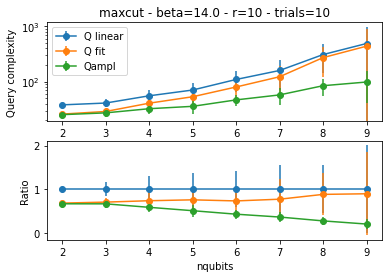

In [5]:
fig, axs = plt.subplots(2)
axs[0].set_title('maxcut - beta=%.1f - r=%d - trials=%d' % (beta, r, ntrials))
axs[0].errorbar(range(2,10), np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1), marker='o', label='Q linear')
axs[0].errorbar(range(2,10), np.nanmean(qopt, axis=1), 
             yerr=np.nanstd(qopt, axis=1), marker='o', label='Q fit')
axs[0].errorbar(range(2,10), np.nanmean(qampl, axis=1), 
             yerr=np.nanstd(qampl, axis=1), marker='o', label='Qampl')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')
axs[1].errorbar(range(2,10), np.mean(qref, axis=1)/np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qampl, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qampl, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].set_xlabel('nqubits')
axs[1].set_ylabel('Ratio');
plt.savefig('avg_maxcut_beta%d_r%d_pol5.png' % (beta, r), bbox_inches='tight')

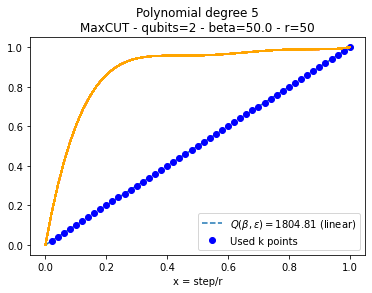

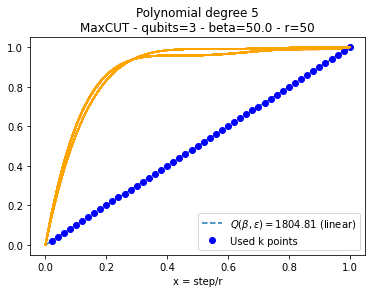

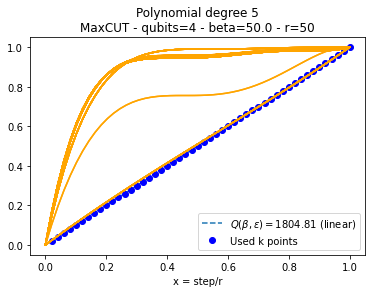

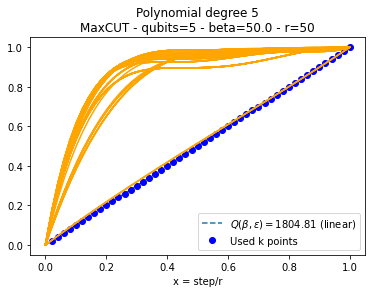

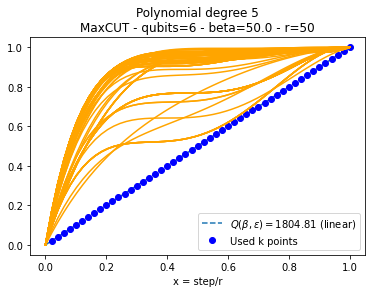

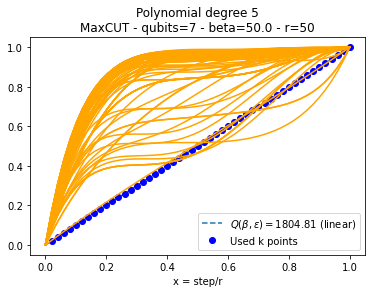

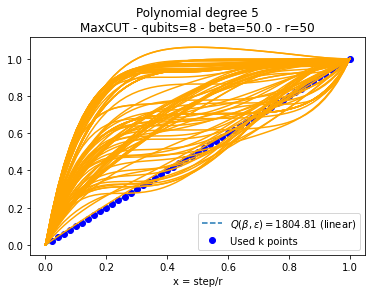

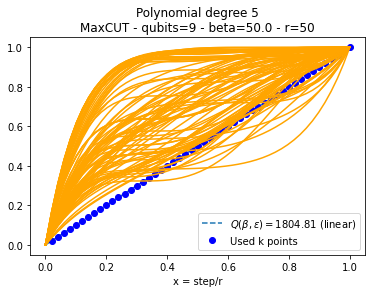

In [48]:
# plot
x = np.linspace(0,1,50)
xr = np.array(range(1,r+1))/r
for nqubits in range(2, 10):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    for j in range(parameters[nqubits-2].shape[0]):
        plt.plot(x, [myschedule(i, parameters[nqubits-2][j]) for i in x], color='orange');
        #plt.plot(xr,[myschedule(ixr, parameters[nqubits-2][j]) for ixr in xr], 'o', color='orange')
    plt.xlabel('x = step/r')
    plt.legend();

## Example 5 - Average vs beta

In [127]:
# setup
ntrials = 100
nqubits = 5
npol = 2

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

r_range = range(1, 15) 
beta_max = 150
beta_range = range(2, beta_max+1, 5)
qref = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol-1))


for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    
    for ii, beta in enumerate(beta_range):
        a_ref = model.Q(beta)
        ampl_ref = model.Qampl(beta)
        qampl[ii][nt] = ampl_ref
        qc[ii][nt] = a_ref
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f' beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        
        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        r=r_range[np.argmin(values)], b=beta,
                                        method='COBYLA', options={'maxiter': 50000})
        if result > np.min(values):
            result = np.nan
        qopt[ii][nt] = result
        parameters[ii][nt] = params

trial=0
 beta=2, r=1, reference=14.494788751029239
 beta=2, r=2, reference=16.049749549131505
 beta=2, r=3, reference=19.507107082684797
 beta=2, r=4, reference=23.55011898920929
 beta=2, r=5, reference=27.94631488210696
 beta=2, r=6, reference=32.63049678171551
 beta=2, r=7, reference=37.5790912911808
 beta=2, r=8, reference=42.78171753808437
 beta=2, r=9, reference=48.232853394924994
 beta=2, r=10, reference=53.92896522539041
 beta=2, r=11, reference=59.86740541634729
 beta=2, r=12, reference=66.04595515012785
 beta=2, r=13, reference=72.46262406505123
 beta=2, r=14, reference=79.11555889448724
 beta=7, r=1, reference=56.79215932754998
 beta=7, r=2, reference=49.21647937750664
 beta=7, r=3, reference=51.37657087322505
 beta=7, r=4, reference=56.14328328372217
 beta=7, r=5, reference=62.12577265513803
 beta=7, r=6, reference=68.86971594741755
 beta=7, r=7, reference=76.18581105004789
 beta=7, r=8, reference=83.98225276411814
 beta=7, r=9, reference=92.2092940911467
 beta=7, r=10, refe

<ipython-input-72-8965ddbc6a15>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-72-8965ddbc6a15>:53: RuntimeWarning: overflow encountered in exp
  Zt =  Z * np.exp(beta * self.Emin)
<ipython-input-72-8965ddbc6a15>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-72-8965ddbc6a15>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=17, r=1, reference=160.16322625704686
 beta=17, r=2, reference=119.15642546996743
 beta=17, r=3, reference=112.96323987211655
 beta=17, r=4, reference=115.0455791602319
 beta=17, r=5, reference=120.45827926105656
 beta=17, r=6, reference=127.65472020574951
 beta=17, r=7, reference=136.00598523707205
 beta=17, r=8, reference=145.21030906158887
 beta=17, r=9, reference=155.10524833775418
 beta=17, r=10, reference=165.59555499576584
 beta=17, r=11, reference=176.62150073410592
 beta=17, r=12, reference=188.1434987061653
 beta=17, r=13, reference=200.13403731537255
 beta=17, r=14, reference=212.57318255717735
 beta=22, r=1, reference=222.3194009902877
 beta=22, r=2, reference=158.2192353101139
 beta=22, r=3, reference=145.8299970188807
 beta=22, r=4, reference=145.64509966061547
 beta=22, r=5, reference=150.23335845797953
 beta=22, r=6, reference=157.26775811885477
 beta=22, r=7, reference=165.8101199680353
 beta=22, r=8, reference=175.41639128417535
 beta=22, r=9, reference=185.8510

 beta=87, r=1, reference=1497.8567804037111
 beta=87, r=2, reference=878.8496725229154
 beta=87, r=3, reference=695.6669844462359
 beta=87, r=4, reference=619.2415817982122
 beta=87, r=5, reference=584.5775996050173
 beta=87, r=6, reference=570.3340047542633
 beta=87, r=7, reference=567.5201704886065
 beta=87, r=8, reference=571.7289237293751
 beta=87, r=9, reference=580.5676290064927
 beta=87, r=10, reference=592.6386834056519
 beta=87, r=11, reference=607.079721948094
 beta=87, r=12, reference=623.3355407788191
 beta=87, r=13, reference=641.036331338691
 beta=87, r=14, reference=659.9287775411747
 beta=92, r=1, reference=1617.0322322047246
 beta=92, r=2, reference=943.7413275875664
 beta=92, r=3, reference=743.0827841149651
 beta=92, r=4, reference=658.3879610470266
 beta=92, r=5, reference=619.1207527858529
 beta=92, r=6, reference=602.0921674300199
 beta=92, r=7, reference=597.5189535768222
 beta=92, r=8, reference=600.5977315880468
 beta=92, r=9, reference=608.7161870239387
 beta=

 beta=7, r=12, reference=104.87029526661937
 beta=7, r=13, reference=112.79035824636786
 beta=7, r=14, reference=121.03642337089585
 beta=12, r=1, reference=93.53748510850941
 beta=12, r=2, reference=75.47683505604829
 beta=12, r=3, reference=73.21988210657723
 beta=12, r=4, reference=74.93164949069022
 beta=12, r=5, reference=78.36164210416644
 beta=12, r=6, reference=82.78613832327775
 beta=12, r=7, reference=87.89966415064998
 beta=12, r=8, reference=93.54929549547126
 beta=12, r=9, reference=99.6488822150514
 beta=12, r=10, reference=106.14544980055602
 beta=12, r=11, reference=113.00412142638675
 beta=12, r=12, reference=120.20063298521815
 beta=12, r=13, reference=127.71731540111556
 beta=12, r=14, reference=135.54079862938104
 beta=17, r=1, reference=121.93603186258686
 beta=17, r=2, reference=95.00285365999727
 beta=17, r=3, reference=90.52693633086783
 beta=17, r=4, reference=91.49794043819824
 beta=17, r=5, reference=94.66638004755927
 beta=17, r=6, reference=99.0114081305029

<ipython-input-72-8965ddbc6a15>:53: RuntimeWarning: overflow encountered in double_scalars
  Zt =  Z * np.exp(beta * self.Emin)


 beta=32, r=1, reference=205.03961398299023
 beta=32, r=2, reference=149.68500986429908
 beta=32, r=3, reference=137.3701126027131
 beta=32, r=4, reference=135.55514181215702
 beta=32, r=5, reference=137.81703137230951
 beta=32, r=6, reference=142.07841772284354
 beta=32, r=7, reference=147.4909815105395
 beta=32, r=8, reference=153.65634058990318
 beta=32, r=9, reference=160.36839787922503
 beta=32, r=10, reference=167.5123540050645
 beta=32, r=11, reference=175.02030371077313
 beta=32, r=12, reference=182.84998265877803
 beta=32, r=13, reference=190.97389065682816
 beta=32, r=14, reference=199.37340949922833
 beta=37, r=1, reference=232.48352126241474
 beta=37, r=2, reference=167.35458026538043
 beta=37, r=3, reference=152.15975245132734
 beta=37, r=4, reference=149.2118109918605
 beta=37, r=5, reference=151.03258442919156
 beta=37, r=6, reference=155.18242005962955
 beta=37, r=7, reference=160.65486862269063
 beta=37, r=8, reference=166.97310977347803
 beta=37, r=9, reference=173.88

 beta=102, r=1, reference=586.9988132286899
 beta=102, r=2, reference=391.40644321960053
 beta=102, r=3, reference=334.89168079141945
 beta=102, r=4, reference=313.3443058842589
 beta=102, r=5, reference=305.8640442779365
 beta=102, r=6, reference=305.44230737864086
 beta=102, r=7, reference=309.05577213875563
 beta=102, r=8, reference=315.18597756315694
 beta=102, r=9, reference=322.98946057204563
 beta=102, r=10, reference=331.96362147541043
 beta=102, r=11, reference=341.79340773507596
 beta=102, r=12, reference=352.2737753097222
 beta=102, r=13, reference=363.2674312696615
 beta=102, r=14, reference=374.68041688034486
 beta=107, r=1, reference=614.2136577111254
 beta=107, r=2, reference=408.49121647838626
 beta=107, r=3, reference=348.6757562093311
 beta=107, r=4, reference=325.55982061620546
 beta=107, r=5, reference=317.2212432885381
 beta=107, r=6, reference=316.3077897376661
 beta=107, r=7, reference=319.64603991217626
 beta=107, r=8, reference=325.64018501120404
 beta=107, r=9

 beta=22, r=1, reference=301.9894564494676
 beta=22, r=2, reference=207.27111226120118
 beta=22, r=3, reference=181.19241780380608
 beta=22, r=4, reference=171.91423483498252
 beta=22, r=5, reference=169.32039893582393
 beta=22, r=6, reference=170.1523209073748
 beta=22, r=7, reference=173.0611380158405
 beta=22, r=8, reference=177.39114339613198
 beta=22, r=9, reference=182.78428446011043
 beta=22, r=10, reference=189.02677614707383
 beta=22, r=11, reference=195.98165582441442
 beta=22, r=12, reference=203.55610091815785
 beta=22, r=13, reference=211.6842846284828
 beta=22, r=14, reference=220.3177644963921
 beta=27, r=1, reference=357.39735275660536
 beta=27, r=2, reference=240.11994393020592
 beta=27, r=3, reference=207.31868043459673
 beta=27, r=4, reference=195.15645619164906
 beta=27, r=5, reference=191.10272020186028
 beta=27, r=6, reference=191.10774083247472
 beta=27, r=7, reference=193.49872708911374
 beta=27, r=8, reference=197.46924777539598
 beta=27, r=9, reference=202.585

 beta=92, r=1, reference=1067.7599090466172
 beta=92, r=2, reference=646.4674655628186
 beta=92, r=3, reference=516.8065340933697
 beta=92, r=4, reference=459.84413833219196
 beta=92, r=5, reference=431.7598177027443
 beta=92, r=6, reference=417.95114039877603
 beta=92, r=7, reference=412.1802694698666
 beta=92, r=8, reference=411.3527429263962
 beta=92, r=9, reference=413.77239381080926
 beta=92, r=10, reference=418.440915174132
 beta=92, r=11, reference=424.73846198423564
 beta=92, r=12, reference=432.263680532467
 beta=92, r=13, reference=440.7476536780095
 beta=92, r=14, reference=450.00494756588216
 beta=97, r=1, reference=1122.2097652716914
 beta=97, r=2, reference=677.2732442294989
 beta=97, r=3, reference=539.8791886267728
 beta=97, r=4, reference=479.1952155745411
 beta=97, r=5, reference=449.01298665609585
 beta=97, r=6, reference=433.9272653266357
 beta=97, r=7, reference=427.35116182945296
 beta=97, r=8, reference=426.012450460491
 beta=97, r=9, reference=428.1143247373591


 beta=12, r=1, reference=380.45867319956204
 beta=12, r=2, reference=263.62332142724847
 beta=12, r=3, reference=228.23487505628466
 beta=12, r=4, reference=214.39105288288872
 beta=12, r=5, reference=210.16667738707775
 beta=12, r=6, reference=211.46652668738082
 beta=12, r=7, reference=216.43269213907317
 beta=12, r=8, reference=224.07012972405985
 beta=12, r=9, reference=233.78631061405068
 beta=12, r=10, reference=245.2019044050858
 beta=12, r=11, reference=258.0608936908313
 beta=12, r=12, reference=272.183277848204
 beta=12, r=13, reference=287.4382375059479
 beta=12, r=14, reference=303.72801294889405
 beta=17, r=1, reference=496.37054835373215
 beta=17, r=2, reference=332.1420436262352
 beta=17, r=3, reference=282.03358396243476
 beta=17, r=4, reference=260.5696998406277
 beta=17, r=5, reference=251.06472986845105
 beta=17, r=6, reference=248.04395180409847
 beta=17, r=7, reference=249.15025064984374
 beta=17, r=8, reference=253.17500837865614
 beta=17, r=9, reference=259.41930

 beta=82, r=1, reference=1922.9037250540334
 beta=82, r=2, reference=1110.8601650206026
 beta=82, r=3, reference=854.7397175204261
 beta=82, r=4, reference=736.5950583869653
 beta=82, r=5, reference=672.9233687642078
 beta=82, r=6, reference=636.0025442971398
 beta=82, r=7, reference=614.0560337903983
 beta=82, r=8, reference=601.2802838681138
 beta=82, r=9, reference=594.5149687454467
 beta=82, r=10, reference=591.909916386135
 beta=82, r=11, reference=592.3199451636337
 beta=82, r=12, reference=595.0036797844814
 beta=82, r=13, reference=599.4627840396649
 beta=82, r=14, reference=605.3512856623132
 beta=87, r=1, reference=2031.8603088082987
 beta=87, r=2, reference=1169.1866934269183
 beta=87, r=3, reference=896.5092966239048
 beta=87, r=4, reference=770.3718410426179
 beta=87, r=5, reference=702.148487284144
 beta=87, r=6, reference=662.3949030626991
 beta=87, r=7, reference=638.5880159216287
 beta=87, r=8, reference=624.546979822676
 beta=87, r=9, reference=616.9005008635388
 beta

trial=4
 beta=2, r=1, reference=22.53438839314936
 beta=2, r=2, reference=22.084089168725693
 beta=2, r=3, reference=25.773427694025518
 beta=2, r=4, reference=30.690387629924803
 beta=2, r=5, reference=36.26009019816347
 beta=2, r=6, reference=42.30613613393647
 beta=2, r=7, reference=48.75938116012095
 beta=2, r=8, reference=55.58756175550101
 beta=2, r=9, reference=62.77330419824557
 beta=2, r=10, reference=70.30599592253034
 beta=2, r=11, reference=78.17839620340877
 beta=2, r=12, reference=86.38508686706345
 beta=2, r=13, reference=94.9217099232702
 beta=2, r=14, reference=103.78456850774477
 beta=7, r=1, reference=163.87953519848693
 beta=7, r=2, reference=122.75308141786249
 beta=7, r=3, reference=115.3611004919508
 beta=7, r=4, reference=117.86390320937177
 beta=7, r=5, reference=125.03092185710352
 beta=7, r=6, reference=134.96952385532813
 beta=7, r=7, reference=146.82082897600793
 beta=7, r=8, reference=160.13891554491275
 beta=7, r=9, reference=174.66948311104397
 beta=7, r

 beta=72, r=1, reference=1704.8978090769672
 beta=72, r=2, reference=993.9947767193528
 beta=72, r=3, reference=770.8576469137498
 beta=72, r=4, reference=668.6041598509632
 beta=72, r=5, reference=614.0333128221118
 beta=72, r=6, reference=582.9067447672646
 beta=72, r=7, reference=564.961024991573
 beta=72, r=8, reference=555.153947579402
 beta=72, r=9, reference=550.7459587168526
 beta=72, r=10, reference=550.1344334776123
 beta=72, r=11, reference=552.3262314283471
 beta=72, r=12, reference=556.676273743873
 beta=72, r=13, reference=562.7486245219493
 beta=72, r=14, reference=570.2384677984147
 beta=77, r=1, reference=1813.917756483675
 beta=77, r=2, reference=1052.4668055941825
 beta=77, r=3, reference=812.8636918113784
 beta=77, r=4, reference=702.6974795173957
 beta=77, r=5, reference=643.6293476719501
 beta=77, r=6, reference=609.6929902603857
 beta=77, r=7, reference=589.8783382449135
 beta=77, r=8, reference=578.7683581227184
 beta=77, r=9, reference=573.4159753914108
 beta=7

 beta=142, r=1, reference=3229.361639665518
 beta=142, r=2, reference=1808.3056482973088
 beta=142, r=3, reference=1351.7593986796028
 beta=142, r=4, reference=1135.8270858478597
 beta=142, r=5, reference=1015.6720331467941
 beta=142, r=6, reference=943.0133398394814
 beta=142, r=7, reference=897.1861718865553
 beta=142, r=8, reference=867.8964993362579
 beta=142, r=9, reference=849.4651104279699
 beta=142, r=10, reference=838.5205860888003
 beta=142, r=11, reference=832.9481288291508
 beta=142, r=12, reference=831.3627873644763
 beta=142, r=13, reference=832.8254089155971
 beta=142, r=14, reference=836.6803602467213
 beta=147, r=1, reference=3338.172627174818
 beta=147, r=2, reference=1866.2766857931258
 beta=147, r=3, reference=1392.9174881519962
 beta=147, r=4, reference=1168.7119753511208
 beta=147, r=5, reference=1043.7204197332735
 beta=147, r=6, reference=967.9548045414533
 beta=147, r=7, reference=920.0133715861742
 beta=147, r=8, reference=889.229717281042
 beta=147, r=9, refe

 beta=62, r=1, reference=1482.4392794064647
 beta=62, r=2, reference=874.3562743956484
 beta=62, r=3, reference=685.2098371518973
 beta=62, r=4, reference=600.0434449113984
 beta=62, r=5, reference=555.9144198032164
 beta=62, r=6, reference=531.9794040172637
 beta=62, r=7, reference=519.4324567798888
 beta=62, r=8, reference=513.9585790461318
 beta=62, r=9, reference=513.2158209111484
 beta=62, r=10, reference=515.8324028687535
 beta=62, r=11, reference=520.9552461962123
 beta=62, r=12, reference=528.0274338167313
 beta=62, r=13, reference=536.6704585806391
 beta=62, r=14, reference=546.618215561986
 beta=67, r=1, reference=1592.9640935323528
 beta=67, r=2, reference=933.8356266666739
 beta=67, r=3, reference=728.0228980617571
 beta=67, r=4, reference=634.8049682463992
 beta=67, r=5, reference=586.0701602024559
 beta=67, r=6, reference=559.2274804196636
 beta=67, r=7, reference=544.7133296219325
 beta=67, r=8, reference=537.8341898503102
 beta=67, r=9, reference=536.0409399736972
 beta

 beta=132, r=1, reference=3011.710238585683
 beta=132, r=2, reference=1692.3129357204436
 beta=132, r=3, reference=1269.3767890301306
 beta=132, r=4, reference=1070.0483294592957
 beta=132, r=5, reference=959.7605757344128
 beta=132, r=6, reference=893.6666543219362
 beta=132, r=7, reference=852.5648551858704
 beta=132, r=8, reference=826.8843486945734
 beta=132, r=9, reference=811.3430026553278
 beta=132, r=10, reference=802.8054080460007
 beta=132, r=11, reference=799.3057998741073
 beta=132, r=12, reference=799.557743391901
 beta=132, r=13, reference=802.6894688113266
 beta=132, r=14, reference=808.092605819948
 beta=137, r=1, reference=3120.537359400067
 beta=137, r=2, reference=1750.3162890252363
 beta=137, r=3, reference=1310.5858131273405
 beta=137, r=4, reference=1102.99372834924
 beta=137, r=5, reference=987.8662034025489
 beta=137, r=6, reference=918.6521436146926
 beta=137, r=7, reference=875.4166605222035
 beta=137, r=8, reference=848.2190185067968
 beta=137, r=9, reference

 beta=52, r=1, reference=1268.3136387617042
 beta=52, r=2, reference=758.938190031246
 beta=52, r=3, reference=600.9428988599791
 beta=52, r=4, reference=529.5721485009401
 beta=52, r=5, reference=492.16060830817463
 beta=52, r=6, reference=471.37984070550283
 beta=52, r=7, reference=459.9598156478493
 beta=52, r=8, reference=454.3643361128729
 beta=52, r=9, reference=452.6877364710646
 beta=52, r=10, reference=453.8202235447779
 beta=52, r=11, reference=457.07400290693266
 beta=52, r=12, reference=462.000212454695
 beta=52, r=13, reference=468.2928465113508
 beta=52, r=14, reference=475.7353887259253
 beta=57, r=1, reference=1377.5633646770893
 beta=57, r=2, reference=817.9330641120657
 beta=57, r=3, reference=643.7817368748412
 beta=57, r=4, reference=564.7980001915121
 beta=57, r=5, reference=523.1615890149092
 beta=57, r=6, reference=499.8049464007954
 beta=57, r=7, reference=486.7071292893828
 beta=57, r=8, reference=479.9584350050941
 beta=57, r=9, reference=477.4501588058668
 be

 beta=122, r=1, reference=2794.0542419821963
 beta=122, r=2, reference=1576.2622108057017
 beta=122, r=3, reference=1186.844613434048
 beta=122, r=4, reference=1003.8622099682575
 beta=122, r=5, reference=902.896888406382
 beta=122, r=6, reference=842.497762683255
 beta=122, r=7, reference=804.9445286931176
 beta=122, r=8, reference=781.4272004765857
 beta=122, r=9, reference=767.0986793563226
 beta=122, r=10, reference=759.0914684118172
 beta=122, r=11, reference=755.6139840283887
 beta=122, r=12, reference=755.4978558490952
 beta=122, r=13, reference=757.9540738544106
 beta=122, r=14, reference=762.4339320768686
 beta=127, r=1, reference=2902.8920656371556
 beta=127, r=2, reference=1634.3004958428362
 beta=127, r=3, reference=1228.1216878547123
 beta=127, r=4, reference=1036.925799394924
 beta=127, r=5, reference=931.188231739962
 beta=127, r=6, reference=867.7482567862551
 beta=127, r=7, reference=828.1467461895863
 beta=127, r=8, reference=803.2000542415558
 beta=127, r=9, referenc

 beta=42, r=1, reference=1049.0578884851218
 beta=42, r=2, reference=639.972406751175
 beta=42, r=3, reference=514.1055883027082
 beta=42, r=4, reference=458.0440999165939
 beta=42, r=5, reference=429.45781198678475
 beta=42, r=6, reference=414.45205673684063
 beta=42, r=7, reference=407.204259172012
 beta=42, r=8, reference=404.87977113662623
 beta=42, r=9, reference=405.9456268294258
 beta=42, r=10, reference=409.50354804342703
 beta=42, r=11, reference=414.9920963104145
 beta=42, r=12, reference=422.041139626894
 beta=42, r=13, reference=430.3955121476914
 beta=42, r=14, reference=439.8725507375507
 beta=47, r=1, reference=1158.7812575363262
 beta=47, r=2, reference=699.6171885363385
 beta=47, r=3, reference=557.7672248877496
 beta=47, r=4, reference=494.17905584709223
 beta=47, r=5, reference=461.37230328406514
 beta=47, r=6, reference=443.73026672801916
 beta=47, r=7, reference=434.6947790454964
 beta=47, r=8, reference=431.0694514958755
 beta=47, r=9, reference=431.1268659771766


 beta=112, r=1, reference=2576.350949716457
 beta=112, r=2, reference=1460.1171060663519
 beta=112, r=3, reference=1104.1706902692317
 beta=112, r=4, reference=937.558766287816
 beta=112, r=5, reference=846.0859824248429
 beta=112, r=6, reference=791.7353226781844
 beta=112, r=7, reference=758.2783020261652
 beta=112, r=8, reference=737.6629126116704
 beta=112, r=9, reference=725.4688535992077
 beta=112, r=10, reference=719.0863864626203
 beta=112, r=11, reference=716.8874323343356
 beta=112, r=12, reference=717.8110759790563
 beta=112, r=13, reference=721.1408206613763
 beta=112, r=14, reference=726.3779181255421
 beta=117, r=1, reference=2685.2075850948277
 beta=117, r=2, reference=1518.2019926459745
 beta=117, r=3, reference=1145.5291527684392
 beta=117, r=4, reference=970.7424671590096
 beta=117, r=5, reference=874.5359423967988
 beta=117, r=6, reference=817.178585862941
 beta=117, r=7, reference=781.7002707242783
 beta=117, r=8, reference=759.6740640667546
 beta=117, r=9, referenc

 beta=32, r=1, reference=829.8571017845562
 beta=32, r=2, reference=519.8919557996431
 beta=32, r=3, reference=425.05514367250254
 beta=32, r=4, reference=382.9766324713969
 beta=32, r=5, reference=361.65580261929836
 beta=32, r=6, reference=350.68947194003084
 beta=32, r=7, reference=345.74968698350665
 beta=32, r=8, reference=344.73115728899427
 beta=32, r=9, reference=346.487786571546
 beta=32, r=10, reference=350.3393363603781
 beta=32, r=11, reference=355.85346783352026
 beta=32, r=12, reference=362.73985930970906
 beta=32, r=13, reference=370.794660206391
 beta=32, r=14, reference=379.86941803564514
 beta=37, r=1, reference=939.7983465984452
 beta=37, r=2, reference=580.3180946011395
 beta=37, r=3, reference=469.97677407146176
 beta=37, r=4, reference=420.77632982447574
 beta=37, r=5, reference=395.5423699034273
 beta=37, r=6, reference=382.14793793599637
 beta=37, r=7, reference=375.54328390419295
 beta=37, r=8, reference=373.27948669928924
 beta=37, r=9, reference=374.032519715

 beta=102, r=1, reference=2358.6020816057867
 beta=102, r=2, reference=1343.8599069576303
 beta=102, r=3, reference=1021.3024016523108
 beta=102, r=4, reference=870.9671424240862
 beta=102, r=5, reference=788.8764312949236
 beta=102, r=6, reference=740.4309126679956
 beta=102, r=7, reference=710.8742756223272
 beta=102, r=8, reference=692.8962100471126
 beta=102, r=9, reference=682.4926145803452
 beta=102, r=10, reference=677.3061909948642
 beta=102, r=11, reference=675.8710386178543
 beta=102, r=12, reference=677.235051035865
 beta=102, r=13, reference=680.7572196302661
 beta=102, r=14, reference=685.992576827752
 beta=107, r=1, reference=2467.4829867545977
 beta=107, r=2, reference=1402.0043427670373
 beta=107, r=3, reference=1062.7638179403302
 beta=107, r=4, reference=904.3021331498184
 beta=107, r=5, reference=817.5289237104201
 beta=107, r=6, reference=766.1298723081993
 beta=107, r=7, reference=734.6062116598428
 beta=107, r=8, reference=715.2718213876352
 beta=107, r=9, referen

 beta=22, r=1, reference=608.4825468113852
 beta=22, r=2, reference=396.33652354166856
 beta=22, r=3, reference=331.68910887378087
 beta=22, r=4, reference=303.50698818303493
 beta=22, r=5, reference=290.06830431862267
 beta=22, r=6, reference=284.2911316171385
 beta=22, r=7, reference=283.1781256815986
 beta=22, r=8, reference=285.2316810796616
 beta=22, r=9, reference=289.61164863955014
 beta=22, r=10, reference=295.80490077305046
 beta=22, r=11, reference=303.4771687519344
 beta=22, r=12, reference=312.39947703186243
 beta=22, r=13, reference=322.40855408968287
 beta=22, r=14, reference=333.3840991917359
 beta=27, r=1, reference=719.5141919632125
 beta=27, r=2, reference=458.7030535209718
 beta=27, r=3, reference=379.1080071578158
 beta=27, r=4, reference=344.01752551801576
 beta=27, r=5, reference=326.60065636825624
 beta=27, r=6, reference=318.14604184730166
 beta=27, r=7, reference=315.00817187217825
 beta=27, r=8, reference=315.39213498913904
 beta=27, r=9, reference=318.3062066

 beta=92, r=1, reference=2140.793332289456
 beta=92, r=2, reference=1227.457065528579
 beta=92, r=3, reference=938.1848075762676
 beta=92, r=4, reference=804.015172490679
 beta=92, r=5, reference=731.2024167926058
 beta=92, r=6, reference=688.5820802161553
 beta=92, r=7, reference=662.8858874429446
 beta=92, r=8, reference=647.5567225017508
 beta=92, r=9, reference=639.0134257504699
 beta=92, r=10, reference=635.1540634119608
 beta=92, r=11, reference=634.6751906855495
 beta=92, r=12, reference=636.732109258385
 beta=92, r=13, reference=640.7569094734189
 beta=92, r=14, reference=646.355488672615
 beta=97, r=1, reference=2249.7063075483425
 beta=97, r=2, reference=1285.6792860558428
 beta=97, r=3, reference=979.7789957997882
 beta=97, r=4, reference=837.5421712555723
 beta=97, r=5, reference=760.1058893380025
 beta=97, r=6, reference=714.5873555010327
 beta=97, r=7, reference=686.9737186066385
 beta=97, r=8, reference=670.3309817627044
 beta=97, r=9, reference=660.8664513719858
 beta=9

 beta=7, r=5, reference=60.55613245800849
 beta=7, r=6, reference=65.50923780102887
 beta=7, r=7, reference=71.08562482940863
 beta=7, r=8, reference=77.17185120218802
 beta=7, r=9, reference=83.70159014438404
 beta=7, r=10, reference=90.63276889738945
 beta=7, r=11, reference=97.93695873020023
 beta=7, r=12, reference=105.59394449879414
 beta=7, r=13, reference=113.58872825656029
 beta=7, r=14, reference=121.90977480967693
 beta=12, r=1, reference=93.50493985085856
 beta=12, r=2, reference=75.45554054481437
 beta=12, r=3, reference=73.23652984875892
 beta=12, r=4, reference=75.02239978545965
 beta=12, r=5, reference=78.54756286759395
 beta=12, r=6, reference=83.0758116962832
 beta=12, r=7, reference=88.29532542651673
 beta=12, r=8, reference=94.05063088242325
 beta=12, r=9, reference=100.25486910951284
 beta=12, r=10, reference=106.85514439579349
 beta=12, r=11, reference=113.81694902291206
 beta=12, r=12, reference=121.11645890512432
 beta=12, r=13, reference=128.73642606976202
 beta

 beta=77, r=1, reference=450.8648060815584
 beta=77, r=2, reference=305.81324744660736
 beta=77, r=3, reference=265.6488992121937
 beta=77, r=4, reference=251.7586154080198
 beta=77, r=5, reference=248.36403595746242
 beta=77, r=6, reference=250.1863822770921
 beta=77, r=7, reference=254.96216719238686
 beta=77, r=8, reference=261.5663984875577
 beta=77, r=9, reference=269.3833755410938
 beta=77, r=10, reference=278.05296372418394
 beta=77, r=11, reference=287.3542053175807
 beta=77, r=12, reference=297.14663476755567
 beta=77, r=13, reference=307.33849785887014
 beta=77, r=14, reference=317.86856677745965
 beta=82, r=1, reference=478.1019137389193
 beta=82, r=2, reference=322.9607649584484
 beta=82, r=3, reference=279.55181099939176
 beta=82, r=4, reference=264.160422390566
 beta=82, r=5, reference=259.9816602575805
 beta=82, r=6, reference=261.38886783380985
 beta=82, r=7, reference=265.9651408801188
 beta=82, r=8, reference=272.5058243097202
 beta=82, r=9, reference=280.349100652657

 beta=147, r=9, reference=414.3026389699825
 beta=147, r=10, reference=423.16978169017113
 beta=147, r=11, reference=433.34108405848326
 beta=147, r=12, reference=444.4975483190591
 beta=147, r=13, reference=456.41978318451214
 beta=147, r=14, reference=468.953213579879
trial=11
 beta=2, r=1, reference=16.07061483160558
 beta=2, r=2, reference=17.23250975624563
 beta=2, r=3, reference=20.766292097705872
 beta=2, r=4, reference=25.008770508724677
 beta=2, r=5, reference=29.660881747955617
 beta=2, r=6, reference=34.63684349092968
 beta=2, r=7, reference=39.90489963793361
 beta=2, r=8, reference=45.45081953813976
 beta=2, r=9, reference=51.26702245307629
 beta=2, r=10, reference=57.3487520495907
 beta=2, r=11, reference=63.69256652306873
 beta=2, r=12, reference=70.29569003381857
 beta=2, r=13, reference=77.15571533578849
 beta=2, r=14, reference=84.270459986645
 beta=7, r=1, reference=80.16409416832926
 beta=7, r=2, reference=65.25698168034596
 beta=7, r=3, reference=66.04485369221372
 

 beta=67, r=1, reference=1585.5345455523532
 beta=67, r=2, reference=929.7162132652193
 beta=67, r=3, reference=725.9722089673958
 beta=67, r=4, reference=635.1828369068884
 beta=67, r=5, reference=589.3859842492327
 beta=67, r=6, reference=565.9363289740605
 beta=67, r=7, reference=555.1827394984678
 beta=67, r=8, reference=552.352321003321
 beta=67, r=9, reference=554.8346420557536
 beta=67, r=10, reference=561.0932994164194
 beta=67, r=11, reference=570.1715305469681
 beta=67, r=12, reference=581.4459503727711
 beta=67, r=13, reference=594.4948639227966
 beta=67, r=14, reference=609.0237642393706
 beta=72, r=1, reference=1697.7049813227832
 beta=72, r=2, reference=990.0288012419225
 beta=72, r=3, reference=769.1490299702808
 beta=72, r=4, reference=669.8770666014859
 beta=72, r=5, reference=619.0591863622444
 beta=72, r=6, reference=592.3108829360854
 beta=72, r=7, reference=579.2297694446039
 beta=72, r=8, reference=574.6648686847386
 beta=72, r=9, reference=575.7950554150766
 beta

 beta=137, r=1, reference=3120.490272472149
 beta=137, r=2, reference=1750.291354026055
 beta=137, r=3, reference=1310.6125819327062
 beta=137, r=4, reference=1103.2279943373326
 beta=137, r=5, reference=988.5484277686256
 beta=137, r=6, reference=920.0472659899038
 beta=137, r=7, reference=877.7875169538636
 beta=137, r=8, reference=851.8172212272754
 beta=137, r=9, reference=836.6308575153768
 beta=137, r=10, reference=828.9490012745948
 beta=137, r=11, reference=826.7060859037931
 beta=137, r=12, reference=828.5428353138689
 beta=137, r=13, reference=833.5324171269236
 beta=137, r=14, reference=841.0238872650259
 beta=142, r=1, reference=3229.324390052121
 beta=142, r=2, reference=1808.2859575490043
 beta=142, r=3, reference=1351.7901471035877
 beta=142, r=4, reference=1136.0983248859732
 beta=142, r=5, reference=1016.51399935583
 beta=142, r=6, reference=944.810507299963
 beta=142, r=7, reference=900.3214797835138
 beta=142, r=8, reference=872.7282901345426
 beta=142, r=9, referenc

 beta=57, r=1, reference=1377.5633651425155
 beta=57, r=2, reference=817.9330643735897
 beta=57, r=3, reference=643.781737856665
 beta=57, r=4, reference=564.7982512297843
 beta=57, r=5, reference=523.1645666286463
 beta=57, r=6, reference=499.81925960742103
 beta=57, r=7, reference=486.7501350052787
 beta=57, r=8, reference=480.05601866327504
 beta=57, r=9, reference=477.6348054024152
 beta=57, r=10, reference=478.2638243163973
 beta=57, r=11, reference=481.18701552100725
 beta=57, r=12, reference=485.91243727083844
 beta=57, r=13, reference=492.10585738029073
 beta=57, r=14, reference=499.53160670536926
 beta=62, r=1, reference=1486.734079926532
 beta=62, r=2, reference=876.7525503760254
 beta=62, r=3, reference=686.3477131947704
 beta=62, r=4, reference=599.664588555146
 beta=62, r=5, reference=553.7363210982014
 beta=62, r=6, reference=527.7625345411302
 beta=62, r=7, reference=512.9768037933814
 beta=62, r=8, reference=505.1004362363929
 beta=62, r=9, reference=501.8248886485455
 

 beta=127, r=1, reference=2902.8920656371556
 beta=127, r=2, reference=1634.3004958428362
 beta=127, r=3, reference=1228.1216878547102
 beta=127, r=4, reference=1036.925799392745
 beta=127, r=5, reference=931.1882316371677
 beta=127, r=6, reference=867.7482561621866
 beta=127, r=7, reference=828.1467505877679
 beta=127, r=8, reference=803.2001156347072
 beta=127, r=9, reference=787.8511163361452
 beta=127, r=10, reference=779.1049002225442
 beta=127, r=11, reference=775.0884976002383
 beta=127, r=12, reference=774.5795281106156
 beta=127, r=13, reference=776.7521486953858
 beta=127, r=14, reference=781.0320171489702
 beta=132, r=1, reference=3011.7220337327594
 beta=132, r=2, reference=1692.319193659632
 beta=132, r=3, reference=1269.3642982975273
 beta=132, r=4, reference=1069.9379480140876
 beta=132, r=5, reference=959.4101734860052
 beta=132, r=6, reference=892.911405347395
 beta=132, r=7, reference=851.2444794914352
 beta=132, r=8, reference=824.8526637866623
 beta=132, r=9, refere

 beta=47, r=1, reference=576.9605607841138
 beta=47, r=2, reference=367.3710280607196
 beta=47, r=3, reference=306.00993769585585
 beta=47, r=4, reference=281.17608975441476
 beta=47, r=5, reference=270.6458768529992
 beta=47, r=6, reference=267.10852042540796
 beta=47, r=7, reference=267.4997525620414
 beta=47, r=8, reference=270.33312015744366
 beta=47, r=9, reference=274.8123378823615
 beta=47, r=10, reference=280.47860799787236
 beta=47, r=11, reference=287.0521627765592
 beta=47, r=12, reference=294.3543184569755
 beta=47, r=13, reference=302.266370290615
 beta=47, r=14, reference=310.7066887194543
 beta=52, r=1, reference=631.6146661513318
 beta=52, r=2, reference=398.66893157562686
 beta=52, r=3, reference=329.90453010372073
 beta=52, r=4, reference=301.6838513496198
 beta=52, r=5, reference=289.36996659567944
 beta=52, r=6, reference=284.8356947174092
 beta=52, r=7, reference=284.6629094539138
 beta=52, r=8, reference=287.1877555794431
 beta=52, r=9, reference=291.516088621088


 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963905826
 beta=117, r=4, reference=556.1135212104886
 beta=117, r=5, reference=517.3668293069906
 beta=117, r=6, reference=497.00042102288
 beta=117, r=7, reference=487.03832388229085
 beta=117, r=8, reference=483.501732481754
 beta=117, r=9, reference=484.19355274597507
 beta=117, r=10, reference=487.80942744029704
 beta=117, r=11, reference=493.5320080142707
 beta=117, r=12, reference=500.82722361537833
 beta=117, r=13, reference=509.3341989009324
 beta=117, r=14, reference=518.8022451651088
 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370204
 beta=122, r=4, reference=575.2474101649672
 beta=122, r=5, reference=534.3240125104645
 beta=122, r=6, reference=512.6011361703024
 beta=122, r=7, reference=501.75707649939227
 beta=122, r=8, reference=497.6374476285466
 beta=122, r=9, referen

 beta=37, r=1, reference=939.7146938569904
 beta=37, r=2, reference=580.2691572446779
 beta=37, r=3, reference=469.9873906107937
 beta=37, r=4, reference=420.96692624269866
 beta=37, r=5, reference=396.0738052877447
 beta=37, r=6, reference=383.1806315731153
 beta=37, r=7, reference=377.22091567309593
 beta=37, r=8, reference=375.7251659610344
 beta=37, r=9, reference=377.34997157534417
 beta=37, r=10, reference=381.3004987585337
 beta=37, r=11, reference=387.07413130819015
 beta=37, r=12, reference=394.3355166093735
 beta=37, r=13, reference=402.8508963387578
 beta=37, r=14, reference=412.4513565918434
 beta=42, r=1, reference=1049.446813719708
 beta=42, r=2, reference=640.1971163344413
 beta=42, r=3, reference=514.1623244304897
 beta=42, r=4, reference=457.8017745667098
 beta=42, r=5, reference=428.81272875704866
 beta=42, r=6, reference=413.3461627591283
 beta=42, r=7, reference=405.6108095864821
 beta=42, r=8, reference=402.78865901073397
 beta=42, r=9, reference=403.35356659102047

 beta=107, r=1, reference=2467.4829867499425
 beta=107, r=2, reference=1402.0043427645385
 beta=107, r=3, reference=1062.7638188213948
 beta=107, r=4, reference=904.302197378537
 beta=107, r=5, reference=817.5297511282511
 beta=107, r=6, reference=766.1344029944751
 beta=107, r=7, reference=734.6215104058068
 beta=107, r=8, reference=715.310124652508
 beta=107, r=9, reference=703.9900778543777
 beta=107, r=10, reference=698.1807669837343
 beta=107, r=11, reference=696.338295841731
 beta=107, r=12, reference=697.4590246990144
 beta=107, r=13, reference=700.866666740628
 beta=107, r=14, reference=706.0913699746434
 beta=112, r=1, reference=2576.35095185803
 beta=112, r=2, reference=1460.117107212801
 beta=112, r=3, reference=1104.1706383586309
 beta=112, r=4, reference=937.5573979828077
 beta=112, r=5, reference=846.0766192576134
 beta=112, r=6, reference=791.7021179630193
 beta=112, r=7, reference=758.1969429179567
 beta=112, r=8, reference=737.504140095629
 beta=112, r=9, reference=725

 beta=27, r=1, reference=357.3198596952783
 beta=27, r=2, reference=240.07323453046547
 beta=27, r=3, reference=207.35067497518816
 beta=27, r=4, reference=195.40923060097325
 beta=27, r=5, reference=191.74604218518834
 beta=27, r=6, reference=192.30441941597113
 beta=27, r=7, reference=195.394023991115
 beta=27, r=8, reference=200.18897928829134
 beta=27, r=9, reference=206.23694609053965
 beta=27, r=10, reference=213.26772554502082
 beta=27, r=11, reference=221.10864287389307
 beta=27, r=12, reference=229.64330811759453
 beta=27, r=13, reference=238.78985504625112
 beta=27, r=14, reference=248.48867116751327
 beta=32, r=1, reference=412.4916384895051
 beta=32, r=2, reference=272.386124315878
 beta=32, r=3, reference=232.68694036631868
 beta=32, r=4, reference=217.63148655016195
 beta=32, r=5, reference=212.3009397460928
 beta=32, r=6, reference=211.8461599178192
 beta=32, r=7, reference=214.251183409639
 beta=32, r=8, reference=218.53813721465212
 beta=32, r=9, reference=224.17751904

 beta=97, r=1, reference=1122.2097652716166
 beta=97, r=2, reference=677.2732442294587
 beta=97, r=3, reference=539.8791887142193
 beta=97, r=4, reference=479.1952267298516
 beta=97, r=5, reference=449.01318782861927
 beta=97, r=6, reference=433.9286414853016
 beta=97, r=7, reference=427.3565974894758
 beta=97, r=8, reference=426.027724770744
 beta=97, r=9, reference=428.1485876244343
 beta=97, r=10, reference=432.6628514220169
 beta=97, r=11, reference=438.9141728724914
 beta=97, r=12, reference=446.4772578710535
 beta=97, r=13, reference=455.066938773001
 beta=97, r=14, reference=464.4864316613494
 beta=102, r=1, reference=1176.6516381259394
 beta=102, r=2, reference=708.0585493830029
 beta=102, r=3, reference=562.9153812267126
 beta=102, r=4, reference=498.4916815356687
 beta=102, r=5, reference=466.1926472366741
 beta=102, r=6, reference=449.81184604561935
 beta=102, r=7, reference=442.41547812428024
 beta=102, r=8, reference=440.55630052210444
 beta=102, r=9, reference=442.3399375

 beta=17, r=1, reference=431.9869135353745
 beta=17, r=2, reference=291.30424625288356
 beta=17, r=3, reference=252.7017189305977
 beta=17, r=4, reference=240.36984904161145
 beta=17, r=5, reference=239.10684315974183
 beta=17, r=6, reference=243.84191789157444
 beta=17, r=7, reference=252.38330434456017
 beta=17, r=8, reference=263.6166371318384
 beta=17, r=9, reference=276.9092550684317
 beta=17, r=10, reference=291.87242316676156
 beta=17, r=11, reference=308.2526587255564
 beta=17, r=12, reference=325.87677408517453
 beta=17, r=13, reference=344.6218466329356
 beta=17, r=14, reference=364.397785140804
 beta=22, r=1, reference=573.4183364016972
 beta=22, r=2, reference=374.6852766179088
 beta=22, r=3, reference=317.1724198741759
 beta=22, r=4, reference=295.4197302694598
 beta=22, r=5, reference=288.3696956685791
 beta=22, r=6, reference=289.0534715799965
 beta=22, r=7, reference=294.50081145315426
 beta=22, r=8, reference=303.22432820420113
 beta=22, r=9, reference=314.390042635754

 beta=87, r=1, reference=2031.8556669768886
 beta=87, r=2, reference=1169.1841686992298
 beta=87, r=3, reference=896.5163813591283
 beta=87, r=4, reference=770.4428415347875
 beta=87, r=5, reference=702.4093884155727
 beta=87, r=6, reference=663.0308565316552
 beta=87, r=7, reference=639.8186887847445
 beta=87, r=8, reference=626.6063393996747
 beta=87, r=9, reference=620.0236697556011
 beta=87, r=10, reference=618.0874874188999
 beta=87, r=11, reference=619.5623042800042
 beta=87, r=12, reference=623.6422693994343
 beta=87, r=13, reference=629.7812826593726
 beta=87, r=14, reference=637.5970115843907
 beta=92, r=1, reference=2140.7910269017275
 beta=92, r=2, reference=1227.4558162954852
 beta=92, r=3, reference=938.1895211087001
 beta=92, r=4, reference=804.0652762474282
 beta=92, r=5, reference=731.3978012837349
 beta=92, r=6, reference=689.078263092565
 beta=92, r=7, reference=663.874469117455
 beta=92, r=8, reference=649.246796291017
 beta=92, r=9, reference=641.6182357292283
 beta

 beta=12, r=1, reference=228.013959210512
 beta=12, r=2, reference=163.5817265067304
 beta=12, r=3, reference=148.9368152890912
 beta=12, r=4, reference=147.5588808569404
 beta=12, r=5, reference=152.04858847876676
 beta=12, r=6, reference=159.86484996055225
 beta=12, r=7, reference=169.88200642786524
 beta=12, r=8, reference=181.52008158905485
 beta=12, r=9, reference=194.44863687928662
 beta=12, r=10, reference=208.46511745620447
 beta=12, r=11, reference=223.43807212110056
 beta=12, r=12, reference=239.2781059484701
 beta=12, r=13, reference=255.92195500318138
 beta=12, r=14, reference=273.3232657918183
 beta=17, r=1, reference=347.42701275815915
 beta=17, r=2, reference=237.69853435256883
 beta=17, r=3, reference=208.7709690470765
 beta=17, r=4, reference=200.37866071843908
 beta=17, r=5, reference=200.6832367980396
 beta=17, r=6, reference=205.73854329851665
 beta=17, r=7, reference=213.83128180297038
 beta=17, r=8, reference=224.08685544473994
 beta=17, r=9, reference=236.0073867

<ipython-input-72-8965ddbc6a15>:46: RuntimeWarning: overflow encountered in double_scalars
  Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)


 beta=32, r=1, reference=716.9674089268049
 beta=32, r=2, reference=452.8874204739801
 beta=32, r=3, reference=375.9547438271388
 beta=32, r=4, reference=344.904119043798
 beta=32, r=5, reference=332.030259117262
 beta=32, r=6, reference=328.3539520758224
 beta=32, r=7, reference=330.1295583421776
 beta=32, r=8, reference=335.52211178524226
 beta=32, r=9, reference=343.52442264533613
 beta=32, r=10, reference=353.5345711418028
 beta=32, r=11, reference=365.1683292710074
 beta=32, r=12, reference=378.1672577359626
 beta=32, r=13, reference=392.3500132802011
 beta=32, r=14, reference=407.584846753705
 beta=37, r=1, reference=841.901261971127
 beta=37, r=2, reference=523.0588939329019
 beta=37, r=3, reference=428.8582005580266
 beta=37, r=4, reference=389.76048121967756
 beta=37, r=5, reference=372.35140746994745
 beta=37, r=6, reference=365.775960635285
 beta=37, r=7, reference=365.51685987657766
 beta=37, r=8, reference=369.3750741987582
 beta=37, r=9, reference=376.1536985207481
 beta=

 beta=102, r=1, reference=2352.6450763765724
 beta=102, r=2, reference=1340.6531042200584
 beta=102, r=3, reference=1019.8785185013443
 beta=102, r=4, reference=871.6169502628586
 beta=102, r=5, reference=791.8815840915407
 beta=102, r=6, reference=745.9903720101508
 beta=102, r=7, reference=719.1387057401861
 beta=102, r=8, reference=703.9921778379214
 beta=102, r=9, reference=696.5348393511191
 beta=102, r=10, reference=694.4036762942088
 beta=102, r=11, reference=696.1302878926008
 beta=102, r=12, reference=700.7617976938103
 beta=102, r=13, reference=707.657329962582
 beta=102, r=14, reference=716.3724673114812
 beta=107, r=1, reference=2462.8325210029716
 beta=107, r=2, reference=1399.5081288719139
 beta=107, r=3, reference=1061.7411975134153
 beta=107, r=4, reference=905.1124354526801
 beta=107, r=5, reference=820.4971682602486
 beta=107, r=6, reference=771.4826603145544
 beta=107, r=7, reference=742.510687758822
 beta=107, r=8, reference=725.8638327981544
 beta=107, r=9, referen

 beta=22, r=1, reference=149.84248199087722
 beta=22, r=2, reference=113.6523859941897
 beta=22, r=3, reference=106.73636463605756
 beta=22, r=4, reference=106.88830588930527
 beta=22, r=5, reference=109.79843927643739
 beta=22, r=6, reference=114.10236021457058
 beta=22, r=7, reference=119.2537830097426
 beta=22, r=8, reference=124.99939864511012
 beta=22, r=9, reference=131.20836475695006
 beta=22, r=10, reference=137.8069365786775
 beta=22, r=11, reference=144.75037199803958
 beta=22, r=12, reference=152.00975186598865
 beta=22, r=13, reference=159.5653336462241
 beta=22, r=14, reference=167.40298496713393
 beta=27, r=1, reference=177.50961296537474
 beta=27, r=2, reference=131.81796487220578
 beta=27, r=3, reference=122.27439742080009
 beta=27, r=4, reference=121.49922334696355
 beta=27, r=5, reference=124.12532827105424
 beta=27, r=6, reference=128.43224384216848
 beta=27, r=7, reference=133.72340610846305
 beta=27, r=8, reference=139.67427191983367
 beta=27, r=9, reference=146.11

 beta=87, r=9, reference=291.1790609632072
 beta=87, r=10, reference=300.0091100388471
 beta=87, r=11, reference=309.55631735182914
 beta=87, r=12, reference=319.6541952442219
 beta=87, r=13, reference=330.1926465310693
 beta=87, r=14, reference=341.097256770787
 beta=92, r=1, reference=532.5590483465904
 beta=92, r=2, reference=357.2081321082038
 beta=92, r=3, reference=307.26830072874765
 beta=92, r=4, reference=288.82549471152674
 beta=92, r=5, reference=283.02527689315974
 beta=92, r=6, reference=283.54835239063993
 beta=92, r=7, reference=287.673281466007
 beta=92, r=8, reference=294.0375657276684
 beta=92, r=9, reference=301.88795408905645
 beta=92, r=10, reference=310.77832635395873
 beta=92, r=11, reference=320.43100970669065
 beta=92, r=12, reference=330.66667592718085
 beta=92, r=13, reference=341.36620466714123
 beta=92, r=14, reference=352.4487186211649
 beta=97, r=1, reference=559.7807774532266
 beta=97, r=2, reference=374.3125401470398
 beta=97, r=3, reference=321.0900357

 beta=7, r=1, reference=113.20364594123323
 beta=7, r=2, reference=87.94250429989738
 beta=7, r=3, reference=84.04252722667982
 beta=7, r=4, reference=86.33091659295721
 beta=7, r=5, reference=91.54752096406415
 beta=7, r=6, reference=98.53409893645357
 beta=7, r=7, reference=106.76725578144931
 beta=7, r=8, reference=115.97348776917075
 beta=7, r=9, reference=125.99487124732569
 beta=7, r=10, reference=136.73314631694845
 beta=7, r=11, reference=148.12343677784415
 beta=7, r=12, reference=160.12074923233624
 beta=7, r=13, reference=172.6925447118266
 beta=7, r=14, reference=185.81442070532884
 beta=12, r=1, reference=185.09495996496753
 beta=12, r=2, reference=135.44249324980763
 beta=12, r=3, reference=123.31602280011514
 beta=12, r=4, reference=121.14431336912327
 beta=12, r=5, reference=123.36947281944393
 beta=12, r=6, reference=128.09522627071908
 beta=12, r=7, reference=134.48353195982568
 beta=12, r=8, reference=142.10092923695552
 beta=12, r=9, reference=150.69808400797245
 be

 beta=77, r=1, reference=904.3475620015437
 beta=77, r=2, reference=553.8911221991442
 beta=77, r=3, reference=447.3091339759582
 beta=77, r=4, reference=401.3780356934145
 beta=77, r=5, reference=379.4520145532505
 beta=77, r=6, reference=369.3474319410633
 beta=77, r=7, reference=365.8831128340625
 beta=77, r=8, reference=366.50593473586645
 beta=77, r=9, reference=369.82782060190704
 beta=77, r=10, reference=375.03874586401344
 beta=77, r=11, reference=381.63970613779713
 beta=77, r=12, reference=389.3096133440099
 beta=77, r=13, reference=397.8341966331623
 beta=77, r=14, reference=407.06590950939693
 beta=82, r=1, reference=958.830643329112
 beta=82, r=2, reference=584.7808259690705
 beta=82, r=3, reference=470.5288499204666
 beta=82, r=4, reference=420.94576320931236
 beta=82, r=5, reference=396.992154475992
 beta=82, r=6, reference=385.67666870811973
 beta=82, r=7, reference=381.4653834284084
 beta=82, r=8, reference=381.625130785704
 beta=82, r=9, reference=384.66618560606355
 

 beta=147, r=1, reference=1666.400538360895
 beta=147, r=2, reference=984.5320484631005
 beta=147, r=3, reference=769.1636137159772
 beta=147, r=4, reference=670.5153558207383
 beta=147, r=5, reference=618.5499411912405
 beta=147, r=6, reference=589.8782918808733
 beta=147, r=7, reference=574.457081732298
 beta=147, r=8, reference=567.2595358200099
 beta=147, r=9, reference=565.4959160655578
 beta=147, r=10, reference=567.4992931487614
 beta=147, r=11, reference=572.2173368434026
 beta=147, r=12, reference=578.9570421979943
 beta=147, r=13, reference=587.2465456320423
 beta=147, r=14, reference=596.7557467280366
trial=20
 beta=2, r=1, reference=21.003881923470686
 beta=2, r=2, reference=20.93530632505323
 beta=2, r=3, reference=23.973487851061435
 beta=2, r=4, reference=28.082970015150206
 beta=2, r=5, reference=32.803162123376126
 beta=2, r=6, reference=37.973858024843615
 beta=2, r=7, reference=43.525608631900866
 beta=2, r=8, reference=49.42336069812172
 beta=2, r=9, reference=55.64

 beta=67, r=1, reference=396.3674397620012
 beta=67, r=2, reference=271.45456139907077
 beta=67, r=3, reference=237.7256419559401
 beta=67, r=4, reference=226.77569793221087
 beta=67, r=5, reference=224.88445371596947
 beta=67, r=6, reference=227.47281165745142
 beta=67, r=7, reference=232.58695522553455
 beta=67, r=8, reference=239.2631898906404
 beta=67, r=9, reference=246.9793743140439
 beta=67, r=10, reference=255.4336876764374
 beta=67, r=11, reference=264.4432765228616
 beta=67, r=12, reference=273.8933357505542
 beta=67, r=13, reference=283.70971309164673
 beta=67, r=14, reference=293.84338116644955
 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.709160386173
 beta=72, r=4, reference=239.3003644072288
 beta=72, r=5, reference=236.66921982830948
 beta=72, r=6, reference=238.88608938251605
 beta=72, r=7, reference=243.84188017769645
 beta=72, r=8, reference=250.49206104026868
 beta=72, r=9, reference=258.2677463208

 beta=137, r=1, reference=777.4548072312003
 beta=137, r=2, reference=510.86116765099393
 beta=137, r=3, reference=431.1099026210335
 beta=137, r=4, reference=398.41655718551965
 beta=137, r=5, reference=384.736534305191
 beta=137, r=6, reference=380.66527657925053
 beta=137, r=7, reference=382.13756852237094
 beta=137, r=8, reference=387.1007446046666
 beta=137, r=9, reference=394.40395560126615
 beta=137, r=10, reference=403.3522508019735
 beta=137, r=11, reference=413.5025817346809
 beta=137, r=12, reference=424.5608283001014
 beta=137, r=13, reference=436.32566060032127
 beta=137, r=14, reference=448.65599130677367
 beta=142, r=1, reference=804.6558770010987
 beta=142, r=2, reference=527.9058916802123
 beta=142, r=3, reference=444.81553051242815
 beta=142, r=4, reference=410.504767072377
 beta=142, r=5, reference=395.90956130592446
 beta=142, r=6, reference=391.2844240786759
 beta=142, r=7, reference=392.4166152597435
 beta=142, r=8, reference=397.1783034249721
 beta=142, r=9, refe

 beta=57, r=1, reference=686.2210757988591
 beta=57, r=2, reference=429.85628487155253
 beta=57, r=3, reference=353.6217885163646
 beta=57, r=4, reference=321.9519586384303
 beta=57, r=5, reference=307.8024549812767
 beta=57, r=6, reference=302.23563050681173
 beta=57, r=7, reference=301.4865256917667
 beta=57, r=8, reference=303.72109350090864
 beta=57, r=9, reference=307.9533500706892
 beta=57, r=10, reference=313.6129486268973
 beta=57, r=11, reference=320.35021833358866
 beta=57, r=12, reference=327.94019388071615
 beta=57, r=13, reference=336.23208081487076
 beta=57, r=14, reference=345.1211584403368
 beta=62, r=1, reference=740.790717029694
 beta=62, r=2, reference=460.95683581545114
 beta=62, r=3, reference=377.19722440633
 beta=62, r=4, reference=342.0245367068566
 beta=62, r=5, reference=325.9884620341026
 beta=62, r=6, reference=319.33581743363044
 beta=62, r=7, reference=317.94516729121545
 beta=62, r=8, reference=319.8018551262031
 beta=62, r=9, reference=323.81973214469605

 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532721988
 beta=127, r=4, reference=594.3508743989659
 beta=127, r=5, reference=551.2389856626886
 beta=127, r=6, reference=528.1473838797023
 beta=127, r=7, reference=516.4091624776432
 beta=127, r=8, reference=511.6947850803608
 beta=127, r=9, reference=511.60866472143886
 beta=127, r=10, reference=514.7251029788396
 beta=127, r=11, reference=520.1483640868262
 beta=127, r=12, reference=527.2917007375443
 beta=127, r=13, reference=535.7578259864356
 beta=127, r=14, reference=545.2703625932847
 beta=132, r=1, reference=1503.1847190582193
 beta=132, r=2, reference=892.4633398538658
 beta=132, r=3, reference=700.5777705043885
 beta=132, r=4, reference=613.4269297474474
 beta=132, r=5, reference=568.115754836526
 beta=132, r=6, reference=543.6441045696478
 beta=132, r=7, reference=531.0003371822048
 beta=132, r=8, reference=525.6800782769836
 beta=132, r=9, reference=

 beta=47, r=1, reference=576.9605607841138
 beta=47, r=2, reference=367.3710280607196
 beta=47, r=3, reference=306.0099376951747
 beta=47, r=4, reference=281.1760894143461
 beta=47, r=5, reference=270.64586295786916
 beta=47, r=6, reference=267.10835762376445
 beta=47, r=7, reference=267.4988168417302
 beta=47, r=8, reference=270.32966922143567
 beta=47, r=9, reference=274.80285739227133
 beta=47, r=10, reference=280.4573906249008
 beta=47, r=11, reference=287.0112164241993
 beta=47, r=12, reference=294.2835528143493
 beta=47, r=13, reference=302.15395144674534
 beta=47, r=14, reference=310.5394576586121
 beta=52, r=1, reference=631.6146661513318
 beta=52, r=2, reference=398.66893157562686
 beta=52, r=3, reference=329.9045301036722
 beta=52, r=4, reference=301.683851302004
 beta=52, r=5, reference=289.3699636731227
 beta=52, r=6, reference=284.83564975680565
 beta=52, r=7, reference=284.662595380148
 beta=52, r=8, reference=287.18641467682465
 beta=52, r=9, reference=291.511961475943
 

 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963905826
 beta=117, r=4, reference=556.1135212104886
 beta=117, r=5, reference=517.3668293069906
 beta=117, r=6, reference=497.0004210228784
 beta=117, r=7, reference=487.038323882145
 beta=117, r=8, reference=483.50173247762945
 beta=117, r=9, reference=484.19355269058616
 beta=117, r=10, reference=487.8094269985483
 beta=117, r=11, reference=493.5320056025382
 beta=117, r=12, reference=500.82721370662705
 beta=117, r=13, reference=509.3341661867663
 beta=117, r=14, reference=518.8021542062946
 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370204
 beta=122, r=4, reference=575.2474101649672
 beta=122, r=5, reference=534.3240125104645
 beta=122, r=6, reference=512.601136170302
 beta=122, r=7, reference=501.7570764993454
 beta=122, r=8, reference=497.63744762701526
 beta=122, r=9, referen

 beta=37, r=1, reference=115.62117364710029
 beta=37, r=2, reference=99.42318760118519
 beta=37, r=3, reference=99.97375579537415
 beta=37, r=4, reference=104.64276307986401
 beta=37, r=5, reference=110.90461549408175
 beta=37, r=6, reference=117.93574265481367
 beta=37, r=7, reference=125.40311446464295
 beta=37, r=8, reference=133.1566848847997
 beta=37, r=9, reference=141.12536729402728
 beta=37, r=10, reference=149.27522769603456
 beta=37, r=11, reference=157.59072148453333
 beta=37, r=12, reference=166.06563652622316
 beta=37, r=13, reference=174.69850550128976
 beta=37, r=14, reference=183.49020963365797
 beta=42, r=1, reference=129.3066172974401
 beta=42, r=2, reference=109.91844630063326
 beta=42, r=3, reference=109.63680194974748
 beta=42, r=4, reference=114.1067816976958
 beta=42, r=5, reference=120.43908398102838
 beta=42, r=6, reference=127.67794437081139
 beta=42, r=7, reference=135.4282427809065
 beta=42, r=8, reference=143.5066701548384
 beta=42, r=9, reference=151.82308

 beta=112, r=1, reference=320.04576797808323
 beta=112, r=2, reference=254.19467933427237
 beta=112, r=3, reference=239.81403002286214
 beta=112, r=4, reference=238.71108490730606
 beta=112, r=5, reference=243.15451272034585
 beta=112, r=6, reference=250.5062503160729
 beta=112, r=7, reference=259.59731326591447
 beta=112, r=8, reference=269.82033338271793
 beta=112, r=9, reference=280.82529836034223
 beta=112, r=10, reference=292.3961844906162
 beta=112, r=11, reference=304.3935175329199
 beta=112, r=12, reference=316.7246245770022
 beta=112, r=13, reference=329.3268836724342
 beta=112, r=14, reference=342.1576544944151
 beta=117, r=1, reference=333.64951903312357
 beta=117, r=2, reference=264.4325869310245
 beta=117, r=3, reference=248.97431667229807
 beta=117, r=4, reference=247.38479026920544
 beta=117, r=5, reference=251.5930868754387
 beta=117, r=6, reference=258.84678188722614
 beta=117, r=7, reference=267.9263144523418
 beta=117, r=8, reference=278.19744467911124
 beta=117, r=9

 beta=32, r=1, reference=752.4398570840178
 beta=32, r=2, reference=473.9378356606247
 beta=32, r=3, reference=393.11014772586486
 beta=32, r=4, reference=361.48953405926994
 beta=32, r=5, reference=349.5251651390226
 beta=32, r=6, reference=347.4958490824736
 beta=32, r=7, reference=351.30312876788565
 beta=32, r=8, reference=358.93212394949944
 beta=32, r=9, reference=369.28128393119727
 beta=32, r=10, reference=381.6991288864286
 beta=32, r=11, reference=395.77610504257217
 beta=32, r=12, reference=411.2417742616484
 beta=32, r=13, reference=427.91014025953604
 beta=32, r=14, reference=445.6487944071332
 beta=37, r=1, reference=881.6479408062651
 beta=37, r=2, reference=546.3036404832645
 beta=37, r=3, reference=447.0532008123353
 beta=37, r=4, reference=406.5319227097279
 beta=37, r=5, reference=389.38413366497986
 beta=37, r=6, reference=383.9666618000447
 beta=37, r=7, reference=385.37183299624877
 beta=37, r=8, reference=391.18905808425967
 beta=37, r=9, reference=400.1018625230

 beta=102, r=1, reference=2357.737460494935
 beta=102, r=2, reference=1343.394458890268
 beta=102, r=3, reference=1021.2357846278882
 beta=102, r=4, reference=871.6898664216066
 beta=102, r=5, reference=790.8379633354814
 beta=102, r=6, reference=744.0557202201866
 beta=102, r=7, reference=716.5479887732945
 beta=102, r=8, reference=700.967392189168
 beta=102, r=9, reference=693.2773776667799
 beta=102, r=10, reference=691.0926631374903
 beta=102, r=11, reference=692.9231445792765
 beta=102, r=12, reference=697.7956761273826
 beta=102, r=13, reference=705.0509127568362
 beta=102, r=14, reference=714.2279078906816
 beta=107, r=1, reference=2466.869724957351
 beta=107, r=2, reference=1401.67516379137
 beta=107, r=3, reference=1062.7445105542008
 beta=107, r=4, reference=904.9506983496078
 beta=107, r=5, reference=819.2671095166778
 beta=107, r=6, reference=769.3616851244144
 beta=107, r=7, reference=739.7019369577855
 beta=107, r=8, reference=722.5681590340049
 beta=107, r=9, reference=7

 beta=22, r=1, reference=468.7301485087999
 beta=22, r=2, reference=310.0717266312433
 beta=22, r=3, reference=265.9602516457306
 beta=22, r=4, reference=250.27648332309667
 beta=22, r=5, reference=246.2431328838921
 beta=22, r=6, reference=248.37210223231688
 beta=22, r=7, reference=254.32675498149342
 beta=22, r=8, reference=262.9339362933804
 beta=22, r=9, reference=273.5338452994369
 beta=22, r=10, reference=285.72347750789726
 beta=22, r=11, reference=299.24086603210054
 beta=22, r=12, reference=313.9072645116681
 beta=22, r=13, reference=329.59587189104843
 beta=22, r=14, reference=346.2138005072976
 beta=27, r=1, reference=592.2152625929281
 beta=27, r=2, reference=381.8014996911425
 beta=27, r=3, reference=321.63583936692976
 beta=27, r=4, reference=298.401851927407
 beta=27, r=5, reference=289.9824614486933
 beta=27, r=6, reference=289.20152186577894
 beta=27, r=7, reference=293.044028174449
 beta=27, r=8, reference=300.0176834998548
 beta=27, r=9, reference=309.29421395574985

 beta=92, r=1, reference=2131.090170158193
 beta=92, r=2, reference=1222.1991904645254
 beta=92, r=3, reference=935.532499999459
 beta=92, r=4, reference=804.0252891008141
 beta=92, r=5, reference=734.027733918423
 beta=92, r=6, reference=694.3474854911337
 beta=92, r=7, reference=671.7003909674992
 beta=92, r=8, reference=659.5244123839863
 beta=92, r=9, reference=654.238250897066
 beta=92, r=10, reference=653.7416059041486
 beta=92, r=11, reference=656.733153581307
 beta=92, r=12, reference=662.370268766595
 beta=92, r=13, reference=670.0868657544178
 beta=92, r=14, reference=679.4903688606684
 beta=97, r=1, reference=2242.0935590978725
 beta=97, r=2, reference=1281.5682473327358
 beta=97, r=3, reference=977.824139191738
 beta=97, r=4, reference=837.9357935728938
 beta=97, r=5, reference=763.0730081392074
 beta=97, r=6, reference=720.2933412724794
 beta=97, r=7, reference=695.5500286361687
 beta=97, r=8, reference=681.8937217281506
 beta=97, r=9, reference=675.5252899813426
 beta=97,

 beta=7, r=12, reference=139.24242989404092
 beta=7, r=13, reference=150.63561865696397
 beta=7, r=14, reference=162.46107130429203
 beta=12, r=1, reference=152.5438623803155
 beta=12, r=2, reference=114.11166043510627
 beta=12, r=3, reference=108.34301202537556
 beta=12, r=4, reference=110.7394905607789
 beta=12, r=5, reference=116.61473910050275
 beta=12, r=6, reference=124.45190523386796
 beta=12, r=7, reference=133.60959102045496
 beta=12, r=8, reference=143.76850457956465
 beta=12, r=9, reference=154.75113889886288
 beta=12, r=10, reference=166.45046483030623
 beta=12, r=11, reference=178.79769834632975
 beta=12, r=12, reference=191.74624369871484
 beta=12, r=13, reference=205.2630823543068
 beta=12, r=14, reference=219.32387822309659
 beta=17, r=1, reference=246.94616317793216
 beta=17, r=2, reference=174.05545861382325
 beta=17, r=3, reference=158.6015240254318
 beta=17, r=4, reference=157.19507420786232
 beta=17, r=5, reference=161.48693728761734
 beta=17, r=6, reference=168.81

 beta=82, r=1, reference=1846.7513117019269
 beta=82, r=2, reference=1069.272089012303
 beta=82, r=3, reference=828.4939766978564
 beta=82, r=4, reference=721.4206638269538
 beta=82, r=5, reference=667.2732023869843
 beta=82, r=6, reference=639.2356211389123
 beta=82, r=7, reference=625.9196179815676
 beta=82, r=8, reference=621.7073043585672
 beta=82, r=9, reference=623.5317614651331
 beta=82, r=10, reference=629.5910525000602
 beta=82, r=11, reference=638.7654447021579
 beta=82, r=12, reference=650.3274906587383
 beta=82, r=13, reference=663.7870650422356
 beta=82, r=14, reference=678.80367296392
 beta=87, r=1, reference=1966.082389663214
 beta=87, r=2, reference=1133.4111309361276
 beta=87, r=3, reference=874.3327604885405
 beta=87, r=4, reference=758.2846509306893
 beta=87, r=5, reference=698.9138932558274
 beta=87, r=6, reference=667.5231300359753
 beta=87, r=7, reference=651.9106131690489
 beta=87, r=8, reference=646.0495735413917
 beta=87, r=9, reference=646.6455879167006
 beta=

trial=27
 beta=2, r=1, reference=20.17127469960875
 beta=2, r=2, reference=20.310363784401144
 beta=2, r=3, reference=23.816702032562674
 beta=2, r=4, reference=28.35542307181638
 beta=2, r=5, reference=33.46232303348053
 beta=2, r=6, reference=38.99259355183054
 beta=2, r=7, reference=44.8886356721033
 beta=2, r=8, reference=51.123212026095636
 beta=2, r=9, reference=57.681466037056886
 beta=2, r=10, reference=64.55421019974315
 beta=2, r=11, reference=71.73510545212943
 beta=2, r=12, reference=79.21936344713559
 beta=2, r=13, reference=87.00310441791474
 beta=2, r=14, reference=95.08301937904008
 beta=7, r=1, reference=113.42361246342605
 beta=7, r=2, reference=88.09356825036701
 beta=7, r=3, reference=85.54599866273223
 beta=7, r=4, reference=89.31782922087757
 beta=7, r=5, reference=95.9996472837463
 beta=7, r=6, reference=104.42638215390222
 beta=7, r=7, reference=114.08761132360847
 beta=7, r=8, reference=124.72296790929124
 beta=7, r=9, reference=136.1849245955222
 beta=7, r=10,

 beta=72, r=1, reference=1690.6511563043073
 beta=72, r=2, reference=986.1395167729339
 beta=72, r=3, reference=766.4294018602211
 beta=72, r=4, reference=667.2635936398343
 beta=72, r=5, reference=615.6797163816179
 beta=72, r=6, reference=587.479665404462
 beta=72, r=7, reference=572.4264745084254
 beta=72, r=8, reference=565.5013040697293
 beta=72, r=9, reference=563.9831715825744
 beta=72, r=10, reference=566.2829474369994
 beta=72, r=11, reference=571.416683541735
 beta=72, r=12, reference=578.7452118909649
 beta=72, r=13, reference=587.8361520893601
 beta=72, r=14, reference=598.3866255791467
 beta=77, r=1, reference=1803.0180783382868
 beta=77, r=2, reference=1046.487025792753
 beta=77, r=3, reference=809.6614818749728
 beta=77, r=4, reference=702.1785878382098
 beta=77, r=5, reference=645.8202964009411
 beta=77, r=6, reference=614.6039071613711
 beta=77, r=7, reference=597.5146227353059
 beta=77, r=8, reference=589.1415441501009
 beta=77, r=9, reference=586.5467197072755
 beta=

 beta=142, r=1, reference=3229.1013389699015
 beta=142, r=2, reference=1808.1680491473637
 beta=142, r=3, reference=1351.7937063037114
 beta=142, r=4, reference=1136.3168482828619
 beta=142, r=5, reference=1016.9446597693861
 beta=142, r=6, reference=945.3450814193301
 beta=142, r=7, reference=900.7878751847015
 beta=142, r=8, reference=872.925184011329
 beta=142, r=9, reference=856.0387448137567
 beta=142, r=10, reference=846.7301522832778
 beta=142, r=11, reference=842.8663460581206
 beta=142, r=12, reference=843.0501459347541
 beta=142, r=13, reference=846.3342783741305
 beta=142, r=14, reference=852.0577729949318
 beta=147, r=1, reference=3337.979578438839
 beta=147, r=2, reference=1866.1748067762887
 beta=147, r=3, reference=1392.9548373319446
 beta=147, r=4, reference=1169.1473327830656
 beta=147, r=5, reference=1044.866227230813
 beta=147, r=6, reference=970.0831630555396
 beta=147, r=7, reference=923.3366698565941
 beta=147, r=8, reference=893.9086466929158
 beta=147, r=9, refe

 beta=62, r=9, reference=191.6855293682686
 beta=62, r=10, reference=201.39588404912755
 beta=62, r=11, reference=211.32163737511783
 beta=62, r=12, reference=221.43146640809934
 beta=62, r=13, reference=231.70783514716987
 beta=62, r=14, reference=242.14149355991105
 beta=67, r=1, reference=197.53290955141404
 beta=67, r=2, reference=161.7847898766917
 beta=67, r=3, reference=156.80565387392
 beta=67, r=4, reference=159.69290030630705
 beta=67, r=5, reference=165.79420614647637
 beta=67, r=6, reference=173.52544781584228
 beta=67, r=7, reference=182.1956314914252
 beta=67, r=8, reference=191.457999526637
 beta=67, r=9, reference=201.12351802021115
 beta=67, r=10, reference=211.0840731978704
 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060

 beta=127, r=13, reference=356.3452555108803
 beta=127, r=14, reference=369.73072725635564
 beta=132, r=1, reference=374.4552957057047
 beta=132, r=2, reference=295.1272047837973
 beta=132, r=3, reference=276.41380045233853
 beta=132, r=4, reference=273.3340426291987
 beta=132, r=5, reference=276.79938877382216
 beta=132, r=6, reference=283.7159081998464
 beta=132, r=7, reference=292.7140342623278
 beta=132, r=8, reference=303.08055682257054
 beta=132, r=9, reference=314.40156829995095
 beta=132, r=10, reference=326.41843309624426
 beta=132, r=11, reference=338.9611934921955
 beta=132, r=12, reference=351.9143329921427
 beta=132, r=13, reference=365.19760971616176
 beta=132, r=14, reference=378.75456244076287
 beta=137, r=1, reference=388.05572124981603
 beta=137, r=2, reference=305.3534793070351
 beta=137, r=3, reference=285.54881696063063
 beta=137, r=4, reference=281.96371817869573
 beta=137, r=5, reference=285.1707045882625
 beta=137, r=6, reference=291.96241732686235
 beta=137, r=

 beta=52, r=1, reference=1210.531728205384
 beta=52, r=2, reference=726.2114856352373
 beta=52, r=3, reference=578.9515128734918
 beta=52, r=4, reference=514.885349581751
 beta=52, r=5, reference=483.4589079016017
 beta=52, r=6, reference=468.07384397545906
 beta=52, r=7, reference=461.7829111106099
 beta=52, r=8, reference=461.2121729325875
 beta=52, r=9, reference=464.54376412610327
 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181
 beta=57, r=8, reference=488.9785566150122
 beta=57, r=9, reference=491.2105304464107
 be

 beta=122, r=1, reference=2791.8677147479607
 beta=122, r=2, reference=1575.097299414673
 beta=122, r=3, reference=1186.5113004659963
 beta=122, r=4, reference=1004.8014946582207
 beta=122, r=5, reference=905.5034639143789
 beta=122, r=6, reference=847.0527415567386
 beta=122, r=7, reference=811.6510424781978
 beta=122, r=8, reference=790.4424594741178
 beta=122, r=9, reference=778.5528717986327
 beta=122, r=10, reference=773.0981891563264
 beta=122, r=11, reference=772.276183688843
 beta=122, r=12, reference=774.9114732158206
 beta=122, r=13, reference=780.2104028670744
 beta=122, r=14, reference=787.6212312456751
 beta=127, r=1, reference=2901.1975547035568
 beta=127, r=2, reference=1633.399658052988
 beta=127, r=3, reference=1227.908335800377
 beta=127, r=4, reference=1037.8409556612098
 beta=127, r=5, reference=933.6348543608161
 beta=127, r=6, reference=872.0181485935185
 beta=127, r=7, reference=834.4515001348447
 beta=127, r=8, reference=811.7025294585698
 beta=127, r=9, referen

 beta=47, r=1, reference=142.9733283167226
 beta=47, r=2, reference=120.35801979743515
 beta=47, r=3, reference=119.19733719167206
 beta=47, r=4, reference=123.41872963500228
 beta=47, r=5, reference=129.77385919583236
 beta=47, r=6, reference=137.17712626949145
 beta=47, r=7, reference=145.17206669269478
 beta=47, r=8, reference=153.5419312002569
 beta=47, r=9, reference=162.17691812335312
 beta=47, r=10, reference=171.01981710590638
 beta=47, r=11, reference=180.0408961435084
 beta=47, r=12, reference=189.2253103051235
 beta=47, r=13, reference=198.5664254051583
 beta=47, r=14, reference=208.0621405575205
 beta=52, r=1, reference=156.62639803220605
 beta=52, r=2, reference=130.75603480518254
 beta=52, r=3, reference=128.67955431672416
 beta=52, r=4, reference=132.61200439172006
 beta=52, r=5, reference=138.9498850294048
 beta=52, r=6, reference=146.4800559767085
 beta=52, r=7, reference=154.68573744221976
 beta=52, r=8, reference=163.3169397077467
 beta=52, r=9, reference=172.2439389

 beta=117, r=1, reference=333.64951903312357
 beta=117, r=2, reference=264.4325869310245
 beta=117, r=3, reference=248.97431667229807
 beta=117, r=4, reference=247.38479026920544
 beta=117, r=5, reference=251.5930868754387
 beta=117, r=6, reference=258.84678188722614
 beta=117, r=7, reference=267.9263144523418
 beta=117, r=8, reference=278.19744467911124
 beta=117, r=9, reference=289.29383023726916
 beta=117, r=10, reference=300.9885097179123
 beta=117, r=11, reference=313.1341771657003
 beta=117, r=12, reference=325.6323054738848
 beta=117, r=13, reference=338.4157812850706
 beta=117, r=14, reference=351.43846758096055
 beta=122, r=1, reference=347.2522844441131
 beta=122, r=2, reference=274.66706404665166
 beta=122, r=3, reference=258.12719267218085
 beta=122, r=4, reference=256.04565887473416
 beta=122, r=5, reference=260.01216878493153
 beta=122, r=6, reference=267.1602259980758
 beta=122, r=7, reference=276.22000393210834
 beta=122, r=8, reference=286.5306830642926
 beta=122, r=9,

 beta=37, r=1, reference=938.8528441092719
 beta=37, r=2, reference=579.7649708801558
 beta=37, r=3, reference=469.7764301996502
 beta=37, r=4, reference=421.1520565865837
 beta=37, r=5, reference=396.68188973660136
 beta=37, r=6, reference=384.1544391452685
 beta=37, r=7, reference=378.4488621680776
 beta=37, r=8, reference=377.0684727807038
 beta=37, r=9, reference=378.66125628149126
 beta=37, r=10, reference=382.4348454605349
 beta=37, r=11, reference=387.89487987358683
 beta=37, r=12, reference=394.71673256507023
 beta=37, r=13, reference=402.67791980936573
 beta=37, r=14, reference=411.6203311240247
 beta=42, r=1, reference=1049.0580439783864
 beta=42, r=2, reference=639.9724965905597
 beta=42, r=3, reference=514.1048608774421
 beta=42, r=4, reference=458.0340500648975
 beta=42, r=5, reference=429.4096013871369
 beta=42, r=6, reference=414.30990837653246
 beta=42, r=7, reference=406.88711053688
 beta=42, r=8, reference=404.2872149881261
 beta=42, r=9, reference=404.96483255136354


 beta=107, r=1, reference=2467.482981533885
 beta=107, r=2, reference=1402.0043399647277
 beta=107, r=3, reference=1062.7639111168612
 beta=107, r=4, reference=904.3042936178927
 beta=107, r=5, reference=817.5428258921112
 beta=107, r=6, reference=766.1779784742647
 beta=107, r=7, reference=734.7235544307016
 beta=107, r=8, reference=715.502268221336
 beta=107, r=9, reference=704.3032406667095
 beta=107, r=10, reference=698.6422102713885
 beta=107, r=11, reference=696.9700004100483
 beta=107, r=12, reference=698.2770141684522
 beta=107, r=13, reference=701.8809330562963
 beta=107, r=14, reference=707.3061560920997
 beta=112, r=1, reference=2576.350949716457
 beta=112, r=2, reference=1460.1171060663519
 beta=112, r=3, reference=1104.1706902691892
 beta=112, r=4, reference=937.5587662503993
 beta=112, r=5, reference=846.0859802753541
 beta=112, r=6, reference=791.7352907866521
 beta=112, r=7, reference=758.2780823458546
 beta=112, r=8, reference=737.6619721630556
 beta=112, r=9, referenc

 beta=27, r=1, reference=718.8853249650433
 beta=27, r=2, reference=458.32302435455045
 beta=27, r=3, reference=379.01947549105444
 beta=27, r=4, reference=344.5528217475545
 beta=27, r=5, reference=328.13322068646363
 beta=27, r=6, reference=321.0166945531109
 beta=27, r=7, reference=319.51708306324514
 beta=27, r=8, reference=321.804326101783
 beta=27, r=9, reference=326.85765047567185
 beta=27, r=10, reference=334.05584707859435
 beta=27, r=11, reference=342.9947695044276
 beta=27, r=12, reference=353.39747568820917
 beta=27, r=13, reference=365.0662490768158
 beta=27, r=14, reference=377.8552077165357
 beta=32, r=1, reference=829.6805017605961
 beta=32, r=2, reference=519.787109335674
 beta=32, r=3, reference=425.0670108537108
 beta=32, r=4, reference=383.3285063722539
 beta=32, r=5, reference=362.6450619898234
 beta=32, r=6, reference=352.61298006604414
 beta=32, r=7, reference=348.8751147629425
 beta=32, r=8, reference=349.2917445781566
 beta=32, r=9, reference=352.6854726590515


 beta=97, r=1, reference=2249.706307540248
 beta=97, r=2, reference=1285.6792860514715
 beta=97, r=3, reference=979.7789971181409
 beta=97, r=4, reference=837.5422636796102
 beta=97, r=5, reference=760.1070782988977
 beta=97, r=6, reference=714.5939411002562
 beta=97, r=7, reference=686.9962943546176
 beta=97, r=8, reference=670.3883630522411
 beta=97, r=9, reference=660.9859599469061
 beta=97, r=10, reference=656.5671486506147
 beta=97, r=11, reference=655.7535515377988
 beta=97, r=12, reference=657.6515418541387
 beta=97, r=13, reference=661.6600505751132
 beta=97, r=14, reference=667.3617906328205
 beta=102, r=1, reference=2358.6020816036153
 beta=102, r=2, reference=1343.8599069564611
 beta=102, r=3, reference=1021.3024022036991
 beta=102, r=4, reference=870.9671905412141
 beta=102, r=5, reference=788.8771363743681
 beta=102, r=6, reference=740.4351667322336
 beta=102, r=7, reference=710.8897657913046
 beta=102, r=8, reference=692.9373986881436
 beta=102, r=9, reference=682.5814887

 beta=17, r=11, reference=130.98107794380988
 beta=17, r=12, reference=138.434040618874
 beta=17, r=13, reference=146.19606508151927
 beta=17, r=14, reference=154.25336898513217
 beta=22, r=1, reference=149.8411403657499
 beta=22, r=2, reference=113.65156165613676
 beta=22, r=3, reference=106.74309188836301
 beta=22, r=4, reference=106.93500577314228
 beta=22, r=5, reference=109.94012716048414
 beta=22, r=6, reference=114.39838023049676
 beta=22, r=7, reference=119.75548774376634
 beta=22, r=8, reference=125.7464314771584
 beta=22, r=9, reference=132.22955532131652
 beta=22, r=10, reference=139.1226832044451
 beta=22, r=11, reference=146.37504568296075
 beta=22, r=12, reference=153.95363983403632
 beta=22, r=13, reference=161.83606606751914
 beta=22, r=14, reference=170.00652979836676
 beta=27, r=1, reference=177.50950015280108
 beta=27, r=2, reference=131.81789705408968
 beta=27, r=3, reference=122.27581835798209
 beta=27, r=4, reference=121.5133607279185
 beta=27, r=5, reference=124.

 beta=92, r=1, reference=532.5590483465904
 beta=92, r=2, reference=357.2081321082038
 beta=92, r=3, reference=307.26830072874805
 beta=92, r=4, reference=288.82549471265787
 beta=92, r=5, reference=283.02527702051566
 beta=92, r=6, reference=283.54835533781556
 beta=92, r=7, reference=287.673309174226
 beta=92, r=8, reference=294.0377143533994
 beta=92, r=9, reference=301.8885030700062
 beta=92, r=10, reference=310.7798891127026
 beta=92, r=11, reference=320.4346921569382
 beta=92, r=12, reference=330.67420835274913
 beta=92, r=13, reference=341.38002576364215
 beta=92, r=14, reference=352.4720059243009
 beta=97, r=1, reference=559.7807774532266
 beta=97, r=2, reference=374.3125401470398
 beta=97, r=3, reference=321.09003575097057
 beta=97, r=4, reference=301.10080080408363
 beta=97, r=5, reference=294.46709759024384
 beta=97, r=6, reference=294.5246213925342
 beta=97, r=7, reference=298.40070025695564
 beta=97, r=8, reference=304.654677265209
 beta=97, r=9, reference=312.488168438854

 beta=12, r=4, reference=208.40690220602167
 beta=12, r=5, reference=207.18151276084123
 beta=12, r=6, reference=211.35023358028192
 beta=12, r=7, reference=219.08805907521426
 beta=12, r=8, reference=229.4251346719589
 beta=12, r=9, reference=241.7904903345485
 beta=12, r=10, reference=255.82316412989292
 beta=12, r=11, reference=271.282492766415
 beta=12, r=12, reference=288.00112947775864
 beta=12, r=13, reference=305.85860050259583
 beta=12, r=14, reference=324.76557565297077
 beta=17, r=1, reference=490.321779886921
 beta=17, r=2, reference=328.3046400937076
 beta=17, r=3, reference=279.72644900921165
 beta=17, r=4, reference=260.06450810032686
 beta=17, r=5, reference=252.62755338790865
 beta=17, r=6, reference=251.8649358832827
 beta=17, r=7, reference=255.3631867892479
 beta=17, r=8, reference=261.8785458397332
 beta=17, r=9, reference=270.6914554053989
 beta=17, r=10, reference=281.350203722771
 beta=17, r=11, reference=293.55377985844825
 beta=17, r=12, reference=307.09229208

 beta=82, r=1, reference=1922.9037248747509
 beta=82, r=2, reference=1110.860164922688
 beta=82, r=3, reference=854.7397276463424
 beta=82, r=4, reference=736.5954803444974
 beta=82, r=5, reference=672.9273392863131
 beta=82, r=6, reference=636.0204161256268
 beta=82, r=7, reference=614.1088803756112
 beta=82, r=8, reference=601.4005140582472
 beta=82, r=9, reference=594.744670566292
 beta=82, r=10, reference=592.298262176198
 beta=82, r=11, reference=592.9206051992975
 beta=82, r=12, reference=595.8726808838575
 beta=82, r=13, reference=600.6569194690214
 beta=82, r=14, reference=606.9270253079075
 beta=87, r=1, reference=2031.8603087623062
 beta=87, r=2, reference=1169.1866934019026
 beta=87, r=3, reference=896.5093007401439
 beta=87, r=4, reference=770.3720558444829
 beta=87, r=5, reference=702.1508022964198
 beta=87, r=6, reference=662.4063034341992
 beta=87, r=7, reference=638.6239448961903
 beta=87, r=8, reference=624.6326886186763
 beta=87, r=9, reference=617.0703415211156
 beta

trial=35
 beta=2, r=1, reference=29.46900120221256
 beta=2, r=2, reference=27.289266206255864
 beta=2, r=3, reference=30.54380200515883
 beta=2, r=4, reference=35.56107226802943
 beta=2, r=5, reference=41.5119486277534
 beta=2, r=6, reference=48.114901272863484
 beta=2, r=7, reference=55.25065632478594
 beta=2, r=8, reference=62.860290209881846
 beta=2, r=9, reference=70.9109734896418
 beta=2, r=10, reference=79.3824814797462
 beta=2, r=11, reference=88.26123440798479
 beta=2, r=12, reference=97.53741946758866
 beta=2, r=13, reference=107.20349781549821
 beta=2, r=14, reference=117.25338228574367
 beta=7, r=1, reference=125.89742909190433
 beta=7, r=2, reference=96.6606509811275
 beta=7, r=3, reference=90.46617008858318
 beta=7, r=4, reference=91.032070875894
 beta=7, r=5, reference=94.86080870284601
 beta=7, r=6, reference=100.67936738125532
 beta=7, r=7, reference=107.89545557551966
 beta=7, r=8, reference=116.19095810020987
 beta=7, r=9, reference=125.37787311858152
 beta=7, r=10, r

 beta=72, r=1, reference=849.8489230431788
 beta=72, r=2, reference=522.9627551947226
 beta=72, r=3, reference=424.0228276817636
 beta=72, r=4, reference=381.71372944126864
 beta=72, r=5, reference=361.7844409666014
 beta=72, r=6, reference=352.85708043889355
 beta=72, r=7, reference=350.0982857970429
 beta=72, r=8, reference=351.128663879129
 beta=72, r=9, reference=354.6556483256504
 beta=72, r=10, reference=359.9255757462046
 beta=72, r=11, reference=366.4746961180857
 beta=72, r=12, reference=374.0051383560934
 beta=72, r=13, reference=382.31864903214995
 beta=72, r=14, reference=391.27919835462234
 beta=77, r=1, reference=904.3475620079653
 beta=77, r=2, reference=553.8911222026602
 beta=77, r=3, reference=447.30913235279877
 beta=77, r=4, reference=401.3779390266352
 beta=77, r=5, reference=379.45090225194247
 beta=77, r=6, reference=369.3417415548429
 beta=77, r=7, reference=365.86469832683156
 beta=77, r=8, reference=366.46108026318444
 beta=77, r=9, reference=369.7373594595368

 beta=142, r=1, reference=1611.9979894520952
 beta=142, r=2, reference=953.8497400207241
 beta=142, r=3, reference=746.3151580409165
 beta=142, r=4, reference=651.5070057517095
 beta=142, r=5, reference=601.7683169329634
 beta=142, r=6, reference=574.505910562768
 beta=142, r=7, reference=560.0199576872816
 beta=142, r=8, reference=553.4574330966783
 beta=142, r=9, reference=552.1265788004862
 beta=142, r=10, reference=554.4201566343892
 beta=142, r=11, reference=559.3242684556809
 beta=142, r=12, reference=566.171649501102
 beta=142, r=13, reference=574.5081690577534
 beta=142, r=14, reference=584.0161960099316
 beta=147, r=1, reference=1666.400538360895
 beta=147, r=2, reference=984.5320484631005
 beta=147, r=3, reference=769.1636137159768
 beta=147, r=4, reference=670.5153558193606
 beta=147, r=5, reference=618.5499410335547
 beta=147, r=6, reference=589.8782882046627
 beta=147, r=7, reference=574.457047042265
 beta=147, r=8, reference=567.2593492661925
 beta=147, r=9, reference=565

 beta=67, r=1, reference=197.53290955141404
 beta=67, r=2, reference=161.7847898766917
 beta=67, r=3, reference=156.80565387392
 beta=67, r=4, reference=159.69290030630705
 beta=67, r=5, reference=165.79420614647637
 beta=67, r=6, reference=173.52544781584228
 beta=67, r=7, reference=182.1956314914252
 beta=67, r=8, reference=191.457999526637
 beta=67, r=9, reference=201.12351802021115
 beta=67, r=10, reference=211.0840731978704
 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.405568532

 beta=142, r=1, reference=401.6555259074593
 beta=142, r=2, reference=315.57756231695316
 beta=142, r=3, reference=294.6790259549107
 beta=142, r=4, reference=290.5849303333112
 beta=142, r=5, reference=293.5289551522821
 beta=142, r=6, reference=300.19046992702226
 beta=142, r=7, reference=309.1010287654701
 beta=142, r=8, reference=319.49589991583906
 beta=142, r=9, reference=330.93048436845106
 beta=142, r=10, reference=343.1258827731216
 beta=142, r=11, reference=355.8977009358066
 beta=142, r=12, reference=369.1195784669643
 beta=142, r=13, reference=382.70284198747805
 beta=142, r=14, reference=396.584334492245
 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5, reference=301.8752904555579
 beta=147, r=6, reference=308.40163096535355
 beta=147, r=7, reference=317.2598496364186
 beta=147, r=8, reference=327.659729308449
 beta=147, r=9, refer

 beta=62, r=1, reference=995.5288950347709
 beta=62, r=2, reference=602.8454928803852
 beta=62, r=3, reference=485.92761829747303
 beta=62, r=4, reference=436.1571777379875
 beta=62, r=5, reference=412.60951277945577
 beta=62, r=6, reference=401.8821938360337
 beta=62, r=7, reference=398.3560362529017
 beta=62, r=8, reference=399.29780365926194
 beta=62, r=9, reference=403.2370164470722
 beta=62, r=10, reference=409.32137479805357
 beta=62, r=11, reference=417.0270238516778
 beta=62, r=12, reference=426.01601285569745
 beta=62, r=13, reference=436.06115598935446
 beta=62, r=14, reference=447.00417776882426
 beta=67, r=1, reference=1088.822863954296
 beta=67, r=2, reference=654.4570235170728
 beta=67, r=3, reference=524.4520216936886
 beta=67, r=4, reference=468.62406943857775
 beta=67, r=5, reference=441.7887055111831
 beta=67, r=6, reference=429.1270615581971
 beta=67, r=7, reference=424.4123658489681
 beta=67, r=8, reference=424.6087381735817
 beta=67, r=9, reference=428.079859949929

 beta=132, r=1, reference=2468.5862458766123
 beta=132, r=2, reference=1404.213770639822
 beta=132, r=3, reference=1072.6425231402595
 beta=132, r=4, reference=921.251373470067
 beta=132, r=5, reference=840.876212063384
 beta=132, r=6, reference=795.50584486147
 beta=132, r=7, reference=769.8393392049688
 beta=132, r=8, reference=756.2925221264097
 beta=132, r=9, reference=750.696077329661
 beta=132, r=10, reference=750.5821884072878
 beta=132, r=11, reference=754.4074220460403
 beta=132, r=12, reference=761.1644593430002
 beta=132, r=13, reference=770.1731009719537
 beta=132, r=14, reference=780.9609677782062
 beta=137, r=1, reference=2583.850391778053
 beta=137, r=2, reference=1466.1638569108786
 beta=137, r=3, reference=1117.3064409793747
 beta=137, r=4, reference=957.5999299194494
 beta=137, r=5, reference=872.4739170838019
 beta=137, r=6, reference=824.1270118003894
 beta=137, r=7, reference=796.4940603880393
 beta=137, r=8, reference=781.6085836325932
 beta=137, r=9, reference=77

 beta=52, r=1, reference=631.6146661511756
 beta=52, r=2, reference=398.66893157553864
 beta=52, r=3, reference=329.90453023402955
 beta=52, r=4, reference=301.6838657020346
 beta=52, r=5, reference=289.37020930048067
 beta=52, r=6, reference=284.8373005732554
 beta=52, r=7, reference=284.66910256715653
 beta=52, r=8, reference=287.20475398805087
 beta=52, r=9, reference=291.55321846125025
 beta=52, r=10, reference=297.2004181923477
 beta=52, r=11, reference=303.83222932630423
 beta=52, r=12, reference=311.24734625210743
 beta=52, r=13, reference=319.3113952619119
 beta=52, r=14, reference=327.93143649039513
 beta=57, r=1, reference=686.2210758362265
 beta=57, r=2, reference=429.85628489250155
 beta=57, r=3, reference=353.62178335399415
 beta=57, r=4, reference=321.9517261968845
 beta=57, r=5, reference=307.8001759791671
 beta=57, r=6, reference=302.2251855018921
 beta=57, r=7, reference=301.45553830582975
 beta=57, r=8, reference=303.651049759497
 beta=57, r=9, reference=307.821249565

 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370204
 beta=122, r=4, reference=575.2474101649673
 beta=122, r=5, reference=534.3240125105301
 beta=122, r=6, reference=512.6011361758493
 beta=122, r=7, reference=501.7570766316046
 beta=122, r=8, reference=497.63744905983367
 beta=122, r=9, reference=497.9457299136686
 beta=122, r=10, reference=501.3167091248007
 beta=122, r=11, reference=506.89364084001124
 beta=122, r=12, reference=514.1158855663251
 beta=122, r=13, reference=522.6041152726265
 beta=122, r=14, reference=532.0945521671385
 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532721988
 beta=127, r=4, reference=594.3508743987707
 beta=127, r=5, reference=551.2389856298303
 beta=127, r=6, reference=528.147382879978
 beta=127, r=7, reference=516.4091509881879
 beta=127, r=8, reference=511.6947131438891
 beta=127, r=9, reference

 beta=42, r=1, reference=1049.4732439742804
 beta=42, r=2, reference=640.2123869703532
 beta=42, r=3, reference=514.1507601632327
 beta=42, r=4, reference=457.6836835082231
 beta=42, r=5, reference=428.460210250094
 beta=42, r=6, reference=412.61117016153355
 beta=42, r=7, reference=404.34163540688064
 beta=42, r=8, reference=400.8378227245252
 beta=42, r=9, reference=400.5814541321941
 beta=42, r=10, reference=402.68484406984913
 beta=42, r=11, reference=406.59470045565234
 beta=42, r=12, reference=411.94760888138404
 beta=42, r=13, reference=418.49425033599834
 beta=42, r=14, reference=426.0572206753792
 beta=47, r=1, reference=1158.9615068634062
 beta=47, r=2, reference=699.7202294502194
 beta=47, r=3, reference=557.7632216400608
 beta=47, r=4, reference=493.90125175408554
 beta=47, r=5, reference=460.6195965402327
 beta=47, r=6, reference=442.3141790965396
 beta=47, r=7, reference=432.44875761507797
 beta=47, r=8, reference=427.8459926426132
 beta=47, r=9, reference=426.79268645932

 beta=112, r=1, reference=2576.350951859406
 beta=112, r=2, reference=1460.117107213538
 beta=112, r=3, reference=1104.1706379633551
 beta=112, r=4, reference=937.5573625389993
 beta=112, r=5, reference=846.076102504631
 beta=112, r=6, reference=791.6990465501386
 beta=112, r=7, reference=758.1859468579241
 beta=112, r=8, reference=737.475366784856
 beta=112, r=9, reference=725.140855343114
 beta=112, r=10, reference=718.5693941062251
 beta=112, r=11, reference=716.1317007517417
 beta=112, r=12, reference=716.7669898076703
 beta=112, r=13, reference=719.7596583391706
 beta=112, r=14, reference=724.6122216575337
 beta=117, r=1, reference=2685.2075859728793
 beta=117, r=2, reference=1518.201993114855
 beta=117, r=3, reference=1145.5291234983406
 beta=117, r=4, reference=970.7415562078576
 beta=117, r=5, reference=874.5289285811574
 beta=117, r=6, reference=817.1512781395264
 beta=117, r=7, reference=781.6278471747588
 beta=117, r=8, reference=759.5225275055075
 beta=117, r=9, reference=7

 beta=32, r=1, reference=811.962744635186
 beta=32, r=2, reference=509.26859139128777
 beta=32, r=3, reference=418.5484671822646
 beta=32, r=4, reference=380.5720392361869
 beta=32, r=5, reference=363.61746823969185
 beta=32, r=6, reference=357.23387413311445
 beta=32, r=7, reference=357.02123483996667
 beta=32, r=8, reference=360.8239214747391
 beta=32, r=9, reference=367.46778344274526
 beta=32, r=10, reference=376.2599724113657
 beta=32, r=11, reference=386.7648499542697
 beta=32, r=12, reference=398.6939007648289
 beta=32, r=13, reference=411.84758871019926
 beta=32, r=14, reference=426.08277320040884
 beta=37, r=1, reference=929.6196595834434
 beta=37, r=2, reference=574.3636175750066
 beta=37, r=3, reference=466.66625730998874
 beta=37, r=4, reference=420.47481441352954
 beta=37, r=5, reference=398.7234335792176
 beta=37, r=6, reference=389.1841186837216
 beta=37, r=7, reference=386.7019065075293
 beta=37, r=8, reference=388.74999611428314
 beta=37, r=9, reference=393.95316619200

 beta=102, r=1, reference=2358.5980854647473
 beta=102, r=2, reference=1343.8577557298624
 beta=102, r=3, reference=1021.309548564801
 beta=102, r=4, reference=871.0391780420063
 beta=102, r=5, reference=789.1407718797789
 beta=102, r=6, reference=741.0671734473805
 beta=102, r=7, reference=712.0857153992076
 beta=102, r=8, reference=694.890344286386
 beta=102, r=9, reference=685.4707455599125
 beta=102, r=10, reference=681.4583531021511
 beta=102, r=11, reference=681.3739036401046
 beta=102, r=12, reference=684.2514472800563
 beta=102, r=13, reference=689.4365441089006
 beta=102, r=14, reference=696.4716931670444
 beta=107, r=1, reference=2467.480831265715
 beta=107, r=2, reference=1402.0031857704148
 beta=107, r=3, reference=1062.768782065579
 beta=107, r=4, reference=904.3553931533933
 beta=107, r=5, reference=817.7355986244947
 beta=107, r=6, reference=766.6465097541557
 beta=107, r=7, reference=735.6163789725445
 beta=107, r=8, reference=716.96746088477
 beta=107, r=9, reference=7

 beta=22, r=1, reference=606.2879293450262
 beta=22, r=2, reference=394.9812739932554
 beta=22, r=3, reference=331.0659540722464
 beta=22, r=4, reference=304.0384917425289
 beta=22, r=5, reference=292.1891274376686
 beta=22, r=6, reference=288.3784609951973
 beta=22, r=7, reference=289.554236543698
 beta=22, r=8, reference=294.17353628978725
 beta=22, r=9, reference=301.35957205270347
 beta=22, r=10, reference=310.5698741226578
 beta=22, r=11, reference=321.44687311740915
 beta=22, r=12, reference=333.7432032919735
 beta=22, r=13, reference=347.28112366109184
 beta=22, r=14, reference=361.92895170813586
 beta=27, r=1, reference=718.8853249650433
 beta=27, r=2, reference=458.32302435455045
 beta=27, r=3, reference=379.01947549105444
 beta=27, r=4, reference=344.5528217475545
 beta=27, r=5, reference=328.13322068646363
 beta=27, r=6, reference=321.0166945531109
 beta=27, r=7, reference=319.51708306324514
 beta=27, r=8, reference=321.804326101783
 beta=27, r=9, reference=326.8576504756718

 beta=92, r=1, reference=2140.7933322593335
 beta=92, r=2, reference=1227.4570655122566
 beta=92, r=3, reference=938.1848107241372
 beta=92, r=4, reference=804.0153498416335
 beta=92, r=5, reference=731.2044180002785
 beta=92, r=6, reference=688.5922441390697
 beta=92, r=7, reference=662.9186553677184
 beta=92, r=8, reference=647.6362963630511
 beta=92, r=9, reference=639.1734338685865
 beta=92, r=10, reference=635.4360047281664
 beta=92, r=11, reference=635.1264724222094
 beta=92, r=12, reference=637.4041948224433
 beta=92, r=13, reference=641.703807428986
 beta=92, r=14, reference=647.6326307929903
 beta=97, r=1, reference=2249.706307540248
 beta=97, r=2, reference=1285.6792860514715
 beta=97, r=3, reference=979.7789971181409
 beta=97, r=4, reference=837.5422636796102
 beta=97, r=5, reference=760.1070782988977
 beta=97, r=6, reference=714.5939411002562
 beta=97, r=7, reference=686.9962943546176
 beta=97, r=8, reference=670.3883630522411
 beta=97, r=9, reference=660.9859599469061
 bet

 beta=17, r=1, reference=121.93682766986957
 beta=17, r=2, reference=95.00335624399688
 beta=17, r=3, reference=90.52255591891901
 beta=17, r=4, reference=91.46829269291904
 beta=17, r=5, reference=94.5805575256513
 beta=17, r=6, reference=98.84098294511251
 beta=17, r=7, reference=103.84319962931603
 beta=17, r=8, reference=109.39606331706545
 beta=17, r=9, reference=115.39766717780378
 beta=17, r=10, reference=121.78803599116065
 beta=17, r=11, reference=128.528984809408
 beta=17, r=12, reference=135.59461843263944
 beta=17, r=13, reference=142.96645065959936
 beta=17, r=14, reference=150.63071199652745
 beta=22, r=1, reference=149.842482260753
 beta=22, r=2, reference=113.65238616001014
 beta=22, r=3, reference=106.73634720731233
 beta=22, r=4, reference=106.88798794762448
 beta=22, r=5, reference=109.79678082746067
 beta=22, r=6, reference=114.09760497145268
 beta=22, r=7, reference=119.24396008101829
 beta=22, r=8, reference=124.98272636216826
 beta=22, r=9, reference=131.18340919

 beta=87, r=1, reference=505.3330127325234
 beta=87, r=2, reference=340.09155308377353
 beta=87, r=3, reference=293.42344856462233
 beta=87, r=4, reference=276.5138505179908
 beta=87, r=5, reference=271.5325304028341
 beta=87, r=6, reference=272.5060366750347
 beta=87, r=7, reference=276.864831956302
 beta=87, r=8, reference=283.32508058791194
 beta=87, r=9, reference=291.1790604844722
 beta=87, r=10, reference=300.00910758569154
 beta=87, r=11, reference=309.5563081431718
 beta=87, r=12, reference=319.65416784332405
 beta=87, r=13, reference=330.1925782756802
 beta=87, r=14, reference=341.0971087809204
 beta=92, r=1, reference=532.5590483465904
 beta=92, r=2, reference=357.2081321082038
 beta=92, r=3, reference=307.26830072874765
 beta=92, r=4, reference=288.82549471152674
 beta=92, r=5, reference=283.0252768931596
 beta=92, r=6, reference=283.5483523906132
 beta=92, r=7, reference=287.6732814647849
 beta=92, r=8, reference=294.03756570664734
 beta=92, r=9, reference=301.8879539006073

 beta=7, r=1, reference=157.23682165918572
 beta=7, r=2, reference=118.18916598837086
 beta=7, r=3, reference=111.03146228156302
 beta=7, r=4, reference=113.04456015083075
 beta=7, r=5, reference=119.36381601378984
 beta=7, r=6, reference=128.25469233739489
 beta=7, r=7, reference=138.9316174686153
 beta=7, r=8, reference=150.98432520783427
 beta=7, r=9, reference=164.1766050667854
 beta=7, r=10, reference=178.36214120555653
 beta=7, r=11, reference=193.44485678233602
 beta=7, r=12, reference=209.35852590247566
 beta=7, r=13, reference=226.0555623977834
 beta=7, r=14, reference=243.50051299008135
 beta=12, r=1, reference=313.43530800771487
 beta=12, r=2, reference=219.62427110247546
 beta=12, r=3, reference=194.51702176205484
 beta=12, r=4, reference=187.58148055651284
 beta=12, r=5, reference=188.63099149901686
 beta=12, r=6, reference=194.19125157343646
 beta=12, r=7, reference=202.72033697869486
 beta=12, r=8, reference=213.41605218143394
 beta=12, r=9, reference=225.81451971949258


 beta=77, r=1, reference=1813.909327898176
 beta=77, r=2, reference=1052.4621814654727
 beta=77, r=3, reference=812.8700244105512
 beta=77, r=4, reference=702.7511750448695
 beta=77, r=5, reference=643.7848615199218
 beta=77, r=6, reference=610.0045412831456
 beta=77, r=7, reference=590.391687379964
 beta=77, r=8, reference=579.5192151601367
 beta=77, r=9, reference=574.4308869413405
 beta=77, r=10, reference=573.39350599505
 beta=77, r=11, reference=575.3312826803472
 beta=77, r=12, reference=579.5448164230816
 beta=77, r=13, reference=585.5613721254675
 beta=77, r=14, reference=593.0505675052111
 beta=82, r=1, reference=1922.8989668576828
 beta=82, r=2, reference=1110.85756634905
 beta=82, r=3, reference=854.7462300871084
 beta=82, r=4, reference=736.656615832831
 beta=82, r=5, reference=673.1353555930763
 beta=82, r=6, reference=636.4928485478775
 beta=82, r=7, reference=614.9667212036679
 beta=82, r=8, reference=602.7560898526172
 beta=82, r=9, reference=596.697161535491
 beta=82, 

 beta=147, r=1, reference=3338.172626886964
 beta=147, r=2, reference=1866.2766856412147
 beta=147, r=3, reference=1392.9175018500734
 beta=147, r=4, reference=1168.7124563800485
 beta=147, r=5, reference=1043.7242594743775
 beta=147, r=6, reference=967.9697415785146
 beta=147, r=7, reference=920.0523371678113
 beta=147, r=8, reference=889.3094074518142
 beta=147, r=9, reference=869.8542361330301
 beta=147, r=10, reference=858.1886649971295
 beta=147, r=11, reference=852.1156179812191
 beta=147, r=12, reference=850.1942092211586
 beta=147, r=13, reference=851.4458974370756
 beta=147, r=14, reference=855.1865425728035
trial=44
 beta=2, r=1, reference=27.611028251271144
 beta=2, r=2, reference=25.894636126355604
 beta=2, r=3, reference=29.396109611119947
 beta=2, r=4, reference=34.51998922643529
 beta=2, r=5, reference=40.497704606567645
 beta=2, r=6, reference=47.07779769210907
 beta=2, r=7, reference=54.15658105884921
 beta=2, r=8, reference=61.683823246428986
 beta=2, r=9, reference=6

 beta=67, r=1, reference=1595.8425419450339
 beta=67, r=2, reference=935.4316369955087
 beta=67, r=3, reference=728.6919260832128
 beta=67, r=4, reference=634.2385569226111
 beta=67, r=5, reference=583.9756784290048
 beta=67, r=6, reference=555.3846438848431
 beta=67, r=7, reference=538.9572847977151
 beta=67, r=8, reference=530.0394687331163
 beta=67, r=9, reference=526.110798898299
 beta=67, r=10, reference=525.699828165761
 beta=67, r=11, reference=527.8949626822581
 beta=67, r=12, reference=532.1031856362839
 beta=67, r=13, reference=537.9224866363961
 beta=67, r=14, reference=545.0705399682705
 beta=72, r=1, reference=1704.9011757031947
 beta=72, r=2, reference=993.9966330184546
 beta=72, r=3, reference=770.8525985696067
 beta=72, r=4, reference=668.5566644228242
 beta=72, r=5, reference=613.8728917933702
 beta=72, r=6, reference=582.5481172910385
 beta=72, r=7, reference=564.321990804725
 beta=72, r=8, reference=554.1630265790034
 beta=72, r=9, reference=549.3432276565441
 beta=7

 beta=137, r=1, reference=3120.5449841458258
 beta=137, r=2, reference=1750.320326728288
 beta=137, r=3, reference=1310.5758720558556
 beta=137, r=4, reference=1102.903563797581
 beta=137, r=5, reference=987.5690704016255
 beta=137, r=6, reference=917.995062406314
 beta=137, r=7, reference=874.2476950233255
 beta=137, r=8, reference=846.3989933420697
 beta=137, r=9, reference=828.9741183864111
 beta=137, r=10, reference=818.7256480331848
 beta=137, r=11, reference=813.6191075478549
 beta=137, r=12, reference=812.3243120839664
 beta=137, r=13, reference=813.9409414704763
 beta=137, r=14, reference=817.841712412834
 beta=142, r=1, reference=3229.3616396836032
 beta=142, r=2, reference=1808.305648306869
 beta=142, r=3, reference=1351.7593963585257
 beta=142, r=4, reference=1135.8269466456336
 beta=142, r=5, reference=1015.670449645804
 beta=142, r=6, reference=943.0054076084319
 beta=142, r=7, reference=897.1611767738608
 beta=142, r=8, reference=867.8373893003613
 beta=142, r=9, referenc

 beta=57, r=1, reference=974.6402793398141
 beta=57, r=2, reference=591.6495834094729
 beta=57, r=3, reference=478.18637301967
 beta=57, r=4, reference=430.43866093240507
 beta=57, r=5, reference=408.43678471941627
 beta=57, r=6, reference=399.0785644676344
 beta=57, r=7, reference=396.85513346409755
 beta=57, r=8, reference=399.07627993723077
 beta=57, r=9, reference=404.2885849039154
 beta=57, r=10, reference=411.646621771076
 beta=57, r=11, reference=420.62959422064324
 beta=57, r=12, reference=430.9013766727009
 beta=57, r=13, reference=442.23636079630984
 beta=57, r=14, reference=454.4779152991633
 beta=62, r=1, reference=1075.810248773342
 beta=62, r=2, reference=647.5875420924765
 beta=62, r=3, reference=519.9042701440413
 beta=62, r=4, reference=465.5402528697461
 beta=62, r=5, reference=439.90564971445
 beta=62, r=6, reference=428.37346152357566
 beta=62, r=7, reference=424.7851737349197
 beta=62, r=8, reference=426.1278428170088
 beta=62, r=9, reference=430.7706803349084
 bet

 beta=127, r=1, reference=2551.2453123024748
 beta=127, r=2, reference=1447.3822212515552
 beta=127, r=3, reference=1102.5001525075716
 beta=127, r=4, reference=944.8914841020451
 beta=127, r=5, reference=861.117820240247
 beta=127, r=6, reference=813.7310750369095
 beta=127, r=7, reference=786.8328842315316
 beta=127, r=8, reference=772.5526671608652
 beta=127, r=9, reference=766.5680840323664
 beta=127, r=10, reference=766.321867937414
 beta=127, r=11, reference=770.2140378765657
 beta=127, r=12, reference=777.1989884781124
 beta=127, r=13, reference=786.5690397838072
 beta=127, r=14, reference=797.8311329933398
 beta=132, r=1, reference=2671.244836221532
 beta=132, r=2, reference=1511.6999268682587
 beta=132, r=3, reference=1148.6177089575974
 beta=132, r=4, reference=982.2185342948627
 beta=132, r=5, reference=893.4038903388512
 beta=132, r=6, reference=842.8403115937059
 beta=132, r=7, reference=813.8229300079358
 beta=132, r=8, reference=798.0781628461983
 beta=132, r=9, referenc

 beta=47, r=3, reference=119.19733719167206
 beta=47, r=4, reference=123.41872963500228
 beta=47, r=5, reference=129.77385919583236
 beta=47, r=6, reference=137.17712626949145
 beta=47, r=7, reference=145.17206669269478
 beta=47, r=8, reference=153.5419312002569
 beta=47, r=9, reference=162.17691812335312
 beta=47, r=10, reference=171.01981710590638
 beta=47, r=11, reference=180.0408961435084
 beta=47, r=12, reference=189.2253103051235
 beta=47, r=13, reference=198.5664254051583
 beta=47, r=14, reference=208.0621405575205
 beta=52, r=1, reference=156.62639803220605
 beta=52, r=2, reference=130.75603480518254
 beta=52, r=3, reference=128.67955431672416
 beta=52, r=4, reference=132.61200439172006
 beta=52, r=5, reference=138.9498850294048
 beta=52, r=6, reference=146.4800559767085
 beta=52, r=7, reference=154.68573744221976
 beta=52, r=8, reference=163.3169397077467
 beta=52, r=9, reference=172.24393897420146
 beta=52, r=10, reference=181.3970454547677
 beta=52, r=11, reference=190.73854

 beta=117, r=1, reference=333.64951903312357
 beta=117, r=2, reference=264.4325869310245
 beta=117, r=3, reference=248.97431667229807
 beta=117, r=4, reference=247.38479026920544
 beta=117, r=5, reference=251.5930868754387
 beta=117, r=6, reference=258.84678188722614
 beta=117, r=7, reference=267.9263144523418
 beta=117, r=8, reference=278.19744467911124
 beta=117, r=9, reference=289.29383023726916
 beta=117, r=10, reference=300.9885097179123
 beta=117, r=11, reference=313.1341771657003
 beta=117, r=12, reference=325.6323054738848
 beta=117, r=13, reference=338.4157812850706
 beta=117, r=14, reference=351.43846758096055
 beta=122, r=1, reference=347.2522844441131
 beta=122, r=2, reference=274.66706404665166
 beta=122, r=3, reference=258.12719267218085
 beta=122, r=4, reference=256.04565887473416
 beta=122, r=5, reference=260.01216878493153
 beta=122, r=6, reference=267.1602259980758
 beta=122, r=7, reference=276.22000393210834
 beta=122, r=8, reference=286.5306830642926
 beta=122, r=9,

 beta=37, r=1, reference=939.7971653557119
 beta=37, r=2, reference=580.3174035669322
 beta=37, r=3, reference=469.97930651468187
 beta=37, r=4, reference=420.80411094698815
 beta=37, r=5, reference=395.65215920731015
 beta=37, r=6, reference=382.4286150396442
 beta=37, r=7, reference=376.10401515625585
 beta=37, r=8, reference=374.2385745462199
 beta=37, r=9, reference=375.5097062072667
 beta=37, r=10, reference=379.1359366758461
 beta=37, r=11, reference=384.62245305533924
 beta=37, r=12, reference=391.63782185754286
 beta=37, r=13, reference=399.94960910683307
 beta=37, r=14, reference=409.38856383619515
 beta=42, r=1, reference=1049.473016146579
 beta=42, r=2, reference=640.2122553380973
 beta=42, r=3, reference=514.151753215937
 beta=42, r=4, reference=457.6971364967114
 beta=42, r=5, reference=428.52375691089435
 beta=42, r=6, reference=412.79598342947025
 beta=42, r=7, reference=404.74863701594614
 beta=42, r=8, reference=401.58917635100136
 beta=42, r=9, reference=401.811954204

 beta=107, r=1, reference=2467.4829867545977
 beta=107, r=2, reference=1402.0043427670373
 beta=107, r=3, reference=1062.7638179405656
 beta=107, r=4, reference=904.3021332835516
 beta=107, r=5, reference=817.5289296336151
 beta=107, r=6, reference=766.129946376867
 beta=107, r=7, reference=734.6066642295831
 beta=107, r=8, reference=715.273594962665
 beta=107, r=9, reference=703.9165648279276
 beta=107, r=10, reference=698.0521875102414
 beta=107, r=11, reference=696.1351601642759
 beta=107, r=12, reference=697.1616471616717
 beta=107, r=13, reference=700.4560883957937
 beta=107, r=14, reference=705.5499880023344
 beta=112, r=1, reference=2576.350951859406
 beta=112, r=2, reference=1460.117107213538
 beta=112, r=3, reference=1104.1706379634295
 beta=112, r=4, reference=937.5573625979022
 beta=112, r=5, reference=846.0761056959371
 beta=112, r=6, reference=791.6990922027934
 beta=112, r=7, reference=758.1862538079334
 beta=112, r=8, reference=737.4766590917216
 beta=112, r=9, reference

 beta=27, r=1, reference=302.2209792099477
 beta=27, r=2, reference=206.8721927173672
 beta=27, r=3, reference=184.97220760945757
 beta=27, r=4, reference=180.81740146245974
 beta=27, r=5, reference=183.46010880544327
 beta=27, r=6, reference=189.42168639142446
 beta=27, r=7, reference=197.304913825814
 beta=27, r=8, reference=206.46125119624955
 beta=27, r=9, reference=216.55707284357058
 beta=27, r=10, reference=227.40637659869475
 beta=27, r=11, reference=238.8982915415451
 beta=27, r=12, reference=250.96281098285323
 beta=27, r=13, reference=263.5534329510695
 beta=27, r=14, reference=276.63784332413917
 beta=32, r=1, reference=369.10699701968286
 beta=32, r=2, reference=246.70072975810848
 beta=32, r=3, reference=216.4055882938244
 beta=32, r=4, reference=208.66564577875167
 beta=32, r=5, reference=209.61926634488105
 beta=32, r=6, reference=214.79399427892577
 beta=32, r=7, reference=222.36711634029714
 beta=32, r=8, reference=231.48253026355164
 beta=32, r=9, reference=241.69681

 beta=97, r=1, reference=1121.696626938253
 beta=97, r=2, reference=676.9966198799153
 beta=97, r=3, reference=540.0260024567997
 beta=97, r=4, reference=480.34372278821195
 beta=97, r=5, reference=451.75715491230005
 beta=97, r=6, reference=438.75165796262735
 beta=97, r=7, reference=434.62849684179525
 beta=97, r=8, reference=436.02794704821554
 beta=97, r=9, reference=441.08901658212545
 beta=97, r=10, reference=448.70557113866454
 beta=97, r=11, reference=458.184649797964
 beta=97, r=12, reference=469.0740831912076
 beta=97, r=13, reference=481.0690616924174
 beta=97, r=14, reference=493.9585550420899
 beta=102, r=1, reference=1176.297051646547
 beta=102, r=2, reference=707.8679879103511
 beta=102, r=3, reference=563.0528503689957
 beta=102, r=4, reference=499.47430042756406
 beta=102, r=5, reference=468.58242401372416
 beta=102, r=6, reference=454.0840612488078
 beta=102, r=7, reference=448.943286006903
 beta=102, r=8, reference=449.6274276337107
 beta=102, r=9, reference=454.1763

 beta=22, r=1, reference=74.3408496396818
 beta=22, r=2, reference=67.31590559757251
 beta=22, r=3, reference=69.90862924685435
 beta=22, r=4, reference=74.73556370696951
 beta=22, r=5, reference=80.39488739123385
 beta=22, r=6, reference=86.46737526530954
 beta=22, r=7, reference=92.80181538644948
 beta=22, r=8, reference=99.33908125016623
 beta=22, r=9, reference=106.05590623960587
 beta=22, r=10, reference=112.94398766531545
 beta=22, r=11, reference=120.00144059069765
 beta=22, r=12, reference=127.22907563058502
 beta=22, r=13, reference=134.62871468271365
 beta=22, r=14, reference=142.2024186632984
 beta=27, r=1, reference=88.15684952014954
 beta=27, r=2, reference=78.16758709019865
 beta=27, r=3, reference=80.18004000296348
 beta=27, r=4, reference=85.04621321756535
 beta=27, r=5, reference=90.98457130957058
 beta=27, r=6, reference=97.4413816648794
 beta=27, r=7, reference=104.20711902164686
 beta=27, r=8, reference=111.19497053480391
 beta=27, r=9, reference=118.3680025563094
 

 beta=87, r=13, reference=282.3366103916813
 beta=87, r=14, reference=294.0885258498468
 beta=92, r=1, reference=265.61780169942307
 beta=92, r=2, reference=213.19837586626588
 beta=92, r=3, reference=203.0773955435741
 beta=92, r=4, reference=203.85266214849565
 beta=92, r=5, reference=209.15450643944578
 beta=92, r=6, reference=216.80631525449846
 beta=92, r=7, reference=225.84542479800416
 beta=92, r=8, reference=235.77551264792072
 beta=92, r=9, reference=246.31475261583677
 beta=92, r=10, reference=257.2929871531941
 beta=92, r=11, reference=268.6034892267847
 beta=92, r=12, reference=280.17784013773434
 beta=92, r=13, reference=291.9717667349554
 beta=92, r=14, reference=303.9566662224023
 beta=97, r=1, reference=279.2271256188676
 beta=97, r=2, reference=223.45543820044497
 beta=97, r=3, reference=212.27850635692218
 beta=97, r=4, reference=212.59610346660907
 beta=97, r=5, reference=217.69750389072536
 beta=97, r=6, reference=225.28999618430854
 beta=97, r=7, reference=234.3586

 beta=7, r=13, reference=287.5602008011085
 beta=7, r=14, reference=309.4893411615242
 beta=12, r=1, reference=380.4769707365353
 beta=12, r=2, reference=263.635335991011
 beta=12, r=3, reference=228.25274551854605
 beta=12, r=4, reference=214.49043720159554
 beta=12, r=5, reference=210.4579130247091
 beta=12, r=6, reference=212.0498670183663
 beta=12, r=7, reference=217.38611868729993
 beta=12, r=8, reference=225.4518751994942
 beta=12, r=9, reference=235.64025224920678
 beta=12, r=10, reference=247.56220001854834
 beta=12, r=11, reference=260.9552948362891
 beta=12, r=12, reference=275.63534914916755
 beta=12, r=13, reference=291.4688081367581
 beta=12, r=14, reference=308.35611938396437
 beta=17, r=1, reference=496.35895194429304
 beta=17, r=2, reference=332.1346865999685
 beta=17, r=3, reference=282.0260106032698
 beta=17, r=4, reference=260.56618171858804
 beta=17, r=5, reference=251.09958498055204
 beta=17, r=6, reference=248.1743182390629
 beta=17, r=7, reference=249.43934959316

 beta=82, r=1, reference=1922.9037250540334
 beta=82, r=2, reference=1110.8601650206026
 beta=82, r=3, reference=854.7397175205086
 beta=82, r=4, reference=736.5950584328729
 beta=82, r=5, reference=672.9233705415038
 beta=82, r=6, reference=636.0025622964883
 beta=82, r=7, reference=614.0561174192219
 beta=82, r=8, reference=601.280518352437
 beta=82, r=9, reference=594.5154260582028
 beta=82, r=10, reference=591.9105792179862
 beta=82, r=11, reference=592.3206571110212
 beta=82, r=12, reference=595.0041587242738
 beta=82, r=13, reference=599.4627016384719
 beta=82, r=14, reference=605.350391541396
 beta=87, r=1, reference=2031.8603088082987
 beta=87, r=2, reference=1169.1866934269183
 beta=87, r=3, reference=896.5092966239222
 beta=87, r=4, reference=770.3718410573844
 beta=87, r=5, reference=702.1484880302148
 beta=87, r=6, reference=662.3949121811
 beta=87, r=7, reference=638.58806496277
 beta=87, r=8, reference=624.5471356058512
 beta=87, r=9, reference=616.9008427665326
 beta=87,

trial=51
 beta=2, r=1, reference=19.77993867191324
 beta=2, r=2, reference=20.016633793508117
 beta=2, r=3, reference=23.570436148887765
 beta=2, r=4, reference=28.126893502585023
 beta=2, r=5, reference=33.23456141168852
 beta=2, r=6, reference=38.75500150807273
 beta=2, r=7, reference=44.63390150752276
 beta=2, r=8, reference=50.845844327761775
 beta=2, r=9, reference=57.37705227704796
 beta=2, r=10, reference=64.2190161824227
 beta=2, r=11, reference=71.36584561537869
 beta=2, r=12, reference=78.81306216115061
 beta=2, r=13, reference=86.55700842018503
 beta=2, r=14, reference=94.59454031924305
 beta=7, r=1, reference=114.17354201615962
 beta=7, r=2, reference=88.60859174407759
 beta=7, r=3, reference=86.0425429768339
 beta=7, r=4, reference=89.91122457217658
 beta=7, r=5, reference=96.75892343173768
 beta=7, r=6, reference=105.39045527301028
 beta=7, r=7, reference=115.27987867680356
 beta=7, r=8, reference=126.15922310592131
 beta=7, r=9, reference=137.87724939109202
 beta=7, r=10

 beta=72, r=1, reference=1704.0974218759336
 beta=72, r=2, reference=993.5534574530257
 beta=72, r=3, reference=770.8188761952961
 beta=72, r=4, reference=669.4134805005373
 beta=72, r=5, reference=616.1400408706204
 beta=72, r=6, reference=586.6570745647434
 beta=72, r=7, reference=570.6063807917715
 beta=72, r=8, reference=562.8781934713192
 beta=72, r=9, reference=560.6876112645541
 beta=72, r=10, reference=562.401722945931
 beta=72, r=11, reference=567.0069003859957
 beta=72, r=12, reference=573.843975173864
 beta=72, r=13, reference=582.4671771354767
 beta=72, r=14, reference=592.5647454697387
 beta=77, r=1, reference=1813.43775337527
 beta=77, r=2, reference=1052.2034642141123
 beta=77, r=3, reference=812.8794488986284
 beta=77, r=4, reference=703.385961494371
 beta=77, r=5, reference=645.4185759291456
 beta=77, r=6, reference=612.9306972454048
 beta=77, r=7, reference=594.8257392435237
 beta=77, r=8, reference=585.6203961548654
 beta=77, r=9, reference=582.3211288531564
 beta=77

 beta=142, r=1, reference=3229.3611225044137
 beta=142, r=2, reference=1808.3053749175788
 beta=142, r=3, reference=1351.7617738924243
 beta=142, r=4, reference=1135.858332471467
 beta=142, r=5, reference=1015.8113235025519
 beta=142, r=6, reference=943.390108328251
 beta=142, r=7, reference=897.9562846625073
 beta=142, r=8, reference=869.2205541024659
 beta=142, r=9, reference=851.4956262866068
 beta=142, r=10, reference=841.396335036138
 beta=142, r=11, reference=836.7926742486338
 beta=142, r=12, reference=836.2851354293651
 beta=142, r=13, reference=838.9215617046547
 beta=142, r=14, reference=844.0351343570471
 beta=147, r=1, reference=3338.1723237877763
 beta=147, r=2, reference=1866.276525684462
 beta=147, r=3, reference=1392.9191857550943
 beta=147, r=4, reference=1168.7361009902634
 beta=147, r=5, reference=1043.8338138334075
 beta=147, r=6, reference=968.2725195868741
 beta=147, r=7, reference=920.679059961466
 beta=147, r=8, reference=890.3952844149735
 beta=147, r=9, refere

 beta=67, r=1, reference=197.53290955141404
 beta=67, r=2, reference=161.7847898766917
 beta=67, r=3, reference=156.80565387392
 beta=67, r=4, reference=159.69290030630705
 beta=67, r=5, reference=165.79420614647637
 beta=67, r=6, reference=173.52544781584228
 beta=67, r=7, reference=182.1956314914252
 beta=67, r=8, reference=191.457999526637
 beta=67, r=9, reference=201.12351802021115
 beta=67, r=10, reference=211.0840731978704
 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.405568532

 beta=142, r=1, reference=401.6555259074593
 beta=142, r=2, reference=315.57756231695316
 beta=142, r=3, reference=294.6790259549107
 beta=142, r=4, reference=290.5849303333112
 beta=142, r=5, reference=293.5289551522821
 beta=142, r=6, reference=300.19046992702226
 beta=142, r=7, reference=309.1010287654701
 beta=142, r=8, reference=319.49589991583906
 beta=142, r=9, reference=330.93048436845106
 beta=142, r=10, reference=343.1258827731216
 beta=142, r=11, reference=355.8977009358066
 beta=142, r=12, reference=369.1195784669643
 beta=142, r=13, reference=382.70284198747805
 beta=142, r=14, reference=396.584334492245
 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5, reference=301.8752904555579
 beta=147, r=6, reference=308.40163096535355
 beta=147, r=7, reference=317.2598496364186
 beta=147, r=8, reference=327.659729308449
 beta=147, r=9, refer

 beta=62, r=1, reference=1486.7340800799582
 beta=62, r=2, reference=876.7525504616293
 beta=62, r=3, reference=686.3477035404138
 beta=62, r=4, reference=599.6641723120937
 beta=62, r=5, reference=553.7323685660174
 beta=62, r=6, reference=527.7447983869216
 beta=62, r=7, reference=512.9247898289572
 beta=62, r=8, reference=504.98321421641566
 beta=62, r=9, reference=501.6028216803254
 beta=62, r=10, reference=501.4346654752234
 beta=62, r=11, reference=503.64553368275034
 beta=62, r=12, reference=507.6948461508977
 beta=62, r=13, reference=513.2169076798367
 beta=62, r=14, reference=519.9552618823781
 beta=67, r=1, reference=1595.8425717357477
 beta=67, r=2, reference=935.4316535135803
 beta=67, r=3, reference=728.6916486076387
 beta=67, r=4, reference=634.2335257325416
 beta=67, r=5, reference=583.9471534028661
 beta=67, r=6, reference=555.2925286069259
 beta=67, r=7, reference=538.741996777362
 beta=67, r=8, reference=529.6289317043444
 beta=67, r=9, reference=525.4276802966136
 be

 beta=132, r=1, reference=3011.7220337327594
 beta=132, r=2, reference=1692.319193659632
 beta=132, r=3, reference=1269.364298297527
 beta=132, r=4, reference=1069.9379480128348
 beta=132, r=5, reference=959.4101733269525
 beta=132, r=6, reference=892.9114013379092
 beta=132, r=7, reference=851.2444392587779
 beta=132, r=8, reference=824.8524366128715
 beta=132, r=9, reference=808.4678271054712
 beta=132, r=10, reference=798.9675074611396
 beta=132, r=11, reference=794.3954951881872
 beta=132, r=12, reference=793.4731421360701
 beta=132, r=13, reference=795.3350725482593
 beta=132, r=14, reference=799.3783820294935
 beta=137, r=1, reference=3120.5449841458267
 beta=137, r=2, reference=1750.3203267282884
 beta=137, r=3, reference=1310.5758720538074
 beta=137, r=4, reference=1102.9035630851197
 beta=137, r=5, reference=987.5690467948336
 beta=137, r=6, reference=917.9948178826103
 beta=137, r=7, reference=874.2463844558976
 beta=137, r=8, reference=846.3943318015072
 beta=137, r=9, refer

<ipython-input-72-8965ddbc6a15>:49: RuntimeWarning: overflow encountered in double_scalars
  return 1/Psbeta * Sigma


 beta=32, r=1, reference=205.0396139757264
 beta=32, r=2, reference=149.6850098600092
 beta=32, r=3, reference=137.37011352529194
 beta=32, r=4, reference=135.55516683265301
 beta=32, r=5, reference=137.81720311696958
 beta=32, r=6, reference=142.07902162582874
 beta=32, r=7, reference=147.49244281662382
 beta=32, r=8, reference=153.659153395924
 beta=32, r=9, reference=160.37305935060297
 beta=32, r=10, reference=167.51932316149956
 beta=32, r=11, reference=175.02998283100683
 beta=32, r=12, reference=182.86271354648898
 beta=32, r=13, reference=190.98995886596404
 beta=32, r=14, reference=199.39305193858638
 beta=37, r=1, reference=232.48352126212652
 beta=37, r=2, reference=167.35458026521263
 beta=37, r=3, reference=152.15975256652175
 beta=37, r=4, reference=149.21181651461785
 beta=37, r=5, reference=151.03263767204876
 beta=37, r=6, reference=155.18265401033332
 beta=37, r=7, reference=160.6555304976015
 beta=37, r=8, reference=166.97453914695396
 beta=37, r=9, reference=173.891

 beta=102, r=1, reference=586.9988132286899
 beta=102, r=2, reference=391.40644321960053
 beta=102, r=3, reference=334.89168079141945
 beta=102, r=4, reference=313.3443058842589
 beta=102, r=5, reference=305.8640442779402
 beta=102, r=6, reference=305.4423073789634
 beta=102, r=7, reference=309.05577214638276
 beta=102, r=8, reference=315.18597764335817
 beta=102, r=9, reference=322.98946106477297
 beta=102, r=10, reference=331.9636235576259
 beta=102, r=11, reference=341.79341444778174
 beta=102, r=12, reference=352.2737929947869
 beta=102, r=13, reference=363.2674711980863
 beta=102, r=14, reference=374.6804967928853
 beta=107, r=1, reference=614.2136577111254
 beta=107, r=2, reference=408.49121647838626
 beta=107, r=3, reference=348.6757562093311
 beta=107, r=4, reference=325.55982061620546
 beta=107, r=5, reference=317.2212432885391
 beta=107, r=6, reference=316.30778973777524
 beta=107, r=7, reference=319.64603991522046
 beta=107, r=8, reference=325.6401850474266
 beta=107, r=9, r

 beta=22, r=1, reference=596.3130643315574
 beta=22, r=2, reference=388.8216773197846
 beta=22, r=3, reference=326.8537234106761
 beta=22, r=4, reference=301.35013675346266
 beta=22, r=5, reference=290.78468276406744
 beta=22, r=6, reference=288.0880045991867
 beta=22, r=7, reference=290.25388424186133
 beta=22, r=8, reference=295.7729172720195
 beta=22, r=9, reference=303.79296152328664
 beta=22, r=10, reference=313.78969348430246
 beta=22, r=11, reference=325.41896116968286
 beta=22, r=12, reference=338.4433956275695
 beta=22, r=13, reference=352.69277683404425
 beta=22, r=14, reference=368.04114139052245
 beta=27, r=1, reference=713.91977011823
 beta=27, r=2, reference=455.3223436889828
 beta=27, r=3, reference=377.18276671133
 beta=27, r=4, reference=343.8335676538495
 beta=27, r=5, reference=328.4955401976512
 beta=27, r=6, reference=322.4072740957163
 beta=27, r=7, reference=321.8810995374326
 beta=27, r=8, reference=325.0939951719294
 beta=27, r=9, reference=331.0347604541998
 b

 beta=92, r=1, reference=2140.7932222391487
 beta=92, r=2, reference=1227.457005895015
 beta=92, r=3, reference=938.1854674078882
 beta=92, r=4, reference=804.0247642333873
 beta=92, r=5, reference=731.2487606058489
 beta=92, r=6, reference=688.7164325932674
 beta=92, r=7, reference=663.1783149155231
 beta=92, r=8, reference=648.0893110157983
 beta=92, r=9, reference=639.8744007670814
 beta=92, r=10, reference=636.4335026160782
 beta=92, r=11, reference=636.4622137344443
 beta=92, r=12, reference=639.1132364319175
 beta=92, r=13, reference=643.8152670677223
 beta=92, r=14, reference=650.1705814682491
 beta=97, r=1, reference=2249.706261115287
 beta=97, r=2, reference=1285.6792609809447
 beta=97, r=3, reference=979.7793777636037
 beta=97, r=4, reference=837.5484834692162
 beta=97, r=5, reference=760.1390170613239
 beta=97, r=6, reference=714.6886655509995
 beta=97, r=7, reference=687.202528207585
 beta=97, r=8, reference=670.7591373009349
 beta=97, r=9, reference=661.5731046012281
 beta

 beta=12, r=10, reference=200.24398592055687
 beta=12, r=11, reference=213.59736189357452
 beta=12, r=12, reference=227.8231749856299
 beta=12, r=13, reference=242.8503730108167
 beta=12, r=14, reference=258.6264794236621
 beta=17, r=1, reference=348.5582798961181
 beta=17, r=2, reference=238.41543488684565
 beta=17, r=3, reference=208.47242582421282
 beta=17, r=4, reference=198.59115488104237
 beta=17, r=5, reference=197.12946251160994
 beta=17, r=6, reference=200.26888221105213
 beta=17, r=7, reference=206.36210769807653
 beta=17, r=8, reference=214.5655053984062
 beta=17, r=9, reference=224.3944849646366
 beta=17, r=10, reference=235.54736159865658
 beta=17, r=11, reference=247.82486266802985
 beta=17, r=12, reference=261.08921226526735
 beta=17, r=13, reference=275.2415877541218
 beta=17, r=14, reference=290.2089020345517
 beta=22, r=1, reference=462.78126100215957
 beta=22, r=2, reference=306.40149530783583
 beta=22, r=3, reference=262.4254909096103
 beta=22, r=4, reference=246.00

 beta=87, r=1, reference=2013.112364053224
 beta=87, r=2, reference=1158.989667607447
 beta=87, r=3, reference=890.7698606683244
 beta=87, r=4, reference=768.5099972417936
 beta=87, r=5, reference=703.9700697273058
 beta=87, r=6, reference=667.7971851763152
 beta=87, r=7, reference=647.5163929044357
 beta=87, r=8, reference=636.9800463785829
 beta=87, r=9, reference=632.8405804961633
 beta=87, r=10, reference=633.1384460019888
 beta=87, r=11, reference=636.6613360435172
 beta=87, r=12, reference=642.6252984533273
 beta=87, r=13, reference=650.5044210411377
 beta=87, r=14, reference=659.9346548898127
 beta=92, r=1, reference=2125.668562588422
 beta=92, r=2, reference=1219.2613980859392
 beta=92, r=3, reference=933.7493245359783
 beta=92, r=4, reference=803.0328414829884
 beta=92, r=5, reference=733.6131229889027
 beta=92, r=6, reference=694.3557606902862
 beta=92, r=7, reference=672.0087765089336
 beta=92, r=8, reference=660.0303928235887
 beta=92, r=9, reference=654.8521530278053
 beta

 beta=7, r=1, reference=177.69608158911106
 beta=7, r=2, reference=132.2465381655946
 beta=7, r=3, reference=123.20183100522868
 beta=7, r=4, reference=124.78326820718438
 beta=7, r=5, reference=131.37368747047725
 beta=7, r=6, reference=140.94751709783614
 beta=7, r=7, reference=152.5812053482318
 beta=7, r=8, reference=165.7909594501396
 beta=7, r=9, reference=180.2980971040449
 beta=7, r=10, reference=195.93019081685387
 beta=7, r=11, reference=212.57426445033917
 beta=7, r=12, reference=230.15266414363705
 beta=7, r=13, reference=248.60977288266017
 beta=7, r=14, reference=267.9042976128926
 beta=12, r=1, reference=344.9684205518553
 beta=12, r=2, reference=240.32234816632337
 beta=12, r=3, reference=211.1148863545341
 beta=12, r=4, reference=202.13814445513643
 beta=12, r=5, reference=202.13969972737505
 beta=12, r=6, reference=207.2357614312328
 beta=12, r=7, reference=215.6858909278898
 beta=12, r=8, reference=226.5772755580541
 beta=12, r=9, reference=239.378635162124
 beta=12,

 beta=77, r=1, reference=1813.919091631482
 beta=77, r=2, reference=1052.4675380890185
 beta=77, r=3, reference=812.8611286699379
 beta=77, r=4, reference=702.6730533095284
 beta=77, r=5, reference=643.545020337498
 beta=77, r=6, reference=609.5011465882525
 beta=77, r=7, reference=589.5310558083298
 beta=77, r=8, reference=578.2222856438941
 beta=77, r=9, reference=572.6340318920111
 beta=77, r=10, reference=571.0469611871223
 beta=77, r=11, reference=572.396795970885
 beta=77, r=12, reference=575.9932486242323
 beta=77, r=13, reference=581.3705583690647
 beta=77, r=14, reference=588.2035400456812
 beta=82, r=1, reference=1922.9036869425165
 beta=82, r=2, reference=1110.8601442061367
 beta=82, r=3, reference=854.7400408291732
 beta=82, r=4, reference=736.6004693964329
 beta=82, r=5, reference=672.9520388087177
 beta=82, r=6, reference=636.0910545193485
 beta=82, r=7, reference=614.2580993980702
 beta=82, r=8, reference=601.6630181541832
 beta=82, r=9, reference=595.1549375680476
 beta

 beta=147, r=1, reference=3338.1726271822736
 beta=147, r=2, reference=1866.2766857970603
 beta=147, r=3, reference=1392.9174868953207
 beta=147, r=4, reference=1168.7118918843355
 beta=147, r=5, reference=1043.7194358424608
 beta=147, r=6, reference=967.9498421419129
 beta=147, r=7, reference=919.9978079208418
 beta=147, r=8, reference=889.1932086264588
 beta=147, r=9, reference=869.6443423823409
 beta=147, r=10, reference=857.8505271190581
 beta=147, r=11, reference=851.6140978852135
 beta=147, r=12, reference=849.4949350645126
 beta=147, r=13, reference=850.5161331836173
 beta=147, r=14, reference=853.9956904221299
trial=58
 beta=2, r=1, reference=14.352902684224478
 beta=2, r=2, reference=15.943255175659404
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.1385054385729
 beta=2, r=5, reference=25.86597569014846
 beta=2, r=6, reference=29.887077695780047
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=4

 beta=67, r=1, reference=197.53290955141404
 beta=67, r=2, reference=161.7847898766917
 beta=67, r=3, reference=156.80565387392
 beta=67, r=4, reference=159.69290030630705
 beta=67, r=5, reference=165.79420614647637
 beta=67, r=6, reference=173.52544781584228
 beta=67, r=7, reference=182.1956314914252
 beta=67, r=8, reference=191.457999526637
 beta=67, r=9, reference=201.12351802021115
 beta=67, r=10, reference=211.0840731978704
 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.405568532

 beta=142, r=1, reference=401.6555259074593
 beta=142, r=2, reference=315.57756231695316
 beta=142, r=3, reference=294.6790259549107
 beta=142, r=4, reference=290.5849303333112
 beta=142, r=5, reference=293.5289551522821
 beta=142, r=6, reference=300.19046992702226
 beta=142, r=7, reference=309.1010287654701
 beta=142, r=8, reference=319.49589991583906
 beta=142, r=9, reference=330.93048436845106
 beta=142, r=10, reference=343.1258827731216
 beta=142, r=11, reference=355.8977009358066
 beta=142, r=12, reference=369.1195784669643
 beta=142, r=13, reference=382.70284198747805
 beta=142, r=14, reference=396.584334492245
 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5, reference=301.8752904555579
 beta=147, r=6, reference=308.40163096535355
 beta=147, r=7, reference=317.2598496364186
 beta=147, r=8, reference=327.659729308449
 beta=147, r=9, refer

 beta=67, r=1, reference=197.53290955141404
 beta=67, r=2, reference=161.7847898766917
 beta=67, r=3, reference=156.80565387392
 beta=67, r=4, reference=159.69290030630705
 beta=67, r=5, reference=165.79420614647637
 beta=67, r=6, reference=173.52544781584228
 beta=67, r=7, reference=182.1956314914252
 beta=67, r=8, reference=191.457999526637
 beta=67, r=9, reference=201.12351802021115
 beta=67, r=10, reference=211.0840731978704
 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.405568532

 beta=142, r=1, reference=401.6555259074593
 beta=142, r=2, reference=315.57756231695316
 beta=142, r=3, reference=294.6790259549107
 beta=142, r=4, reference=290.5849303333112
 beta=142, r=5, reference=293.5289551522821
 beta=142, r=6, reference=300.19046992702226
 beta=142, r=7, reference=309.1010287654701
 beta=142, r=8, reference=319.49589991583906
 beta=142, r=9, reference=330.93048436845106
 beta=142, r=10, reference=343.1258827731216
 beta=142, r=11, reference=355.8977009358066
 beta=142, r=12, reference=369.1195784669643
 beta=142, r=13, reference=382.70284198747805
 beta=142, r=14, reference=396.584334492245
 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5, reference=301.8752904555579
 beta=147, r=6, reference=308.40163096535355
 beta=147, r=7, reference=317.2598496364186
 beta=147, r=8, reference=327.659729308449
 beta=147, r=9, refer

 beta=62, r=1, reference=1486.734080105684
 beta=62, r=2, reference=876.7525504759831
 beta=62, r=3, reference=686.347701399059
 beta=62, r=4, reference=599.6640673550701
 beta=62, r=5, reference=553.7312727742843
 beta=62, r=6, reference=527.7394619976527
 beta=62, r=7, reference=512.9079843191366
 beta=62, r=8, reference=504.9429970355436
 beta=62, r=9, reference=501.5228362575638
 beta=62, r=10, reference=501.29511152357173
 beta=62, r=11, reference=503.42436642903704
 beta=62, r=12, reference=507.368900835218
 beta=62, r=13, reference=512.7628068941099
 beta=62, r=14, reference=519.3500745542007
 beta=67, r=1, reference=1595.8425717396033
 beta=67, r=2, reference=935.4316535157182
 beta=67, r=3, reference=728.6916479916237
 beta=67, r=4, reference=634.2334843856931
 beta=67, r=5, reference=583.9466342569546
 beta=67, r=6, reference=555.2896756107956
 beta=67, r=7, reference=538.732204329846
 beta=67, r=8, reference=529.603922502302
 beta=67, r=9, reference=525.3753281978173
 beta=6

 beta=132, r=1, reference=3011.7220337327594
 beta=132, r=2, reference=1692.319193659632
 beta=132, r=3, reference=1269.364298297527
 beta=132, r=4, reference=1069.937948012637
 beta=132, r=5, reference=959.4101732965589
 beta=132, r=6, reference=892.9114004790082
 beta=132, r=7, reference=851.2444299468435
 beta=132, r=8, reference=824.8523808315051
 beta=132, r=9, reference=808.4676014352154
 beta=132, r=10, reference=798.966812787906
 beta=132, r=11, reference=794.3937411767133
 beta=132, r=12, reference=793.4693246127056
 beta=132, r=13, reference=795.3276621989808
 beta=132, r=14, reference=799.3652380187891
 beta=137, r=1, reference=3120.5449841458267
 beta=137, r=2, reference=1750.3203267282884
 beta=137, r=3, reference=1310.5758720538074
 beta=137, r=4, reference=1102.9035630850435
 beta=137, r=5, reference=987.5690467805737
 beta=137, r=6, reference=917.9948174237255
 beta=137, r=7, reference=874.2463790043165
 beta=137, r=8, reference=846.3942968623411
 beta=137, r=9, referen

 beta=52, r=1, reference=314.5321381515276
 beta=52, r=2, reference=219.67722348944912
 beta=52, r=3, reference=195.41043060602883
 beta=52, r=4, reference=188.66041438904224
 beta=52, r=5, reference=188.8116530468993
 beta=52, r=6, reference=192.34629080525374
 beta=52, r=7, reference=197.7808249528622
 beta=52, r=8, reference=204.39449017723354
 beta=52, r=9, reference=211.8031986564669
 beta=52, r=10, reference=219.78859304787485
 beta=52, r=11, reference=228.220459042266
 beta=52, r=12, reference=237.01823033550272
 beta=52, r=13, reference=246.130566587061
 beta=52, r=14, reference=255.52394159382555
 beta=57, r=1, reference=341.82641676046416
 beta=57, r=2, reference=236.97813424835118
 beta=57, r=3, reference=209.58942136931591
 beta=57, r=4, reference=201.47384380646776
 beta=57, r=5, reference=200.97802969511582
 beta=57, r=6, reference=204.22856943955858
 beta=57, r=7, reference=209.58425430468316
 beta=57, r=8, reference=216.24290799927232
 beta=57, r=9, reference=223.774210

 beta=122, r=1, reference=695.842862219844
 beta=122, r=2, reference=459.7013247963431
 beta=122, r=3, reference=389.94214629451074
 beta=122, r=4, reference=362.0683628317712
 beta=122, r=5, reference=351.0950750742005
 beta=122, r=6, reference=348.64218357145984
 beta=122, r=7, reference=351.0887398669466
 beta=122, r=8, reference=356.60911119625746
 beta=122, r=9, reference=364.1827097948648
 beta=122, r=10, reference=373.1959790887331
 beta=122, r=11, reference=383.2600590332745
 beta=122, r=12, reference=394.11863078813826
 beta=122, r=13, reference=405.59764308183503
 beta=122, r=14, reference=417.5761753255063
 beta=127, r=1, reference=723.0484673780461
 beta=127, r=2, reference=476.7593609638666
 beta=127, r=3, reference=403.6741212543932
 beta=127, r=4, reference=374.1997921493104
 beta=127, r=5, reference=362.33130798060324
 beta=127, r=6, reference=359.34676865682275
 beta=127, r=7, reference=361.4768237213005
 beta=127, r=8, reference=366.81988502185175
 beta=127, r=9, refe

 beta=42, r=1, reference=966.146216100874
 beta=42, r=2, reference=592.0754031468713
 beta=42, r=3, reference=480.3017777606879
 beta=42, r=4, reference=432.9829248257293
 beta=42, r=5, reference=410.96140918818696
 beta=42, r=6, reference=401.4709713089809
 beta=42, r=7, reference=399.19554721236676
 beta=42, r=8, reference=401.5549277381112
 beta=42, r=9, reference=407.1526901572978
 beta=42, r=10, reference=415.1677294968755
 beta=42, r=11, reference=425.0844951218242
 beta=42, r=12, reference=436.5616353497186
 beta=42, r=13, reference=449.3630502794085
 beta=42, r=14, reference=463.31938934189276
 beta=47, r=1, reference=1089.125968864508
 beta=47, r=2, reference=659.8024338023439
 beta=47, r=3, reference=530.3056675817627
 beta=47, r=4, reference=474.6483144736079
 beta=47, r=5, reference=447.94943788483533
 beta=47, r=6, reference=435.52280619998504
 beta=47, r=7, reference=431.239133768435
 beta=47, r=8, reference=432.12497925832906
 beta=47, r=9, reference=436.57627465649887
 

 beta=112, r=1, reference=2572.7280991885737
 beta=112, r=2, reference=1458.177686785964
 beta=112, r=3, reference=1103.4488991427013
 beta=112, r=4, reference=938.4572925909216
 beta=112, r=5, reference=848.9548651319585
 beta=112, r=6, reference=796.8057133789767
 beta=112, r=7, reference=765.7017427415417
 beta=112, r=8, reference=747.5443888227571
 beta=112, r=9, reference=737.8869058480211
 beta=112, r=10, reference=734.1049847697008
 beta=112, r=11, reference=734.5631307420741
 beta=112, r=12, reference=738.1973853275414
 beta=112, r=13, reference=744.2908543298364
 beta=112, r=14, reference=752.3459248061283
 beta=117, r=1, reference=2682.3906401477575
 beta=117, r=2, reference=1516.6977421626161
 beta=117, r=3, reference=1145.0310829926448
 beta=117, r=4, reference=971.6795340203155
 beta=117, r=5, reference=877.2827977046583
 beta=117, r=6, reference=821.9880874632979
 beta=117, r=7, reference=788.7407505232802
 beta=117, r=8, reference=769.0627747417195
 beta=117, r=9, refere

 beta=32, r=1, reference=824.4272435304204
 beta=32, r=2, reference=516.6683161178231
 beta=32, r=3, reference=423.40417634454195
 beta=32, r=4, reference=383.37293021438296
 beta=32, r=5, reference=364.602764855255
 beta=32, r=6, reference=356.6030526110988
 beta=32, r=7, reference=354.9623919174758
 beta=32, r=8, reference=357.5101520771107
 beta=32, r=9, reference=363.05167089257253
 beta=32, r=10, reference=370.8713802676086
 beta=32, r=11, reference=380.51152814621594
 beta=32, r=12, reference=391.66363923331596
 beta=32, r=13, reference=404.1109604462238
 beta=32, r=14, reference=417.69590886660313
 beta=37, r=1, reference=937.2712678720715
 beta=37, r=2, reference=578.8397453136288
 beta=37, r=3, reference=469.38242133497926
 beta=37, r=4, reference=421.573823764426
 beta=37, r=5, reference=398.25120239830864
 beta=37, r=6, reference=387.2045429804126
 beta=37, r=7, reference=383.3043400014391
 beta=37, r=8, reference=384.03780484760176
 beta=37, r=9, reference=388.03185359539
 

 beta=102, r=1, reference=2358.602018228819
 beta=102, r=2, reference=1343.8598728401425
 beta=102, r=3, reference=1021.302979830225
 beta=102, r=4, reference=870.9772009431634
 beta=102, r=5, reference=788.9307199716683
 beta=102, r=6, reference=740.598753654466
 beta=102, r=7, reference=711.2535657602862
 beta=102, r=8, reference=693.6023485680201
 beta=102, r=9, reference=683.6490117752166
 beta=102, r=10, reference=679.0379302051018
 beta=102, r=11, reference=678.3011769522794
 beta=102, r=12, reference=680.4826888840173
 beta=102, r=13, reference=684.9366438895811
 beta=102, r=14, reference=691.2130188362459
 beta=107, r=1, reference=2467.4829592670517
 beta=107, r=2, reference=1402.0043280126126
 beta=107, r=3, reference=1062.7641553917006
 beta=107, r=4, reference=904.3088263764076
 beta=107, r=5, reference=817.5681797838134
 beta=107, r=6, reference=766.2580258976807
 beta=107, r=7, reference=734.9070045903633
 beta=107, r=8, reference=715.8475391178055
 beta=107, r=9, referenc

 beta=22, r=12, reference=344.180090633947
 beta=22, r=13, reference=359.76380519360606
 beta=22, r=14, reference=376.27676734904105
 beta=27, r=1, reference=675.6840258548704
 beta=27, r=2, reference=432.21908793264765
 beta=27, r=3, reference=361.67495118359216
 beta=27, r=4, reference=334.4333588369103
 beta=27, r=5, reference=324.45425344908284
 beta=27, r=6, reference=323.1405095597876
 beta=27, r=7, reference=326.88289648325406
 beta=27, r=8, reference=333.92534949950385
 beta=27, r=9, reference=343.32125993106524
 beta=27, r=10, reference=354.51919147090496
 beta=27, r=11, reference=367.17719454162716
 beta=27, r=12, reference=381.07181746181124
 beta=27, r=13, reference=396.05033236080436
 beta=27, r=14, reference=412.0042020455909
 beta=32, r=1, reference=804.6945889918893
 beta=32, r=2, reference=504.9539398996015
 beta=32, r=3, reference=416.01801124941926
 beta=32, r=4, reference=379.834717101815
 beta=32, r=5, reference=364.6791176243554
 beta=32, r=6, reference=360.034731

 beta=97, r=1, reference=2249.700008140554
 beta=97, r=2, reference=1285.6758842334216
 beta=97, r=3, reference=979.7914653388791
 beta=97, r=4, reference=837.6677629995311
 beta=97, r=5, reference=760.565631310136
 beta=97, r=6, reference=715.6872196093872
 beta=97, r=7, reference=689.0518834588496
 beta=97, r=8, reference=673.72290108035
 beta=97, r=9, reference=665.8868177294601
 beta=97, r=10, reference=663.2857725846508
 beta=97, r=11, reference=664.5051001598333
 beta=97, r=12, reference=668.6175647643952
 beta=97, r=13, reference=674.9924013645085
 beta=97, r=14, reference=683.1868171888818
 beta=102, r=1, reference=2358.5988444254695
 beta=102, r=2, reference=1343.8581642983695
 beta=102, r=3, reference=1021.3108321969149
 beta=102, r=4, reference=871.0584527399111
 beta=102, r=5, reference=789.2317042075205
 beta=102, r=6, reference=741.3163215156693
 beta=102, r=7, reference=712.595965160812
 beta=102, r=8, reference=695.7665003279988
 beta=102, r=9, reference=686.81079609018

 beta=12, r=5, reference=56.90373033962035
 beta=12, r=6, reference=61.95754579750131
 beta=12, r=7, reference=67.22913542834807
 beta=12, r=8, reference=72.69957900221618
 beta=12, r=9, reference=78.3629057670719
 beta=12, r=10, reference=84.21773101963568
 beta=12, r=11, reference=90.26416043348708
 beta=12, r=12, reference=96.50262005033156
 beta=12, r=13, reference=102.93343350187403
 beta=12, r=14, reference=109.55669559622476
 beta=17, r=1, reference=60.413500200176195
 beta=17, r=2, reference=56.190223117838286
 beta=17, r=3, reference=59.20875339238946
 beta=17, r=4, reference=63.86902566200757
 beta=17, r=5, reference=69.14890628096869
 beta=17, r=6, reference=74.75786963119481
 beta=17, r=7, reference=80.59696372638412
 beta=17, r=8, reference=86.63009544407083
 beta=17, r=9, reference=92.84449084595646
 beta=17, r=10, reference=99.23656542236465
 beta=17, r=11, reference=105.80635637163014
 beta=17, r=12, reference=112.55519497427898
 beta=17, r=13, reference=119.48471147943

 beta=77, r=12, reference=251.5398199557816
 beta=77, r=13, reference=262.62676341876744
 beta=77, r=14, reference=273.8837219309221
 beta=82, r=1, reference=238.3928468547655
 beta=82, r=2, reference=192.6629089537512
 beta=82, r=3, reference=184.63044157045866
 beta=82, r=4, reference=186.29066687683076
 beta=82, r=5, reference=191.95793539314002
 beta=82, r=6, reference=199.68984188208282
 beta=82, r=7, reference=208.63010307988344
 beta=82, r=8, reference=218.34056377465802
 beta=82, r=9, reference=228.5754539652274
 beta=82, r=10, reference=239.18886305938807
 beta=82, r=11, reference=250.09120453675303
 beta=82, r=12, reference=261.22653142339914
 beta=82, r=13, reference=272.5597863509295
 beta=82, r=14, reference=284.0692239031131
 beta=87, r=1, reference=252.00649197051723
 beta=87, r=2, reference=202.9345768966478
 beta=87, r=3, reference=193.86212765420262
 beta=87, r=4, reference=195.08538527072955
 beta=87, r=5, reference=200.57632810259173
 beta=87, r=6, reference=208.275

 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5, reference=301.8752904555579
 beta=147, r=6, reference=308.40163096535355
 beta=147, r=7, reference=317.2598496364186
 beta=147, r=8, reference=327.659729308449
 beta=147, r=9, reference=339.14158531276917
 beta=147, r=10, reference=351.4166132239846
 beta=147, r=11, reference=364.29338551025285
 beta=147, r=12, reference=377.6402611957278
 beta=147, r=13, reference=391.36445190044384
 beta=147, r=14, reference=405.3995182722967
trial=66
 beta=2, r=1, reference=16.07061483160558
 beta=2, r=2, reference=17.23250975624563
 beta=2, r=3, reference=20.766292097705872
 beta=2, r=4, reference=25.008770508724677
 beta=2, r=5, reference=29.660881747955617
 beta=2, r=6, reference=34.63684349092968
 beta=2, r=7, reference=39.90489963793361
 beta=2, r=8, reference=45.45081953813976
 beta=2, r=9, reference=51

 beta=67, r=1, reference=1585.5345455523532
 beta=67, r=2, reference=929.7162132652193
 beta=67, r=3, reference=725.9722089673958
 beta=67, r=4, reference=635.1828369068884
 beta=67, r=5, reference=589.3859842492327
 beta=67, r=6, reference=565.9363289740605
 beta=67, r=7, reference=555.1827394984678
 beta=67, r=8, reference=552.352321003321
 beta=67, r=9, reference=554.8346420557536
 beta=67, r=10, reference=561.0932994164194
 beta=67, r=11, reference=570.1715305469681
 beta=67, r=12, reference=581.4459503727711
 beta=67, r=13, reference=594.4948639227966
 beta=67, r=14, reference=609.0237642393706
 beta=72, r=1, reference=1697.7049813227832
 beta=72, r=2, reference=990.0288012419225
 beta=72, r=3, reference=769.1490299702808
 beta=72, r=4, reference=669.8770666014859
 beta=72, r=5, reference=619.0591863622444
 beta=72, r=6, reference=592.3108829360854
 beta=72, r=7, reference=579.2297694446039
 beta=72, r=8, reference=574.6648686847386
 beta=72, r=9, reference=575.7950554150766
 beta

 beta=137, r=1, reference=3120.490272472149
 beta=137, r=2, reference=1750.291354026055
 beta=137, r=3, reference=1310.6125819327062
 beta=137, r=4, reference=1103.2279943373326
 beta=137, r=5, reference=988.5484277686256
 beta=137, r=6, reference=920.0472659899038
 beta=137, r=7, reference=877.7875169538636
 beta=137, r=8, reference=851.8172212272754
 beta=137, r=9, reference=836.6308575153768
 beta=137, r=10, reference=828.9490012745948
 beta=137, r=11, reference=826.7060859037931
 beta=137, r=12, reference=828.5428353138689
 beta=137, r=13, reference=833.5324171269236
 beta=137, r=14, reference=841.0238872650259
 beta=142, r=1, reference=3229.324390052121
 beta=142, r=2, reference=1808.2859575490043
 beta=142, r=3, reference=1351.7901471035877
 beta=142, r=4, reference=1136.0983248859732
 beta=142, r=5, reference=1016.51399935583
 beta=142, r=6, reference=944.810507299963
 beta=142, r=7, reference=900.3214797835138
 beta=142, r=8, reference=872.7282901345426
 beta=142, r=9, referenc

 beta=57, r=1, reference=686.2210758362368
 beta=57, r=2, reference=429.8562848925073
 beta=57, r=3, reference=353.6217833335774
 beta=57, r=4, reference=321.95172296781925
 beta=57, r=5, reference=307.8001123436907
 beta=57, r=6, reference=302.22474048629044
 beta=57, r=7, reference=301.45380774794853
 beta=57, r=8, reference=303.64636491555154
 beta=57, r=9, reference=307.81125001778264
 beta=57, r=10, reference=313.3752753009225
 beta=57, r=11, reference=319.9880235595984
 beta=57, r=12, reference=327.42529195846913
 beta=57, r=13, reference=335.5379620092901
 beta=57, r=14, reference=344.22343548983804
 beta=62, r=1, reference=740.7907170347407
 beta=62, r=2, reference=460.9568358182608
 beta=62, r=3, reference=377.1972230320851
 beta=62, r=4, reference=342.0244494921299
 beta=62, r=5, reference=325.9874021690509
 beta=62, r=6, reference=319.33017782319797
 beta=62, r=7, reference=317.92648518817253
 beta=62, r=8, reference=319.7559040349437
 beta=62, r=9, reference=323.72713176021

 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532721988
 beta=127, r=4, reference=594.3508743987705
 beta=127, r=5, reference=551.2389856298086
 beta=127, r=6, reference=528.147382877808
 beta=127, r=7, reference=516.4091509310216
 beta=127, r=8, reference=511.6947124879762
 beta=127, r=9, reference=511.60835993925224
 beta=127, r=10, reference=514.7241386359244
 beta=127, r=11, reference=520.1458814027551
 beta=127, r=12, reference=527.2862275334273
 beta=127, r=13, reference=535.7471216186611
 beta=127, r=14, reference=545.2513131557483
 beta=132, r=1, reference=1503.1847190582193
 beta=132, r=2, reference=892.4633398538658
 beta=132, r=3, reference=700.5777705043885
 beta=132, r=4, reference=613.426929747376
 beta=132, r=5, reference=568.1157548217888
 beta=132, r=6, reference=543.6441040555641
 beta=132, r=7, reference=531.0003306605028
 beta=132, r=8, reference=525.6800342264889
 beta=132, r=9, reference=5

 beta=47, r=1, reference=1032.5030225086414
 beta=47, r=2, reference=627.4433882092268
 beta=47, r=3, reference=506.35555870277153
 beta=47, r=4, reference=454.7882752117561
 beta=47, r=5, reference=430.35683534989687
 beta=47, r=6, reference=419.22070696928483
 beta=47, r=7, reference=415.6020085801981
 beta=47, r=8, reference=416.6960572731692
 beta=47, r=9, reference=420.99105348834695
 beta=47, r=10, reference=427.6054973953555
 beta=47, r=11, reference=435.9926619971125
 beta=47, r=12, reference=445.79607457405564
 beta=47, r=13, reference=456.7735209425796
 beta=47, r=14, reference=468.75463134097373
 beta=52, r=1, reference=1155.3279714492778
 beta=52, r=2, reference=694.9498921854315
 beta=52, r=3, reference=556.1835699478037
 beta=52, r=4, reference=496.36197729322754
 beta=52, r=5, reference=467.37729241703227
 beta=52, r=6, reference=453.47767670235095
 beta=52, r=7, reference=448.07255272550447
 beta=52, r=8, reference=447.9587031495772
 beta=52, r=9, reference=451.40954597

 beta=117, r=1, reference=2671.082351101023
 beta=117, r=2, reference=1510.6591434004474
 beta=117, r=3, reference=1141.685974817591
 beta=117, r=4, reference=970.4475099412605
 beta=117, r=5, reference=877.7980320225731
 beta=117, r=6, reference=823.9818994523334
 beta=117, r=7, reference=792.0147543262041
 beta=117, r=8, reference=773.4686554499284
 beta=117, r=9, reference=763.7174096876051
 beta=117, r=10, reference=760.0301838611169
 beta=117, r=11, reference=760.7038739665296
 beta=117, r=12, reference=764.6293329491092
 beta=117, r=13, reference=771.0582536136682
 beta=117, r=14, reference=779.4705379740258
 beta=122, r=1, reference=2782.296685704327
 beta=122, r=2, reference=1569.998186017874
 beta=122, r=3, reference=1183.782411506967
 beta=122, r=4, reference=1004.0241751598003
 beta=122, r=5, reference=906.390692853032
 beta=122, r=6, reference=849.3762875235194
 beta=122, r=7, reference=815.2346414104567
 beta=122, r=8, reference=795.1508060320507
 beta=122, r=9, reference=

 beta=37, r=1, reference=474.07707127662974
 beta=37, r=2, reference=308.1692594357277
 beta=37, r=3, reference=263.79764797676296
 beta=37, r=4, reference=248.4037773077925
 beta=37, r=5, reference=244.26356295882522
 beta=37, r=6, reference=245.69199057485113
 beta=37, r=7, reference=250.34284412830684
 beta=37, r=8, reference=257.0859655101743
 beta=37, r=9, reference=265.31531384534793
 beta=37, r=10, reference=274.6786163525969
 beta=37, r=11, reference=284.9576307888406
 beta=37, r=12, reference=296.0099306415703
 beta=37, r=13, reference=307.73844925230344
 beta=37, r=14, reference=320.0745611293735
 beta=42, r=1, reference=554.4082284348766
 beta=42, r=2, reference=354.4690077121626
 beta=42, r=3, reference=300.0033683874786
 beta=42, r=4, reference=280.242432081847
 beta=42, r=5, reference=273.9117581724911
 beta=42, r=6, reference=274.1757651637986
 beta=42, r=7, reference=278.2113627052622
 beta=42, r=8, reference=284.65946801491015
 beta=42, r=9, reference=292.7929341339293

 beta=107, r=1, reference=1930.5185075425704
 beta=107, r=2, reference=1113.858668084143
 beta=107, r=3, reference=866.3878797761027
 beta=107, r=4, reference=758.1404013603806
 beta=107, r=5, reference=704.2864932004626
 beta=107, r=6, reference=677.0158280323658
 beta=107, r=7, reference=664.6030262140439
 beta=107, r=8, reference=661.2857451477824
 beta=107, r=9, reference=663.9253508085687
 beta=107, r=10, reference=670.6819589750195
 beta=107, r=11, reference=680.4159679818342
 beta=107, r=12, reference=692.3905394233493
 beta=107, r=13, reference=706.1124293082702
 beta=107, r=14, reference=721.2417800400423
 beta=112, r=1, reference=2052.0973956333737
 beta=112, r=2, reference=1179.5380515294999
 beta=112, r=3, reference=914.0211297410515
 beta=112, r=4, reference=797.221236524292
 beta=112, r=5, reference=738.5830396928768
 beta=112, r=6, reference=708.3930749227234
 beta=112, r=7, reference=694.1136408842743
 beta=112, r=8, reference=689.576903299926
 beta=112, r=9, reference=

 beta=27, r=10, reference=300.40164616670717
 beta=27, r=11, reference=313.09758563735437
 beta=27, r=12, reference=326.78643554005737
 beta=27, r=13, reference=341.3612204171727
 beta=27, r=14, reference=356.7446715591409
 beta=32, r=1, reference=630.7991711593687
 beta=32, r=2, reference=401.7689499941262
 beta=32, r=3, reference=338.4304321844103
 beta=32, r=4, reference=315.36011809076007
 beta=32, r=5, reference=307.9623822702567
 beta=32, r=6, reference=308.3051856196256
 beta=32, r=7, reference=313.12292674589315
 beta=32, r=8, reference=320.8512031209357
 beta=32, r=9, reference=330.65597481074803
 beta=32, r=10, reference=342.054610032912
 beta=32, r=11, reference=354.7487413284087
 beta=32, r=12, reference=368.5434931178395
 beta=32, r=13, reference=383.30552719671255
 beta=32, r=14, reference=398.93991544866475
 beta=37, r=1, reference=762.261236592617
 beta=37, r=2, reference=476.49582103934955
 beta=37, r=3, reference=395.41802413985454
 beta=37, r=4, reference=364.3256763

 beta=102, r=1, reference=2345.4032615897663
 beta=102, r=2, reference=1336.754683210726
 beta=102, r=3, reference=1017.9756867656832
 beta=102, r=4, reference=871.8671835161069
 beta=102, r=5, reference=794.5248797022064
 beta=102, r=6, reference=751.2158912460759
 beta=102, r=7, reference=727.086071393559
 beta=102, r=8, reference=714.7632027149489
 beta=102, r=9, reference=710.2025656487734
 beta=102, r=10, reference=711.0186539272635
 beta=102, r=11, reference=715.7251843309888
 beta=102, r=12, reference=723.3550818747258
 beta=102, r=13, reference=733.2563886276066
 beta=102, r=14, reference=744.9762901809046
 beta=107, r=1, reference=2457.018635621617
 beta=107, r=2, reference=1396.3874458945284
 beta=107, r=3, reference=1060.2968108173136
 beta=107, r=4, reference=905.5799394707021
 beta=107, r=5, reference=823.1590634594828
 beta=107, r=6, reference=776.5567470640669
 beta=107, r=7, reference=750.1579437065155
 beta=107, r=8, reference=736.2032363870065
 beta=107, r=9, referenc

 beta=17, r=9, reference=177.3833150718749
 beta=17, r=10, reference=187.29058070432055
 beta=17, r=11, reference=197.9540953585755
 beta=17, r=12, reference=209.2928580363515
 beta=17, r=13, reference=221.2494749988458
 beta=17, r=14, reference=233.78184769871493
 beta=22, r=1, reference=299.0154744035118
 beta=22, r=2, reference=205.4391385925289
 beta=22, r=3, reference=180.56601205373235
 beta=22, r=4, reference=172.9994937928869
 beta=22, r=5, reference=172.49585114766103
 beta=22, r=6, reference=175.67508165970634
 beta=22, r=7, reference=181.11298295031906
 beta=22, r=8, reference=188.10908010312855
 beta=22, r=9, reference=196.2784841405782
 beta=22, r=10, reference=205.3911600352114
 beta=22, r=11, reference=215.30028750751782
 beta=22, r=12, reference=225.90711397221597
 beta=22, r=13, reference=237.14231970194507
 beta=22, r=14, reference=248.95548585127304
 beta=27, r=1, reference=356.33017345471416
 beta=27, r=2, reference=239.47669864214788
 beta=27, r=3, reference=207.27

 beta=87, r=1, reference=1013.3007439986816
 beta=87, r=2, reference=615.6379768126047
 beta=87, r=3, reference=493.6920473662189
 beta=87, r=4, reference=440.43303800073943
 beta=87, r=5, reference=414.4393741470461
 beta=87, r=6, reference=401.9303679438228
 beta=87, r=7, reference=397.03767392758016
 beta=87, r=8, reference=396.8609084336689
 beta=87, r=9, reference=399.8148863611212
 beta=87, r=10, reference=404.9675843131792
 beta=87, r=11, reference=411.7395220383931
 beta=87, r=12, reference=419.75403686807203
 beta=87, r=13, reference=428.7572126424147
 beta=87, r=14, reference=438.57256419389006
 beta=92, r=1, reference=1067.7599083698867
 beta=92, r=2, reference=646.4674651967732
 beta=92, r=3, reference=516.8065771215776
 beta=92, r=4, reference=459.84547119182395
 beta=92, r=5, reference=431.77022711486177
 beta=92, r=6, reference=417.99232130103843
 beta=92, r=7, reference=412.291044096627
 beta=92, r=8, reference=411.58719454535
 beta=92, r=9, reference=414.1955234906827


 beta=2, r=14, reference=70.61463168996796
 beta=7, r=1, reference=31.563701995968277
 beta=7, r=2, reference=31.91195581370476
 beta=7, r=3, reference=35.0215179071098
 beta=7, r=4, reference=38.81961332274159
 beta=7, r=5, reference=42.9703223982986
 beta=7, r=6, reference=47.387185476110886
 beta=7, r=7, reference=52.04144269309684
 beta=7, r=8, reference=56.920960428752366
 beta=7, r=9, reference=62.0191885616068
 beta=7, r=10, reference=67.33174255101397
 beta=7, r=11, reference=72.85521986449098
 beta=7, r=12, reference=78.58674436497026
 beta=7, r=13, reference=84.52377031190944
 beta=7, r=14, reference=90.66398719102007
 beta=12, r=1, reference=46.26441666941883
 beta=12, r=2, reference=44.57162760345564
 beta=12, r=3, reference=47.79428788333296
 beta=12, r=4, reference=52.123955805080925
 beta=12, r=5, reference=56.90373033962035
 beta=12, r=6, reference=61.95754579750131
 beta=12, r=7, reference=67.22913542834807
 beta=12, r=8, reference=72.69957900221618
 beta=12, r=9, refe

 beta=82, r=1, reference=238.3928468547655
 beta=82, r=2, reference=192.6629089537512
 beta=82, r=3, reference=184.63044157045866
 beta=82, r=4, reference=186.29066687683076
 beta=82, r=5, reference=191.95793539314002
 beta=82, r=6, reference=199.68984188208282
 beta=82, r=7, reference=208.63010307988344
 beta=82, r=8, reference=218.34056377465802
 beta=82, r=9, reference=228.5754539652274
 beta=82, r=10, reference=239.18886305938807
 beta=82, r=11, reference=250.09120453675303
 beta=82, r=12, reference=261.22653142339914
 beta=82, r=13, reference=272.5597863509295
 beta=82, r=14, reference=284.0692239031131
 beta=87, r=1, reference=252.00649197051723
 beta=87, r=2, reference=202.9345768966478
 beta=87, r=3, reference=193.86212765420262
 beta=87, r=4, reference=195.08538527072955
 beta=87, r=5, reference=200.57632810259173
 beta=87, r=6, reference=208.27507529235328
 beta=87, r=7, reference=217.27182796310984
 beta=87, r=8, reference=227.09909470606502
 beta=87, r=9, reference=237.4929

 beta=2, r=1, reference=22.209955401367946
 beta=2, r=2, reference=21.84057218476473
 beta=2, r=3, reference=25.446577103781227
 beta=2, r=4, reference=30.248106337936438
 beta=2, r=5, reference=35.691685417351785
 beta=2, r=6, reference=41.60515300490856
 beta=2, r=7, reference=47.92017360364314
 beta=2, r=8, reference=54.6045176356091
 beta=2, r=9, reference=61.64068581671697
 beta=2, r=10, reference=69.01793368685932
 beta=2, r=11, reference=76.72891682213664
 beta=2, r=12, reference=84.7681443186952
 beta=2, r=13, reference=93.1312114611204
 beta=2, r=14, reference=101.8143947639366
 beta=7, r=1, reference=148.82011061071609
 beta=7, r=2, reference=112.40675747057065
 beta=7, r=3, reference=106.44424329335358
 beta=7, r=4, reference=109.27392387966407
 beta=7, r=5, reference=116.21115900089464
 beta=7, r=6, reference=125.58944630271546
 beta=7, r=7, reference=136.66148071699055
 beta=7, r=8, reference=149.04162282312285
 beta=7, r=9, reference=162.510367166792
 beta=7, r=10, refere

 beta=72, r=1, reference=1704.8734859857025
 beta=72, r=2, reference=993.9813653905186
 beta=72, r=3, reference=770.8684750967894
 beta=72, r=4, reference=668.7051837102049
 beta=72, r=5, reference=614.3188511872264
 beta=72, r=6, reference=583.469696846456
 beta=72, r=7, reference=565.8794269797658
 beta=72, r=8, reference=556.4886351481047
 beta=72, r=9, reference=552.5428113545969
 beta=72, r=10, reference=552.4277777651919
 beta=72, r=11, reference=555.1420227274788
 beta=72, r=12, reference=560.0346376197103
 beta=72, r=13, reference=566.6657292919983
 beta=72, r=14, reference=574.727834002464
 beta=77, r=1, reference=1813.905558096716
 beta=77, r=2, reference=1052.4601132599596
 beta=77, r=3, reference=812.8722038893494
 beta=77, r=4, reference=702.772265481603
 beta=77, r=5, reference=643.8512799219533
 beta=77, r=6, reference=610.1477086599141
 beta=77, r=7, reference=590.6418677862298
 beta=77, r=8, reference=579.9026550672348
 beta=77, r=9, reference=574.9694676215205
 beta=7

 beta=142, r=1, reference=3229.3616385598966
 beta=142, r=2, reference=1808.305647712859
 beta=142, r=3, reference=1351.759432553291
 beta=142, r=4, reference=1135.8280623549995
 beta=142, r=5, reference=1015.6790540837995
 beta=142, r=6, reference=943.0391742611212
 beta=142, r=7, reference=897.2516279734199
 beta=142, r=8, reference=868.0284157666159
 beta=142, r=9, reference=849.6937349026067
 beta=142, r=10, reference=838.8772910033762
 beta=142, r=11, reference=833.4637450201125
 beta=142, r=12, reference=832.0665375728848
 beta=142, r=13, reference=833.7443221977866
 beta=142, r=14, reference=837.8390335286292
 beta=147, r=1, reference=3338.1726266429255
 beta=147, r=2, reference=1866.2766855124264
 beta=147, r=3, reference=1392.9175092746777
 beta=147, r=4, reference=1168.7126653357984
 beta=147, r=5, reference=1043.7257660991706
 beta=147, r=6, reference=967.9754498055656
 beta=147, r=7, reference=920.0674527065698
 beta=147, r=8, reference=889.3413937821684
 beta=147, r=9, ref

 beta=62, r=1, reference=1486.6134623907262
 beta=62, r=2, reference=876.6852517493692
 beta=62, r=3, reference=686.3640157086786
 beta=62, r=4, reference=599.9202646651436
 beta=62, r=5, reference=554.4245805083908
 beta=62, r=6, reference=529.0573809963482
 beta=62, r=7, reference=515.0155530225276
 beta=62, r=8, reference=507.9836901917781
 beta=62, r=9, reference=505.6222876768138
 beta=62, r=10, reference=506.5647732636291
 beta=62, r=11, reference=509.96457936664825
 beta=62, r=12, reference=515.2713716609584
 beta=62, r=13, reference=522.1125689192952
 beta=62, r=14, reference=530.2270142403065
 beta=67, r=1, reference=1595.7820414534556
 beta=67, r=2, reference=935.3980912604261
 beta=67, r=3, reference=728.7097442686269
 beta=67, r=4, reference=634.4263713165697
 beta=67, r=5, reference=584.4850371161634
 beta=67, r=6, reference=556.34516396871
 beta=67, r=7, reference=540.460391805272
 beta=67, r=8, reference=532.1423128505751
 beta=67, r=9, reference=528.8454398073869
 beta=

 beta=132, r=1, reference=3011.7220278996224
 beta=132, r=2, reference=1692.3191905648491
 beta=132, r=3, reference=1269.364403611884
 beta=132, r=4, reference=1069.940399412703
 beta=132, r=5, reference=959.425944130263
 beta=132, r=6, reference=892.9658823893404
 beta=132, r=7, reference=851.3771241657189
 beta=132, r=8, reference=825.1128628932647
 beta=132, r=9, reference=808.9110589705093
 beta=132, r=10, reference=799.6506089425508
 beta=132, r=11, reference=795.3751907386237
 beta=132, r=12, reference=794.8044223284434
 beta=132, r=13, reference=797.0704482878332
 beta=132, r=14, reference=801.5675535927081
 beta=137, r=1, reference=3120.5449813196215
 beta=137, r=2, reference=1750.3203252316644
 beta=137, r=3, reference=1310.5759379194405
 beta=137, r=4, reference=1102.9052902823273
 beta=137, r=5, reference=987.5809980865718
 beta=137, r=6, reference=918.0381155716212
 beta=137, r=7, reference=874.3553910838183
 beta=137, r=8, reference=846.6135497121093
 beta=137, r=9, refere

 beta=52, r=1, reference=1268.3134379792805
 beta=52, r=2, reference=758.9380763026425
 beta=52, r=3, reference=600.9436546122149
 beta=52, r=4, reference=529.5808493807934
 beta=52, r=5, reference=492.1954750702533
 beta=52, r=6, reference=471.4687316634285
 beta=52, r=7, reference=460.1382323475422
 beta=52, r=8, reference=454.67486800671566
 beta=52, r=9, reference=453.17962531424007
 beta=52, r=10, reference=454.54839796999215
 beta=52, r=11, reference=458.09771341645757
 beta=52, r=12, reference=463.38157567038604
 beta=52, r=13, reference=470.09551999208315
 beta=52, r=14, reference=478.023477943422
 beta=57, r=1, reference=1377.5633155325158
 beta=57, r=2, reference=817.9330364976169
 beta=57, r=3, reference=643.7820581435744
 beta=57, r=4, reference=564.802542546023
 beta=57, r=5, reference=523.1824340255278
 beta=57, r=6, reference=499.86255260371297
 beta=57, r=7, reference=486.82856825221984
 beta=57, r=8, reference=480.17658917656536
 beta=57, r=9, reference=477.80350878628

 beta=122, r=1, reference=2794.054241982196
 beta=122, r=2, reference=1576.2622108057012
 beta=122, r=3, reference=1186.8446134356266
 beta=122, r=4, reference=1003.862210527194
 beta=122, r=5, reference=902.8969065805892
 beta=122, r=6, reference=842.4979427666765
 beta=122, r=7, reference=804.9454374871534
 beta=122, r=8, reference=781.4302209491048
 beta=122, r=9, reference=767.1063077966857
 beta=122, r=10, reference=759.1074220403927
 beta=122, r=11, reference=755.6431611772699
 beta=122, r=12, reference=755.5462372681493
 beta=122, r=13, reference=758.0286313069657
 beta=122, r=14, reference=762.54257148603
 beta=127, r=1, reference=2902.8920656371556
 beta=127, r=2, reference=1634.3004958428362
 beta=127, r=3, reference=1228.1216878553137
 beta=127, r=4, reference=1036.925799668483
 beta=127, r=5, reference=931.188242088796
 beta=127, r=6, reference=867.7483702797821
 beta=127, r=7, reference=828.1473620047515
 beta=127, r=8, reference=803.2022144520073
 beta=127, r=9, reference

 beta=42, r=1, reference=1047.5306773623104
 beta=42, r=2, reference=639.0900318528122
 beta=42, r=3, reference=513.662567105223
 beta=42, r=4, reference=458.1190258287634
 beta=42, r=5, reference=430.1319354880802
 beta=42, r=6, reference=415.7953120132744
 beta=42, r=7, reference=409.27431887883455
 beta=42, r=8, reference=407.7217171778456
 beta=42, r=9, reference=409.5932323907429
 beta=42, r=10, reference=413.9815424469034
 beta=42, r=11, reference=420.3186047480561
 beta=42, r=12, reference=428.229838679598
 beta=42, r=13, reference=437.4573388342726
 beta=42, r=14, reference=447.81696516931896
 beta=47, r=1, reference=1157.9481545814851
 beta=47, r=2, reference=699.1409395443982
 beta=47, r=3, reference=557.5735125620276
 beta=47, r=4, reference=494.3776479690923
 beta=47, r=5, reference=462.0593738949292
 beta=47, r=6, reference=444.98320064456067
 beta=47, r=7, reference=436.57755945692816
 beta=47, r=8, reference=433.63437240572813
 beta=47, r=9, reference=434.4156363575485
 

 beta=112, r=1, reference=2576.350820514697
 beta=112, r=2, reference=1460.1170369007095
 beta=112, r=3, reference=1104.171411134009
 beta=112, r=4, reference=937.5684161746437
 beta=112, r=5, reference=846.1283450947843
 beta=112, r=6, reference=791.8467317974844
 beta=112, r=7, reference=758.4993128327081
 beta=112, r=8, reference=738.0327522476483
 beta=112, r=9, reference=726.0234226969635
 beta=112, r=10, reference=719.8581690968439
 beta=112, r=11, reference=717.906034577562
 beta=112, r=12, reference=719.1038030551745
 beta=112, r=13, reference=722.7331132054896
 beta=112, r=14, reference=728.2936393440458
 beta=117, r=1, reference=2685.2075213009857
 beta=117, r=2, reference=1518.2019585799808
 beta=117, r=3, reference=1145.5296178353399
 beta=117, r=4, reference=970.7494170990426
 beta=117, r=5, reference=874.5687586565745
 beta=117, r=6, reference=817.269094070723
 beta=117, r=7, reference=781.8857647262367
 beta=117, r=8, reference=759.9917351775166
 beta=117, r=9, reference

 beta=32, r=1, reference=828.9071748798339
 beta=32, r=2, reference=519.3279903749121
 beta=32, r=3, reference=424.8919925383309
 beta=32, r=4, reference=383.620521085673
 beta=32, r=5, reference=363.57440844585403
 beta=32, r=6, reference=354.30260714907615
 beta=32, r=7, reference=351.40825900654755
 beta=32, r=8, reference=352.7246845130894
 beta=32, r=9, reference=357.05754360235875
 beta=32, r=10, reference=363.6902265306429
 beta=32, r=11, reference=372.1632760036091
 beta=32, r=12, reference=382.16612056219407
 beta=32, r=13, reference=393.4796832065045
 beta=32, r=14, reference=405.94395419334455
 beta=37, r=1, reference=939.4476361869638
 beta=37, r=2, reference=580.1129270082251
 beta=37, r=3, reference=469.9625748983079
 beta=37, r=4, reference=421.2468315051117
 beta=37, r=5, reference=396.8773126551381
 beta=37, r=6, reference=384.7200242626279
 beta=37, r=7, reference=379.68382888571534
 beta=37, r=8, reference=379.2732174283783
 beta=37, r=9, reference=382.12295383862954

 beta=102, r=1, reference=2358.6020809783854
 beta=102, r=2, reference=1343.8599066198838
 beta=102, r=3, reference=1021.3024246371214
 beta=102, r=4, reference=870.9679067426322
 beta=102, r=5, reference=788.8827012068161
 beta=102, r=6, reference=740.4568654555837
 beta=102, r=7, reference=710.9472053563197
 beta=102, r=8, reference=693.0571769188948
 beta=102, r=9, reference=682.7948950708667
 beta=102, r=10, reference=677.812727632878
 beta=102, r=11, reference=676.6517167449553
 beta=102, r=12, reference=678.3642396507745
 beta=102, r=13, reference=682.3117528557478
 beta=102, r=14, reference=688.0502052016832
 beta=107, r=1, reference=2467.4829865320357
 beta=107, r=2, reference=1402.0043426475731
 beta=107, r=3, reference=1062.7638295926445
 beta=107, r=4, reference=904.3025925339581
 beta=107, r=5, reference=817.5330926586082
 beta=107, r=6, reference=766.1482956357543
 beta=107, r=7, reference=734.6604007062012
 beta=107, r=8, reference=715.3955193942504
 beta=107, r=9, refere

 beta=22, r=1, reference=298.1892671484571
 beta=22, r=2, reference=204.93020632611268
 beta=22, r=3, reference=180.13287216365828
 beta=22, r=4, reference=172.49074894826788
 beta=22, r=5, reference=171.8440946173494
 beta=22, r=6, reference=174.85757545200894
 beta=22, r=7, reference=180.12312191190748
 beta=22, r=8, reference=186.9438277026033
 beta=22, r=9, reference=194.9340399574085
 beta=22, r=10, reference=203.86198349152465
 beta=22, r=11, reference=213.57927019420978
 beta=22, r=12, reference=223.9860292288399
 beta=22, r=13, reference=235.01224974914547
 beta=22, r=14, reference=246.60714902291966
 beta=27, r=1, reference=355.76318921783167
 beta=27, r=2, reference=239.13495024441698
 beta=27, r=3, reference=207.03572024424602
 beta=27, r=4, reference=195.94993005585272
 beta=27, r=5, reference=193.30968858051514
 beta=27, r=6, reference=194.995616574843
 beta=27, r=7, reference=199.27762886264279
 beta=27, r=8, reference=205.30687599960584
 beta=27, r=9, reference=212.61849

 beta=92, r=1, reference=1067.759898397677
 beta=92, r=2, reference=646.4674598027766
 beta=92, r=3, reference=516.8067654232265
 beta=92, r=4, reference=459.8483166822985
 beta=92, r=5, reference=431.7831387704585
 beta=92, r=6, reference=418.0250061560759
 beta=92, r=7, reference=412.35051145114295
 beta=92, r=8, reference=411.67518185137925
 beta=92, r=9, reference=414.3086376838804
 beta=92, r=10, reference=419.25522919202507
 beta=92, r=11, reference=425.8956640847993
 beta=92, r=12, reference=433.8278187338415
 beta=92, r=13, reference=442.7812339527468
 beta=92, r=14, reference=452.5685329337226
 beta=97, r=1, reference=1122.2097611610902
 beta=97, r=2, reference=677.273242013541
 beta=97, r=3, reference=539.8793133397611
 beta=97, r=4, reference=479.1978498580667
 beta=97, r=5, reference=449.0291475789894
 beta=97, r=6, reference=433.9816792881472
 beta=97, r=7, reference=427.48197538132666
 beta=97, r=8, reference=426.26791415849925
 beta=97, r=9, reference=428.5491298986321
 

 beta=12, r=1, reference=381.47818812227473
 beta=12, r=2, reference=264.2927593828789
 beta=12, r=3, reference=228.5477683962021
 beta=12, r=4, reference=214.11283014629396
 beta=12, r=5, reference=209.08505039764484
 beta=12, r=6, reference=209.42489855710542
 beta=12, r=7, reference=213.31977266624418
 beta=12, r=8, reference=219.80516195647974
 beta=12, r=9, reference=228.307710952769
 beta=12, r=10, reference=238.45973490443072
 beta=12, r=11, reference=250.0121502843112
 beta=12, r=12, reference=262.78901167772403
 beta=12, r=13, reference=276.66181558983567
 beta=12, r=14, reference=291.5340745552688


/home/carrazza/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


 beta=17, r=1, reference=496.4598454193216
 beta=17, r=2, reference=332.198695736384
 beta=17, r=3, reference=282.0252802869008
 beta=17, r=4, reference=260.36559259046004
 beta=17, r=5, reference=250.50074521409425
 beta=17, r=6, reference=246.96590360699312
 beta=17, r=7, reference=247.42688568853535
 beta=17, r=8, reference=250.6982358536375
 beta=17, r=9, reference=256.1004717063985
 beta=17, r=10, reference=263.2085840532359
 beta=17, r=11, reference=271.7390261213385
 beta=17, r=12, reference=281.4931694674962
 beta=17, r=13, reference=292.326490481452
 beta=17, r=14, reference=304.1305897742593
 beta=22, r=1, reference=608.5594463767244
 beta=22, r=2, reference=396.38401189826953
 beta=22, r=3, reference=331.6727517234978
 beta=22, r=4, reference=303.2775159471765
 beta=22, r=5, reference=289.4354773846988
 beta=22, r=6, reference=283.08915036384235
 beta=22, r=7, reference=281.2838484764071
 beta=22, r=8, reference=282.559936534351
 beta=22, r=9, reference=286.1052494077471
 be

 beta=87, r=1, reference=2031.8603088082987
 beta=87, r=2, reference=1169.1866934269183
 beta=87, r=3, reference=896.5092966239027
 beta=87, r=4, reference=770.3718410385121
 beta=87, r=5, reference=702.1484868945412
 beta=87, r=6, reference=662.3948948944151
 beta=87, r=7, reference=638.5879438654434
 beta=87, r=8, reference=624.5466105039019
 beta=87, r=9, reference=616.8991839825037
 beta=87, r=10, reference=613.6682425220407
 beta=87, r=11, reference=613.6277640500076
 beta=87, r=12, reference=615.9828253337432
 beta=87, r=13, reference=620.1984184587974
 beta=87, r=14, reference=625.9027661832071
 beta=92, r=1, reference=2140.793332289456
 beta=92, r=2, reference=1227.457065528579
 beta=92, r=3, reference=938.1848075759874
 beta=92, r=4, reference=804.0151723332538
 beta=92, r=5, reference=731.2024096674222
 beta=92, r=6, reference=688.5819884286199
 beta=92, r=7, reference=662.8853113979103
 beta=92, r=8, reference=647.5544196884888
 beta=92, r=9, reference=639.0066194168691
 bet

 beta=2, r=7, reference=44.01980508836485
 beta=2, r=8, reference=50.16610806515981
 beta=2, r=9, reference=56.62242185532951
 beta=2, r=10, reference=63.38149637730511
 beta=2, r=11, reference=70.43827105534133
 beta=2, r=12, reference=77.7888405809126
 beta=2, r=13, reference=85.42995967125324
 beta=2, r=14, reference=93.35879124215477
 beta=7, r=1, reference=122.98583672674084
 beta=7, r=2, reference=94.6608551539657
 beta=7, r=3, reference=91.7946645212858
 beta=7, r=4, reference=96.11328303903866
 beta=7, r=5, reference=103.74304067533471
 beta=7, r=6, reference=113.33812969804659
 beta=7, r=7, reference=124.30879887691775
 beta=7, r=8, reference=136.3571762886716
 beta=7, r=9, reference=149.3168855844835
 beta=7, r=10, reference=163.08745683657705
 beta=7, r=11, reference=177.60420223473443
 beta=7, r=12, reference=192.82313139166664
 beta=7, r=13, reference=208.71286793400677
 beta=7, r=14, reference=225.2500721602632
 beta=12, r=1, reference=275.8904448276433
 beta=12, r=2, ref

 beta=72, r=1, reference=1704.8636663702805
 beta=72, r=2, reference=993.9759510257837
 beta=72, r=3, reference=770.8727794102067
 beta=72, r=4, reference=668.7530843838213
 beta=72, r=5, reference=614.4786067085636
 beta=72, r=6, reference=583.8359192414174
 beta=72, r=7, reference=566.5612185984407
 beta=72, r=8, reference=557.5995994865144
 beta=72, r=9, reference=554.1941969180227
 beta=72, r=10, reference=554.7244872256814
 beta=72, r=11, reference=558.1807696875101
 beta=72, r=12, reference=563.903513254496
 beta=72, r=13, reference=571.4445902785121
 beta=72, r=14, reference=580.4891027071119
 beta=77, r=1, reference=1813.900472736233
 beta=77, r=2, reference=1052.4573233065296
 beta=77, r=3, reference=812.8754154738058
 beta=77, r=4, reference=702.8058908941559
 beta=77, r=5, reference=643.9684172589173
 beta=77, r=6, reference=610.4262390504625
 beta=77, r=7, reference=591.1755035389474
 beta=77, r=8, reference=580.7923653311323
 beta=77, r=9, reference=576.3169796964555
 beta

 beta=142, r=1, reference=3229.3616377447215
 beta=142, r=2, reference=1808.3056472819446
 beta=142, r=3, reference=1351.7594487600109
 beta=142, r=4, reference=1135.8284548481483
 beta=142, r=5, reference=1015.6817723099338
 beta=142, r=6, reference=943.0495787552264
 beta=142, r=7, reference=897.2800150081699
 beta=142, r=8, reference=868.0907587222607
 beta=142, r=9, reference=849.8116386834909
 beta=142, r=10, reference=839.0774166606716
 beta=142, r=11, reference=833.7769684410349
 beta=142, r=12, reference=832.5270239133309
 beta=142, r=13, reference=834.3886249475111
 beta=142, r=14, reference=838.705279261478
 beta=147, r=1, reference=3338.1726262338084
 beta=147, r=2, reference=1866.27668529652
 beta=147, r=3, reference=1392.9175197034563
 beta=147, r=4, reference=1168.7129467332704
 beta=147, r=5, reference=1043.7278348847299
 beta=147, r=6, reference=967.9836660728718
 beta=147, r=7, reference=920.0904584218093
 beta=147, r=8, reference=889.3929294395907
 beta=147, r=9, refe

 beta=62, r=1, reference=1369.7246677598177
 beta=62, r=2, reference=811.4753463342032
 beta=62, r=3, reference=641.5143950735095
 beta=62, r=4, reference=567.1479480055841
 beta=62, r=5, reference=530.1945799961005
 beta=62, r=6, reference=511.53429276298004
 beta=62, r=7, reference=503.13560181060114
 beta=62, r=8, reference=501.0841079900135
 beta=62, r=9, reference=503.2691851799662
 beta=62, r=10, reference=508.46466322844884
 beta=62, r=11, reference=515.9152025938877
 beta=62, r=12, reference=525.132556214483
 beta=62, r=13, reference=535.7880105607057
 beta=62, r=14, reference=547.6523633883587
 beta=67, r=1, reference=1491.4510045574773
 beta=67, r=2, reference=877.5554779255081
 beta=67, r=3, reference=689.5446825081041
 beta=67, r=4, reference=606.6128978355688
 beta=67, r=5, reference=564.8632483203204
 beta=67, r=6, reference=543.2555658141528
 beta=67, r=7, reference=532.9330838940774
 beta=67, r=8, reference=529.5697656377037
 beta=67, r=9, reference=530.8287414086757
 b

 beta=132, r=1, reference=2995.9437213174865
 beta=132, r=2, reference=1683.94802266117
 beta=132, r=3, reference=1265.1324070323649
 beta=132, r=4, reference=1069.6362268093303
 beta=132, r=5, reference=963.0155672140161
 beta=132, r=6, reference=900.3885348487871
 beta=132, r=7, reference=862.5595673293316
 beta=132, r=8, reference=839.9859316626364
 beta=132, r=9, reference=827.4163035300953
 beta=132, r=10, reference=821.7415442614621
 beta=132, r=11, reference=821.0164672847297
 beta=132, r=12, reference=823.9704711222057
 beta=132, r=13, reference=829.7441906728493
 beta=132, r=14, reference=837.7393368208019
 beta=137, r=1, reference=3107.132761234344
 beta=137, r=2, reference=1743.2178810373111
 beta=137, r=3, reference=1307.1141560731867
 beta=137, r=4, reference=1103.0506119407803
 beta=137, r=5, reference=991.3975987622106
 beta=137, r=6, reference=925.5251243503191
 beta=137, r=7, reference=885.4774504146651
 beta=137, r=8, reference=861.3261181870024
 beta=137, r=9, refere

 beta=52, r=1, reference=1268.3111982321955
 beta=52, r=2, reference=758.9368076492251
 beta=52, r=3, reference=600.9466748308765
 beta=52, r=4, reference=529.6074900041594
 beta=52, r=5, reference=492.2772803583794
 beta=52, r=6, reference=471.63248345912507
 beta=52, r=7, reference=460.3934503899676
 beta=52, r=8, reference=455.00923486490467
 beta=52, r=9, reference=453.55981717076105
 beta=52, r=10, reference=454.92354719670607
 beta=52, r=11, reference=458.40363316289665
 beta=52, r=12, reference=463.54474857694663
 beta=52, r=13, reference=470.03644174794545
 beta=52, r=14, reference=477.6592718301515
 beta=57, r=1, reference=1377.5626161444943
 beta=57, r=2, reference=817.9326435098784
 beta=57, r=3, reference=643.7836734918207
 beta=57, r=4, reference=564.8184763853385
 beta=57, r=5, reference=523.2375683068326
 beta=57, r=6, reference=499.9835317838649
 beta=57, r=7, reference=487.03253886621667
 beta=57, r=8, reference=480.4650274630667
 beta=57, r=9, reference=478.1606427763

 beta=122, r=1, reference=2794.054241982087
 beta=122, r=2, reference=1576.262210805644
 beta=122, r=3, reference=1186.844613508191
 beta=122, r=4, reference=1003.8622201894441
 beta=122, r=5, reference=902.8970802359573
 beta=122, r=6, reference=842.4991003312292
 beta=122, r=7, reference=804.949841582187
 beta=122, r=8, reference=781.4420656743124
 beta=122, r=9, reference=767.131635262605
 beta=122, r=10, reference=759.153580161362
 beta=122, r=11, reference=755.7180457258676
 beta=122, r=12, reference=755.6575126545142
 beta=122, r=13, reference=758.1830410703043
 beta=122, r=14, reference=762.7453864031227
 beta=127, r=1, reference=2902.8920656371242
 beta=127, r=2, reference=1634.3004958428194
 beta=127, r=3, reference=1228.1216878877333
 beta=127, r=4, reference=1036.9258050055196
 beta=127, r=5, reference=931.1883510921
 beta=127, r=6, reference=867.7491615132291
 beta=127, r=7, reference=828.150560710429
 beta=127, r=8, reference=803.2112169498964
 beta=127, r=9, reference=787

 beta=42, r=1, reference=522.2430251969048
 beta=42, r=2, reference=335.9292794062591
 beta=42, r=3, reference=281.88946913511006
 beta=42, r=4, reference=260.36871028114996
 beta=42, r=5, reference=251.56094957035245
 beta=42, r=6, reference=248.97245966662422
 beta=42, r=7, reference=249.89213085850906
 beta=42, r=8, reference=253.01006489546506
 beta=42, r=9, reference=257.62709638891897
 beta=42, r=10, reference=263.34144994953004
 beta=42, r=11, reference=269.90834494444
 beta=42, r=12, reference=277.17119442618275
 beta=42, r=13, reference=285.02550551673346
 beta=42, r=14, reference=293.3988852572093
 beta=47, r=1, reference=576.9605607841137
 beta=47, r=2, reference=367.37102806071954
 beta=47, r=3, reference=306.0099376968105
 beta=47, r=4, reference=281.1760900361353
 beta=47, r=5, reference=270.64588494318275
 beta=47, r=6, reference=267.1085937494253
 beta=47, r=7, reference=267.5000985896674
 beta=47, r=8, reference=270.33421065867304
 beta=47, r=9, reference=274.814971306

 beta=112, r=1, reference=1285.5155813035626
 beta=112, r=2, reference=769.5779822834004
 beta=112, r=3, reference=608.8958557380511
 beta=112, r=4, reference=536.9457316660854
 beta=112, r=5, reference=500.36284755644596
 beta=112, r=6, reference=481.33961012401124
 beta=112, r=7, reference=472.24634592406824
 beta=112, r=8, reference=469.28023835201316
 beta=112, r=9, reference=470.3438835618632
 beta=112, r=10, reference=474.19392314296016
 beta=112, r=11, reference=480.0524830018538
 beta=112, r=12, reference=487.4121164904869
 beta=112, r=13, reference=495.9304750815127
 beta=112, r=14, reference=505.37007962165694
 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963905826
 beta=117, r=4, reference=556.1135212104886
 beta=117, r=5, reference=517.3668293069906
 beta=117, r=6, reference=497.00042102288387
 beta=117, r=7, reference=487.038323882524
 beta=117, r=8, reference=483.5017324868112
 beta=117, r=9, ref

 beta=32, r=1, reference=829.8490135931905
 beta=32, r=2, reference=519.8871538830869
 beta=32, r=3, reference=425.0586670172115
 beta=32, r=4, reference=383.00607124830924
 beta=32, r=5, reference=361.71697211244515
 beta=32, r=6, reference=350.75901156095017
 beta=32, r=7, reference=345.7771803285991
 beta=32, r=8, reference=344.64911597753473
 beta=32, r=9, reference=346.22108702484553
 beta=32, r=10, reference=349.81170958194343
 beta=32, r=11, reference=354.99126260896384
 beta=32, r=12, reference=361.4739009333513
 beta=32, r=13, reference=369.06093855543844
 beta=32, r=14, reference=377.6091165136894
 beta=37, r=1, reference=939.7966960591314
 beta=37, r=2, reference=580.3171290255697
 beta=37, r=3, reference=469.9788267350351
 beta=37, r=4, reference=420.79320801279624
 beta=37, r=5, reference=395.5869658250216
 beta=37, r=6, reference=382.2185725904132
 beta=37, r=7, reference=375.61759642500147
 beta=37, r=8, reference=373.3172054436534
 beta=37, r=9, reference=373.9813802224

 beta=102, r=1, reference=2358.602081605786
 beta=102, r=2, reference=1343.85990695763
 beta=102, r=3, reference=1021.3024016542028
 beta=102, r=4, reference=870.9671430269226
 beta=102, r=5, reference=788.8764495446743
 beta=102, r=6, reference=740.4310840722396
 beta=102, r=7, reference=710.8751028709117
 beta=102, r=8, reference=692.8988460161166
 beta=102, r=9, reference=682.498980918856
 beta=102, r=10, reference=677.3188408861195
 beta=102, r=11, reference=675.8928106201922
 beta=102, r=12, reference=677.2686232483943
 beta=102, r=13, reference=680.8046672868014
 beta=102, r=14, reference=686.0550011744097
 beta=107, r=1, reference=2467.4829867545977
 beta=107, r=2, reference=1402.0043427670373
 beta=107, r=3, reference=1062.7638179409385
 beta=107, r=4, reference=904.3021334106141
 beta=107, r=5, reference=817.5289331569714
 beta=107, r=6, reference=766.1299723930888
 beta=107, r=7, reference=734.6067386028591
 beta=107, r=8, reference=715.273615599293
 beta=107, r=9, reference=

 beta=22, r=1, reference=74.3408496396818
 beta=22, r=2, reference=67.31590559757251
 beta=22, r=3, reference=69.90862924685435
 beta=22, r=4, reference=74.73556370696951
 beta=22, r=5, reference=80.39488739123385
 beta=22, r=6, reference=86.46737526530954
 beta=22, r=7, reference=92.80181538644948
 beta=22, r=8, reference=99.33908125016623
 beta=22, r=9, reference=106.05590623960587
 beta=22, r=10, reference=112.94398766531545
 beta=22, r=11, reference=120.00144059069765
 beta=22, r=12, reference=127.22907563058502
 beta=22, r=13, reference=134.62871468271365
 beta=22, r=14, reference=142.2024186632984
 beta=27, r=1, reference=88.15684952014954
 beta=27, r=2, reference=78.16758709019865
 beta=27, r=3, reference=80.18004000296348
 beta=27, r=4, reference=85.04621321756535
 beta=27, r=5, reference=90.98457130957058
 beta=27, r=6, reference=97.4413816648794
 beta=27, r=7, reference=104.20711902164686
 beta=27, r=8, reference=111.19497053480391
 beta=27, r=9, reference=118.3680025563094
 

 beta=87, r=14, reference=294.0885258498468
 beta=92, r=1, reference=265.61780169942307
 beta=92, r=2, reference=213.19837586626588
 beta=92, r=3, reference=203.0773955435741
 beta=92, r=4, reference=203.85266214849565
 beta=92, r=5, reference=209.15450643944578
 beta=92, r=6, reference=216.80631525449846
 beta=92, r=7, reference=225.84542479800416
 beta=92, r=8, reference=235.77551264792072
 beta=92, r=9, reference=246.31475261583677
 beta=92, r=10, reference=257.2929871531941
 beta=92, r=11, reference=268.6034892267847
 beta=92, r=12, reference=280.17784013773434
 beta=92, r=13, reference=291.9717667349554
 beta=92, r=14, reference=303.9566662224023
 beta=97, r=1, reference=279.2271256188676
 beta=97, r=2, reference=223.45543820044497
 beta=97, r=3, reference=212.27850635692218
 beta=97, r=4, reference=212.59610346660907
 beta=97, r=5, reference=217.69750389072536
 beta=97, r=6, reference=225.28999618430854
 beta=97, r=7, reference=234.35862847857848
 beta=97, r=8, reference=244.3787

 beta=12, r=1, reference=152.5438623803155
 beta=12, r=2, reference=114.11166043510627
 beta=12, r=3, reference=108.34301202537556
 beta=12, r=4, reference=110.7394905607789
 beta=12, r=5, reference=116.61473910050275
 beta=12, r=6, reference=124.45190523386796
 beta=12, r=7, reference=133.60959102045496
 beta=12, r=8, reference=143.76850457956465
 beta=12, r=9, reference=154.75113889886288
 beta=12, r=10, reference=166.45046483030623
 beta=12, r=11, reference=178.79769834632975
 beta=12, r=12, reference=191.74624369871484
 beta=12, r=13, reference=205.2630823543068
 beta=12, r=14, reference=219.32387822309659
 beta=17, r=1, reference=246.94616317793216
 beta=17, r=2, reference=174.05545861382325
 beta=17, r=3, reference=158.6015240254318
 beta=17, r=4, reference=157.19507420786232
 beta=17, r=5, reference=161.48693728761734
 beta=17, r=6, reference=168.81277232167784
 beta=17, r=7, reference=178.0700248281367
 beta=17, r=8, reference=188.71990085811035
 beta=17, r=9, reference=200.466

 beta=82, r=1, reference=1846.7513117019269
 beta=82, r=2, reference=1069.272089012303
 beta=82, r=3, reference=828.4939766978564
 beta=82, r=4, reference=721.4206638269538
 beta=82, r=5, reference=667.2732023869843
 beta=82, r=6, reference=639.2356211389123
 beta=82, r=7, reference=625.9196179815676
 beta=82, r=8, reference=621.7073043585672
 beta=82, r=9, reference=623.5317614651331
 beta=82, r=10, reference=629.5910525000602
 beta=82, r=11, reference=638.7654447021579
 beta=82, r=12, reference=650.3274906587383
 beta=82, r=13, reference=663.7870650422356
 beta=82, r=14, reference=678.80367296392
 beta=87, r=1, reference=1966.082389663214
 beta=87, r=2, reference=1133.4111309361276
 beta=87, r=3, reference=874.3327604885405
 beta=87, r=4, reference=758.2846509306893
 beta=87, r=5, reference=698.9138932558274
 beta=87, r=6, reference=667.5231300359753
 beta=87, r=7, reference=651.9106131690489
 beta=87, r=8, reference=646.0495735413917
 beta=87, r=9, reference=646.6455879167006
 beta=

trial=87
 beta=2, r=1, reference=14.352902684224478
 beta=2, r=2, reference=15.943255175659404
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.1385054385729
 beta=2, r=5, reference=25.86597569014846
 beta=2, r=6, reference=29.887077695780047
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=43.4613151598375
 beta=2, r=10, reference=48.452415365615614
 beta=2, r=11, reference=53.66674394793577
 beta=2, r=12, reference=59.100531965413246
 beta=2, r=13, reference=64.75070134791152
 beta=2, r=14, reference=70.61463168996796
 beta=7, r=1, reference=31.563701995968277
 beta=7, r=2, reference=31.91195581370476
 beta=7, r=3, reference=35.0215179071098
 beta=7, r=4, reference=38.81961332274159
 beta=7, r=5, reference=42.9703223982986
 beta=7, r=6, reference=47.387185476110886
 beta=7, r=7, reference=52.04144269309684
 beta=7, r=8, reference=56.920960428752366
 beta=7, r=9, reference=62.0191885616068
 beta=7, r=10, 

 beta=67, r=10, reference=211.0840731978704
 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.40556853202952
 beta=72, r=10, reference=220.5992289253459
 beta=72, r=11, reference=231.04239013711464
 beta=72, r=12, reference=241.6915761985195
 beta=72, r=13, reference=252.5207377754712
 beta=72, r=14, reference=263.51466143628403
 beta=77, r=1, reference=224.77642960227197
 beta=77, r=2, reference=182.3819707588198
 beta=77, r=3, reference=175.3795669585321
 beta=77, r=4, reference=177.46

 beta=137, r=1, reference=388.05572124981603
 beta=137, r=2, reference=305.3534793070351
 beta=137, r=3, reference=285.54881696063063
 beta=137, r=4, reference=281.96371817869573
 beta=137, r=5, reference=285.1707045882625
 beta=137, r=6, reference=291.96241732686235
 beta=137, r=7, reference=300.91975534028
 beta=137, r=8, reference=311.30364965145117
 beta=137, r=9, reference=322.6847555504084
 beta=137, r=10, reference=334.79422681196854
 beta=137, r=11, reference=347.45482411059436
 beta=137, r=12, reference=360.54556128205803
 beta=137, r=13, reference=373.9819473392308
 beta=137, r=14, reference=387.70415209127543
 beta=142, r=1, reference=401.6555259074593
 beta=142, r=2, reference=315.57756231695316
 beta=142, r=3, reference=294.6790259549107
 beta=142, r=4, reference=290.5849303333112
 beta=142, r=5, reference=293.5289551522821
 beta=142, r=6, reference=300.19046992702226
 beta=142, r=7, reference=309.1010287654701
 beta=142, r=8, reference=319.49589991583906
 beta=142, r=9, r

 beta=57, r=1, reference=1356.6969095904917
 beta=57, r=2, reference=806.2084442334783
 beta=57, r=3, reference=637.289547492338
 beta=57, r=4, reference=563.7359683695348
 beta=57, r=5, reference=528.1400278597675
 beta=57, r=6, reference=511.3975413173017
 beta=57, r=7, reference=505.38761378894964
 beta=57, r=8, reference=506.1072456651718
 beta=57, r=9, reference=511.37467705898325
 beta=57, r=10, reference=519.9099575389941
 beta=57, r=11, reference=530.9181013666233
 beta=57, r=12, reference=543.8819930973762
 beta=57, r=13, reference=558.4520121643751
 beta=57, r=14, reference=574.3838244603878
 beta=62, r=1, reference=1472.0307488463648
 beta=62, r=2, reference=868.548944476621
 beta=62, r=3, reference=682.1063222857339
 beta=62, r=4, reference=599.8816626805037
 beta=62, r=5, reference=559.1548981662764
 beta=62, r=6, reference=539.038570585326
 beta=62, r=7, reference=530.6410656187135
 beta=62, r=8, reference=529.5716518229602
 beta=62, r=9, reference=533.4327578652233
 beta

 beta=127, r=1, reference=2902.7743382710655
 beta=127, r=2, reference=1634.2379094538428
 beta=127, r=3, reference=1228.1707757074387
 beta=127, r=4, reference=1037.3857983119815
 beta=127, r=5, reference=932.5055845601611
 beta=127, r=6, reference=870.4015394835983
 beta=127, r=7, reference=832.5954504452843
 beta=127, r=8, reference=809.8691711413198
 beta=127, r=9, reference=797.1281264012313
 beta=127, r=10, reference=791.3412870610508
 beta=127, r=11, reference=790.6019250706706
 beta=127, r=12, reference=793.6567769848808
 beta=127, r=13, reference=799.6521791904947
 beta=127, r=14, reference=807.9890767428763
 beta=132, r=1, reference=3011.6417409717874
 beta=132, r=2, reference=1692.2765941735445
 beta=132, r=3, reference=1269.4073019917264
 beta=132, r=4, reference=1070.3248465613046
 beta=132, r=5, reference=960.5465124606153
 beta=132, r=6, reference=895.2450288948831
 beta=132, r=7, reference=855.2127682668391
 beta=132, r=8, reference=830.8645899312444
 beta=132, r=9, ref

 beta=47, r=1, reference=1061.2648602897405
 beta=47, r=2, reference=643.879540101618
 beta=47, r=3, reference=520.1926890556608
 beta=47, r=4, reference=469.33247556740866
 beta=47, r=5, reference=447.25271432766436
 beta=47, r=6, reference=439.4720947260612
 beta=47, r=7, reference=439.89531019683335
 beta=47, r=8, reference=445.5330749310727
 beta=47, r=9, reference=454.7564984597822
 beta=47, r=10, reference=466.60652917262723
 beta=47, r=11, reference=480.483960855466
 beta=47, r=12, reference=495.99641010079677
 beta=47, r=13, reference=512.8769348472412
 beta=47, r=14, reference=530.9380695743428
 beta=52, r=1, reference=1189.4663002065129
 beta=52, r=2, reference=714.281669733371
 beta=52, r=3, reference=571.6935652254335
 beta=52, r=4, reference=511.72354913364563
 beta=52, r=5, reference=484.3978310262579
 beta=52, r=6, reference=473.2508397984114
 beta=52, r=7, reference=471.34636284037214
 beta=52, r=8, reference=475.2831747863024
 beta=52, r=9, reference=483.20895794235764

 beta=117, r=1, reference=2682.3526074212014
 beta=117, r=2, reference=1516.677432685086
 beta=117, r=3, reference=1145.1439462480876
 beta=117, r=4, reference=972.2503433009005
 beta=117, r=5, reference=878.6776329422249
 beta=117, r=6, reference=824.533016820595
 beta=117, r=7, reference=792.7145278463257
 beta=117, r=8, reference=774.7071105986054
 beta=117, r=9, reference=765.8225888260672
 beta=117, r=10, reference=763.2854543336387
 beta=117, r=11, reference=765.359223961333
 beta=117, r=12, reference=770.9087560060684
 beta=117, r=13, reference=779.1647463065343
 beta=117, r=14, reference=789.5896666549651
 beta=122, r=1, reference=2791.878224835797
 beta=122, r=2, reference=1575.1028988467813
 beta=122, r=3, reference=1186.6142041792825
 beta=122, r=4, reference=1005.2913253032698
 beta=122, r=5, reference=906.7236953195919
 beta=122, r=6, reference=849.3173244131119
 beta=122, r=7, reference=815.2313130422843
 beta=122, r=8, reference=795.5745098731779
 beta=122, r=9, referenc

 beta=37, r=1, reference=232.48352126356463
 beta=37, r=2, reference=167.3545802660496
 beta=37, r=3, reference=152.15975180190262
 beta=37, r=4, reference=149.21177311428445
 beta=37, r=5, reference=151.03217052922645
 beta=37, r=6, reference=155.18043899706794
 beta=37, r=7, reference=160.64891158412163
 beta=37, r=8, reference=166.95965533395685
 beta=37, r=9, reference=173.8640343666926
 beta=37, r=10, reference=181.2236625346849
 beta=37, r=11, reference=188.9573199025237
 beta=37, r=12, reference=197.01518568679307
 beta=37, r=13, reference=205.36549923565167
 beta=37, r=14, reference=213.987293183384
 beta=42, r=1, reference=259.8698336325368
 beta=42, r=2, reference=184.88667047499573
 beta=42, r=3, reference=166.72853600510933
 beta=42, r=4, reference=162.57193982719764
 beta=42, r=5, reference=163.88837461433704
 beta=42, r=6, reference=167.8766461749273
 beta=42, r=7, reference=173.37044390277856
 beta=42, r=8, reference=179.81160443935045
 beta=42, r=9, reference=186.907362

 beta=107, r=1, reference=614.2136577111254
 beta=107, r=2, reference=408.49121647838626
 beta=107, r=3, reference=348.6757562093311
 beta=107, r=4, reference=325.55982061620546
 beta=107, r=5, reference=317.22124328853465
 beta=107, r=6, reference=316.30778973721533
 beta=107, r=7, reference=319.6460398977462
 beta=107, r=8, reference=325.6401848194917
 beta=107, r=9, reference=333.4020760485734
 beta=107, r=10, reference=342.40110794813893
 beta=107, r=11, reference=352.30361891313987
 beta=107, r=12, reference=362.8916667812819
 beta=107, r=13, reference=374.018738783894
 beta=107, r=14, reference=385.58413259257935
 beta=112, r=1, reference=641.4257258896465
 beta=112, r=2, reference=425.5680050448108
 beta=112, r=3, reference=362.4443774342923
 beta=112, r=4, reference=337.75056927179287
 beta=112, r=5, reference=328.54306615203035
 beta=112, r=6, reference=327.12654471752126
 beta=112, r=7, reference=330.1779797878855
 beta=112, r=8, reference=336.02460241903594
 beta=112, r=9, r

 beta=27, r=1, reference=719.5242235444125
 beta=27, r=2, reference=458.7091156924309
 beta=27, r=3, reference=379.0987852519877
 beta=27, r=4, reference=343.930311294245
 beta=27, r=5, reference=326.3276076268759
 beta=27, r=6, reference=317.5720722539113
 beta=27, r=7, reference=314.0368870635628
 beta=27, r=8, reference=313.9539305353426
 beta=27, r=9, reference=316.35652015543616
 beta=27, r=10, reference=320.6673727970085
 beta=27, r=11, reference=326.51675931454054
 beta=27, r=12, reference=333.65420912252847
 beta=27, r=13, reference=341.9021818806607
 beta=27, r=14, reference=351.1301220622103
 beta=32, r=1, reference=829.8590353771652
 beta=32, r=2, reference=519.8931037634026
 beta=32, r=3, reference=425.0519238708791
 beta=32, r=4, reference=382.9441256669642
 beta=32, r=5, reference=361.538724822098
 beta=32, r=6, reference=350.41153900747776
 beta=32, r=7, reference=345.2269134262793
 beta=32, r=8, reference=343.88140579688786
 beta=32, r=9, reference=345.2358715171617
 be

 beta=97, r=1, reference=2249.7063075483425
 beta=97, r=2, reference=1285.6792860558428
 beta=97, r=3, reference=979.7789957997171
 beta=97, r=4, reference=837.5421711992559
 beta=97, r=5, reference=760.1058862126711
 beta=97, r=6, reference=714.5873094854343
 beta=97, r=7, reference=686.9734017209132
 beta=97, r=8, reference=670.3296271398782
 beta=97, r=9, reference=660.8622430630764
 beta=97, r=10, reference=656.3401808910003
 beta=97, r=11, reference=655.3770696021052
 beta=97, r=12, reference=657.072722499948
 beta=97, r=13, reference=660.8209644282165
 beta=97, r=14, reference=666.200726571015
 beta=102, r=1, reference=2358.6020816057867
 beta=102, r=2, reference=1343.8599069576303
 beta=102, r=3, reference=1021.3024016522555
 beta=102, r=4, reference=870.9671423790937
 beta=102, r=5, reference=788.8764288179876
 beta=102, r=6, reference=740.4308769168501
 beta=102, r=7, reference=710.8740346909265
 beta=102, r=8, reference=692.8951998264811
 beta=102, r=9, reference=682.48952480

 beta=17, r=1, reference=414.7705229693688
 beta=17, r=2, reference=280.38720897515975
 beta=17, r=3, reference=244.39628724514307
 beta=17, r=4, reference=233.55044818452157
 beta=17, r=5, reference=233.19695874453998
 beta=17, r=6, reference=238.4960105985087
 beta=17, r=7, reference=247.37782588802042
 beta=17, r=8, reference=258.79880935575204
 beta=17, r=9, reference=272.16968600449746
 beta=17, r=10, reference=287.1294573418832
 beta=17, r=11, reference=303.4430137692762
 beta=17, r=12, reference=320.94972552432523
 beta=17, r=13, reference=339.53549693377323
 beta=17, r=14, reference=359.1165994200173
 beta=22, r=1, reference=561.3655134067425
 beta=22, r=2, reference=367.2440182298417
 beta=22, r=3, reference=311.8889671458323
 beta=22, r=4, reference=291.6309820650606
 beta=22, r=5, reference=285.704184951725
 beta=22, r=6, reference=287.2612467308412
 beta=22, r=7, reference=293.4062975085983
 beta=22, r=8, reference=302.7020518503364
 beta=22, r=9, reference=314.349092850439

 beta=87, r=1, reference=2031.8535220005017
 beta=87, r=2, reference=1169.183002030134
 beta=87, r=3, reference=896.5198293000909
 beta=87, r=4, reference=770.4762482353095
 beta=87, r=5, reference=702.5263948703761
 beta=87, r=6, reference=663.301101391644
 beta=87, r=7, reference=640.3138410935644
 beta=87, r=8, reference=627.3915933960521
 beta=87, r=9, reference=621.1541565197834
 beta=87, r=10, reference=619.6076801848238
 beta=87, r=11, reference=621.5069100027158
 beta=87, r=12, reference=626.037698192606
 beta=87, r=13, reference=632.6472172569005
 beta=87, r=14, reference=640.9478546839499
 beta=92, r=1, reference=2140.789970585661
 beta=92, r=2, reference=1227.455243903705
 beta=92, r=3, reference=938.1918090302272
 beta=92, r=4, reference=804.0890457216857
 beta=92, r=5, reference=731.486672622399
 beta=92, r=6, reference=689.2929662205237
 beta=92, r=7, reference=664.280821630643
 beta=92, r=8, reference=649.9072369207794
 beta=92, r=9, reference=642.5875347215288
 beta=92,

 beta=2, r=12, reference=96.88821895647283
 beta=2, r=13, reference=106.48646005716454
 beta=2, r=14, reference=116.46562783475552
 beta=7, r=1, reference=124.9572874337296
 beta=7, r=2, reference=96.0149184511826
 beta=7, r=3, reference=89.97866766074384
 beta=7, r=4, reference=90.64141760662478
 beta=7, r=5, reference=94.5309343495891
 beta=7, r=6, reference=100.38778818273038
 beta=7, r=7, reference=107.62730802829165
 beta=7, r=8, reference=115.93586917849855
 beta=7, r=9, reference=125.12824444265462
 beta=7, r=10, reference=135.0870775163093
 beta=7, r=11, reference=145.73382530825828
 beta=7, r=12, reference=157.01351153351595
 beta=7, r=13, reference=168.88616986355902
 beta=7, r=14, reference=181.32177910509196
 beta=12, r=1, reference=188.729355593096
 beta=12, r=2, reference=137.82474672138372
 beta=12, r=3, reference=124.61132953115091
 beta=12, r=4, reference=121.19947202068431
 beta=12, r=5, reference=122.0973494576532
 beta=12, r=6, reference=125.4539948254554
 beta=12, 

 beta=77, r=1, reference=904.3475620079653
 beta=77, r=2, reference=553.8911222026602
 beta=77, r=3, reference=447.3091323529069
 beta=77, r=4, reference=401.37793909505024
 beta=77, r=5, reference=379.45090539598266
 beta=77, r=6, reference=369.34178062201755
 beta=77, r=7, reference=365.86492877106747
 beta=77, r=8, reference=366.46193534332446
 beta=77, r=9, reference=369.7396934772423
 beta=77, r=10, reference=374.88405679626436
 beta=77, r=11, reference=381.39302064969996
 beta=77, r=12, reference=388.94356838021486
 beta=77, r=13, reference=397.32040188139473
 beta=77, r=14, reference=406.3756448129039
 beta=82, r=1, reference=958.830643330397
 beta=82, r=2, reference=584.780825969771
 beta=82, r=3, reference=470.5288493579596
 beta=82, r=4, reference=420.94571922568497
 beta=82, r=5, reference=396.99156048704964
 beta=82, r=6, reference=385.67330212572386
 beta=82, r=7, reference=381.4537096198173
 beta=82, r=8, reference=381.59528186411
 beta=82, r=9, reference=384.603819220023

 beta=147, r=1, reference=1666.400538360895
 beta=147, r=2, reference=984.5320484631005
 beta=147, r=3, reference=769.1636137159768
 beta=147, r=4, reference=670.5153558193606
 beta=147, r=5, reference=618.5499410335573
 beta=147, r=6, reference=589.8782882050393
 beta=147, r=7, reference=574.4570470552027
 beta=147, r=8, reference=567.259349447695
 beta=147, r=9, reference=565.4952264878665
 beta=147, r=10, reference=567.4973262161243
 beta=147, r=11, reference=572.212690056968
 beta=147, r=12, reference=578.9475063091561
 beta=147, r=13, reference=587.2289792498751
 beta=147, r=14, reference=596.7260117161263
trial=94
 beta=2, r=1, reference=14.352902684224478
 beta=2, r=2, reference=15.943255175659404
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.1385054385729
 beta=2, r=5, reference=25.86597569014846
 beta=2, r=6, reference=29.887077695780047
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=43.46131

 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933451879
 beta=67, r=13, reference=242.22211632996203
 beta=67, r=14, reference=252.94183603080288
 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.40556853202952
 beta=72, r=10, reference=220.5992289253459
 beta=72, r=11, reference=231.04239013711464
 beta=72, r=12, reference=241.6915761985195
 beta=72, r=13, reference=252.5207377754712
 beta=72, r=14, reference=263.51466143628403
 beta=77, r=1, reference=224.77642960227197
 beta=77, r=2, reference=182.3819707588198
 beta=77, r=3, reference=175.3795669585321
 beta=77, r=4, reference=177.46413278845904
 beta=77, r=5, reference=183.29

 beta=137, r=8, reference=311.30364965145117
 beta=137, r=9, reference=322.6847555504084
 beta=137, r=10, reference=334.79422681196854
 beta=137, r=11, reference=347.45482411059436
 beta=137, r=12, reference=360.54556128205803
 beta=137, r=13, reference=373.9819473392308
 beta=137, r=14, reference=387.70415209127543
 beta=142, r=1, reference=401.6555259074593
 beta=142, r=2, reference=315.57756231695316
 beta=142, r=3, reference=294.6790259549107
 beta=142, r=4, reference=290.5849303333112
 beta=142, r=5, reference=293.5289551522821
 beta=142, r=6, reference=300.19046992702226
 beta=142, r=7, reference=309.1010287654701
 beta=142, r=8, reference=319.49589991583906
 beta=142, r=9, reference=330.93048436845106
 beta=142, r=10, reference=343.1258827731216
 beta=142, r=11, reference=355.8977009358066
 beta=142, r=12, reference=369.1195784669643
 beta=142, r=13, reference=382.70284198747805
 beta=142, r=14, reference=396.584334492245
 beta=147, r=1, reference=415.2547716782181
 beta=147, r=

 beta=57, r=1, reference=1356.6969095904917
 beta=57, r=2, reference=806.2084442334783
 beta=57, r=3, reference=637.289547492338
 beta=57, r=4, reference=563.7359683695348
 beta=57, r=5, reference=528.1400278597675
 beta=57, r=6, reference=511.3975413173017
 beta=57, r=7, reference=505.38761378894964
 beta=57, r=8, reference=506.1072456651718
 beta=57, r=9, reference=511.37467705898325
 beta=57, r=10, reference=519.9099575389941
 beta=57, r=11, reference=530.9181013666233
 beta=57, r=12, reference=543.8819930973762
 beta=57, r=13, reference=558.4520121643751
 beta=57, r=14, reference=574.3838244603878
 beta=62, r=1, reference=1472.0307488463648
 beta=62, r=2, reference=868.548944476621
 beta=62, r=3, reference=682.1063222857339
 beta=62, r=4, reference=599.8816626805037
 beta=62, r=5, reference=559.1548981662764
 beta=62, r=6, reference=539.038570585326
 beta=62, r=7, reference=530.6410656187135
 beta=62, r=8, reference=529.5716518229602
 beta=62, r=9, reference=533.4327578652233
 beta

 beta=127, r=1, reference=2902.7743382710655
 beta=127, r=2, reference=1634.2379094538428
 beta=127, r=3, reference=1228.1707757074387
 beta=127, r=4, reference=1037.3857983119815
 beta=127, r=5, reference=932.5055845601611
 beta=127, r=6, reference=870.4015394835983
 beta=127, r=7, reference=832.5954504452843
 beta=127, r=8, reference=809.8691711413198
 beta=127, r=9, reference=797.1281264012313
 beta=127, r=10, reference=791.3412870610508
 beta=127, r=11, reference=790.6019250706706
 beta=127, r=12, reference=793.6567769848808
 beta=127, r=13, reference=799.6521791904947
 beta=127, r=14, reference=807.9890767428763
 beta=132, r=1, reference=3011.6417409717874
 beta=132, r=2, reference=1692.2765941735445
 beta=132, r=3, reference=1269.4073019917264
 beta=132, r=4, reference=1070.3248465613046
 beta=132, r=5, reference=960.5465124606153
 beta=132, r=6, reference=895.2450288948831
 beta=132, r=7, reference=855.2127682668391
 beta=132, r=8, reference=830.8645899312444
 beta=132, r=9, ref

 beta=47, r=1, reference=1158.9577377512696
 beta=47, r=2, reference=699.7180748077176
 beta=47, r=3, reference=557.7691783448458
 beta=47, r=4, reference=493.9613899776378
 beta=47, r=5, reference=460.8385370809079
 beta=47, r=6, reference=442.84216279729753
 beta=47, r=7, reference=433.4609944323275
 beta=47, r=8, reference=429.52717445220264
 beta=47, r=9, reference=429.3276420733782
 beta=47, r=10, reference=431.8583986571155
 beta=47, r=11, reference=436.49187085456975
 beta=47, r=12, reference=442.8144197559395
 beta=47, r=13, reference=450.5410622868798
 beta=47, r=14, reference=459.4679893226929
 beta=52, r=1, reference=1268.3126138828025
 beta=52, r=2, reference=758.937609512074
 beta=52, r=3, reference=600.9455692826092
 beta=52, r=4, reference=529.6015530272925
 beta=52, r=5, reference=492.2760746742406
 beta=52, r=6, reference=471.67017334196873
 beta=52, r=7, reference=460.5292751075061
 beta=52, r=8, reference=455.3217689890914
 beta=52, r=9, reference=454.14033721829594


 beta=117, r=1, reference=2685.2075859728375
 beta=117, r=2, reference=1518.2019931148325
 beta=117, r=3, reference=1145.5291235384557
 beta=117, r=4, reference=970.7415629930465
 beta=117, r=5, reference=874.5290762891569
 beta=117, r=6, reference=817.1524375524403
 beta=117, r=7, reference=781.6329386965302
 beta=117, r=8, reference=759.5381000122235
 beta=117, r=9, reference=746.2356100138447
 beta=117, r=10, reference=738.9902109807855
 beta=117, r=11, reference=736.0964016732804
 beta=117, r=12, reference=736.4440812912645
 beta=117, r=13, reference=739.284781273269
 beta=117, r=14, reference=744.098560170505
 beta=122, r=1, reference=2794.054241982185
 beta=122, r=2, reference=1576.2622108056958
 beta=122, r=3, reference=1186.8446134507562
 beta=122, r=4, reference=1003.8622134825546
 beta=122, r=5, reference=902.8969750524076
 beta=122, r=6, reference=842.498496573356
 beta=122, r=7, reference=804.9479092883772
 beta=122, r=8, reference=781.4378559742555
 beta=122, r=9, referenc

 beta=37, r=1, reference=232.4835212107437
 beta=37, r=2, reference=167.35458023530873
 beta=37, r=3, reference=152.15976344189843
 beta=37, r=4, reference=149.21222019922567
 beta=37, r=5, reference=151.0360940481464
 beta=37, r=6, reference=155.19703151641338
 beta=37, r=7, reference=160.69534199411984
 beta=37, r=8, reference=167.06027964010104
 beta=37, r=9, reference=174.0482260787962
 beta=37, r=10, reference=181.52350869551387
 beta=37, r=11, reference=189.40577262374308
 beta=37, r=12, reference=197.64479091979197
 beta=37, r=13, reference=206.20762164655815
 beta=37, r=14, reference=215.07170524403642
 beta=42, r=1, reference=259.8698336298623
 beta=42, r=2, reference=184.8866704734583
 beta=42, r=3, reference=166.7285376345411
 beta=42, r=4, reference=162.57204410997406
 beta=42, r=5, reference=163.88961791932095
 beta=42, r=6, reference=167.8830852434874
 beta=42, r=7, reference=173.39123239628293
 beta=42, r=8, reference=179.86168267471683
 beta=42, r=9, reference=187.00676

/home/carrazza/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx


 beta=97, r=1, reference=559.7807774532266
 beta=97, r=2, reference=374.3125401470398
 beta=97, r=3, reference=321.09003575097046
 beta=97, r=4, reference=301.10080080377725
 beta=97, r=5, reference=294.4670975470312
 beta=97, r=6, reference=294.52462026259695
 beta=97, r=7, reference=298.4006889809544
 beta=97, r=8, reference=304.65461564807845
 beta=97, r=9, reference=312.48794311940475
 beta=97, r=10, reference=321.4263401726092
 beta=97, r=11, reference=331.1736203806127
 beta=97, r=12, reference=341.537928615763
 beta=97, r=13, reference=352.3915340588293
 beta=97, r=14, reference=363.6476137223725
 beta=102, r=1, reference=586.9988132286899
 beta=102, r=2, reference=391.40644321960053
 beta=102, r=3, reference=334.89168079141945
 beta=102, r=4, reference=313.3443058842607
 beta=102, r=5, reference=305.8640442787587
 beta=102, r=6, reference=305.44230742774135
 beta=102, r=7, reference=309.0557730415046
 beta=102, r=8, reference=315.1859855254384
 beta=102, r=9, reference=322.9895

 beta=17, r=1, reference=347.42701275815915
 beta=17, r=2, reference=237.69853435256883
 beta=17, r=3, reference=208.7709690470765
 beta=17, r=4, reference=200.37866071843908
 beta=17, r=5, reference=200.6832367980396
 beta=17, r=6, reference=205.73854329851665
 beta=17, r=7, reference=213.83128180297038
 beta=17, r=8, reference=224.08685544473994
 beta=17, r=9, reference=236.00738678427317
 beta=17, r=10, reference=249.28648712664517
 beta=17, r=11, reference=263.7242338769265
 beta=17, r=12, reference=279.1840187113036
 beta=17, r=13, reference=295.5689023001759
 beta=17, r=14, reference=312.8078598887479
 beta=22, r=1, reference=468.7301485087999
 beta=22, r=2, reference=310.0717266312433
 beta=22, r=3, reference=265.9602516457306
 beta=22, r=4, reference=250.27648332309667
 beta=22, r=5, reference=246.2431328838921
 beta=22, r=6, reference=248.37210223231688
 beta=22, r=7, reference=254.32675498149342
 beta=22, r=8, reference=262.9339362933804
 beta=22, r=9, reference=273.533845299

 beta=87, r=1, reference=2019.5294067787013
 beta=87, r=2, reference=1162.4798753167818
 beta=87, r=3, reference=892.9474359951082
 beta=87, r=4, reference=769.8312794252095
 beta=87, r=5, reference=704.6915588946094
 beta=87, r=6, reference=668.0982379604969
 beta=87, r=7, reference=647.5351381349944
 beta=87, r=8, reference=636.8299970911623
 beta=87, r=9, reference=632.6203896710131
 beta=87, r=10, reference=632.9377886766028
 beta=87, r=11, reference=636.5641895056617
 beta=87, r=12, reference=642.711550537072
 beta=87, r=13, reference=650.8505166305628
 beta=87, r=14, reference=660.6137663655621
 beta=92, r=1, reference=2131.090170158193
 beta=92, r=2, reference=1222.1991904645254
 beta=92, r=3, reference=935.532499999459
 beta=92, r=4, reference=804.0252891008141
 beta=92, r=5, reference=734.027733918423
 beta=92, r=6, reference=694.3474854911337
 beta=92, r=7, reference=671.7003909674992
 beta=92, r=8, reference=659.5244123839863
 beta=92, r=9, reference=654.238250897066
 beta=9

 beta=2, r=8, reference=49.034512004006295
 beta=2, r=9, reference=55.3432152945035
 beta=2, r=10, reference=61.94488791480492
 beta=2, r=11, reference=68.83505512809334
 beta=2, r=12, reference=76.01021864834728
 beta=2, r=13, reference=83.46743094211672
 beta=2, r=14, reference=91.2040825949511
 beta=7, r=1, reference=110.14217031854763
 beta=7, r=2, reference=85.84004742638169
 beta=7, r=3, reference=83.9226095991295
 beta=7, r=4, reference=88.3785235811776
 beta=7, r=5, reference=95.77860245244425
 beta=7, r=6, reference=104.92967629930362
 beta=7, r=7, reference=115.31059450444714
 beta=7, r=8, reference=126.65949694609813
 beta=7, r=9, reference=138.83093368653948
 beta=7, r=10, reference=151.7375174360658
 beta=7, r=11, reference=165.3232141992117
 beta=7, r=12, reference=179.55002630479004
 beta=7, r=13, reference=194.3908904130867
 beta=7, r=14, reference=209.82567582957458
 beta=12, r=1, reference=228.013959210512
 beta=12, r=2, reference=163.5817265067304
 beta=12, r=3, refe

 beta=72, r=1, reference=1680.1559971123013
 beta=72, r=2, reference=980.3528636323175
 beta=72, r=3, reference=762.6716636610346
 beta=72, r=4, reference=664.8057232379766
 beta=72, r=5, reference=614.1921404042168
 beta=72, r=6, reference=586.7804249282242
 beta=72, r=7, reference=572.3969705380051
 beta=72, r=8, reference=566.0554183995885
 beta=72, r=9, reference=565.0556969028048
 beta=72, r=10, reference=567.8246173190988
 beta=72, r=11, reference=573.3913542075748
 beta=72, r=12, reference=581.127787275492
 beta=72, r=13, reference=590.6108546225765
 beta=72, r=14, reference=601.5455099715087
 beta=77, r=1, reference=1794.2163937541727
 beta=77, r=2, reference=1041.6583215862088
 beta=77, r=3, reference=806.6080140797337
 beta=77, r=4, reference=700.3112670124522
 beta=77, r=5, reference=644.8641819113299
 beta=77, r=6, reference=614.4056470363371
 beta=77, r=7, reference=597.9741134237108
 beta=77, r=8, reference=590.1850465946158
 beta=77, r=9, reference=588.1167765610156
 bet

 beta=142, r=1, reference=3228.579441762871
 beta=142, r=2, reference=1807.8921659228376
 beta=142, r=3, reference=1351.735350770985
 beta=142, r=4, reference=1136.5919834123363
 beta=142, r=5, reference=1017.6235904137225
 beta=142, r=6, reference=946.4540775867856
 beta=142, r=7, reference=902.333460422743
 beta=142, r=8, reference=874.9073662745672
 beta=142, r=9, reference=858.4556915070697
 beta=142, r=10, reference=849.5791819022187
 beta=142, r=11, reference=846.1438675309784
 beta=142, r=12, reference=846.7515523713238
 beta=142, r=13, reference=850.4540412764114
 beta=142, r=14, reference=856.5897094260043
 beta=147, r=1, reference=3337.569577674447
 beta=147, r=2, reference=1865.9584341206375
 beta=147, r=3, reference=1392.9217959945681
 beta=147, r=4, reference=1169.416933778409
 beta=147, r=5, reference=1045.5160295389117
 beta=147, r=6, reference=971.1456130277431
 beta=147, r=7, reference=924.8221438108093
 beta=147, r=8, reference=895.819401710498
 beta=147, r=9, referen

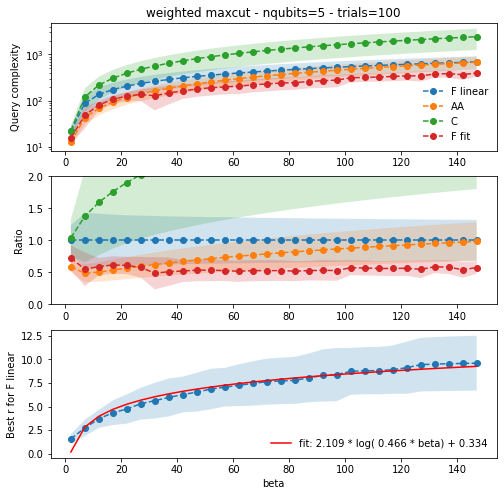

In [129]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,8))
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')
plot_band(axs[0], beta_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F fit')

axs[0].set_yscale('log')
axs[0].legend(frameon=False);
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), label='F fit')

axs[1].set_ylim([0,2])
axs[2].set_xlabel('beta')
axs[1].set_ylabel('Ratio');

axs[2].set_ylabel('Best r for F linear')
plot_band(axs[2], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1))

def func(x, a, b, c):
    return a * np.log(np.abs(b) * x) + c

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[2].plot(beta_range, func(beta_range, *popt), 'r-',
        label='fit: %5.3f * log( %5.3f * beta) + %5.3f' % tuple(popt))
axs[2].legend(loc='lower right', frameon=False)

<ipython-input-115-8a998b648576>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-115-8a998b648576>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-115-8a998b648576>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-115-8a998b648576>:4: Runt

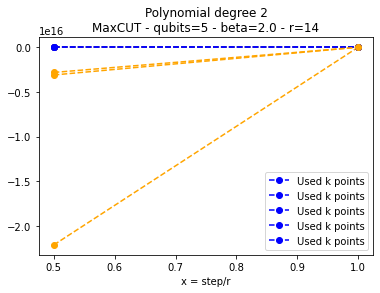

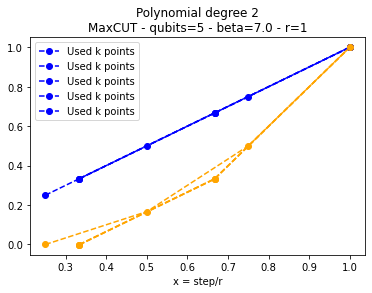

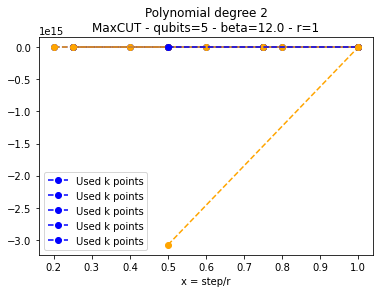

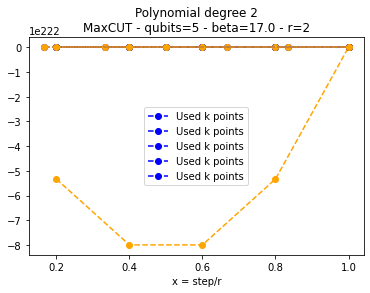

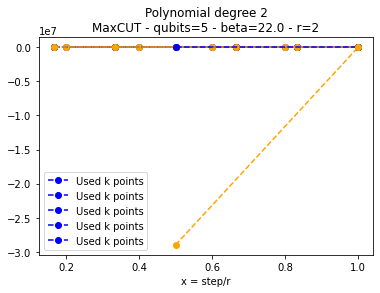

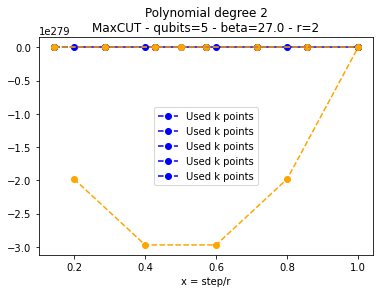

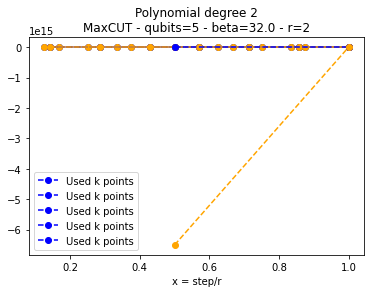

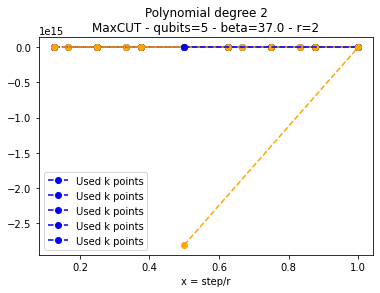

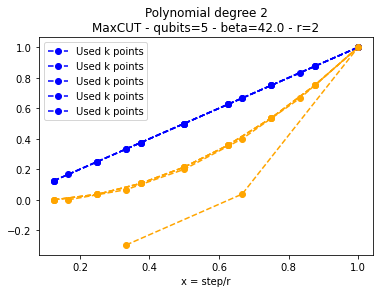

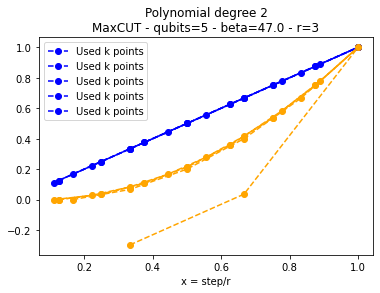

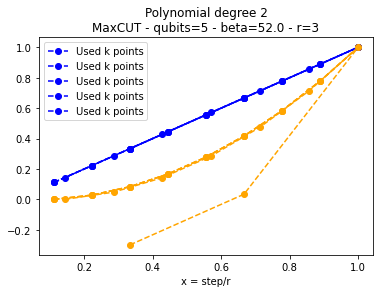

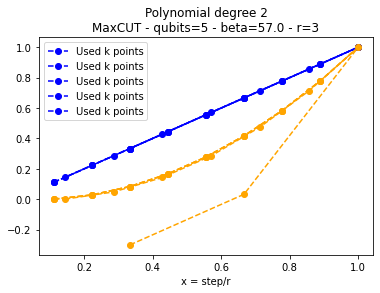

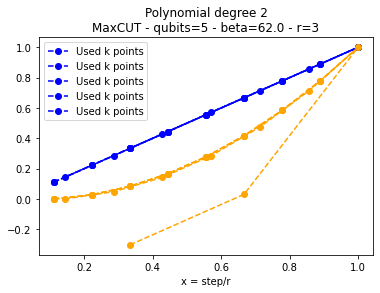

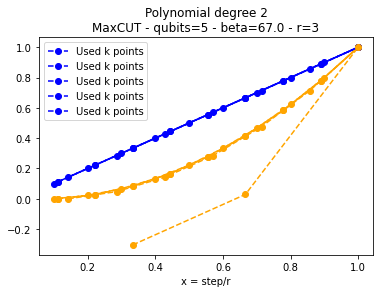

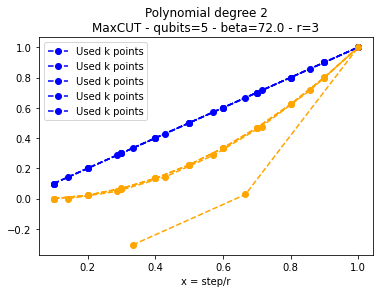

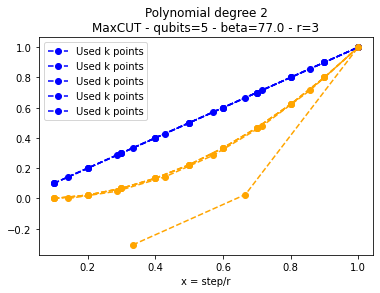

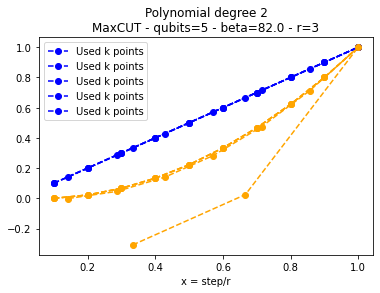

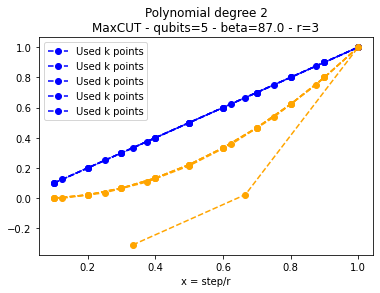

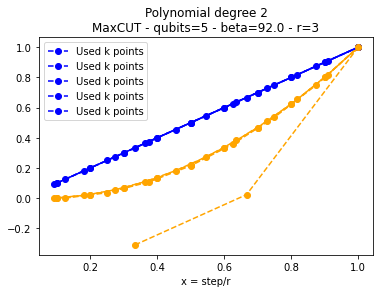

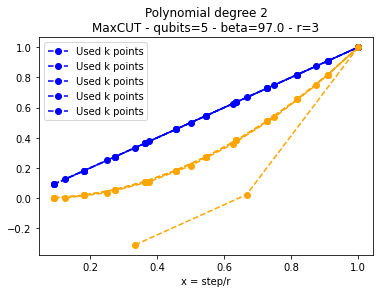

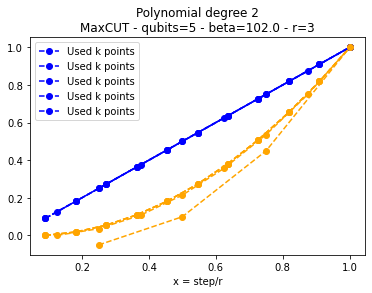

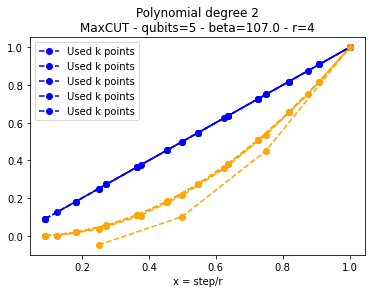

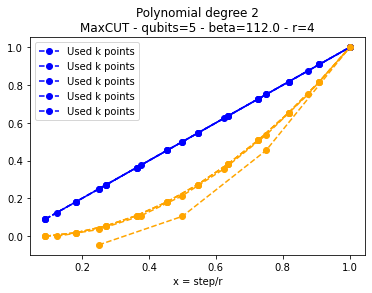

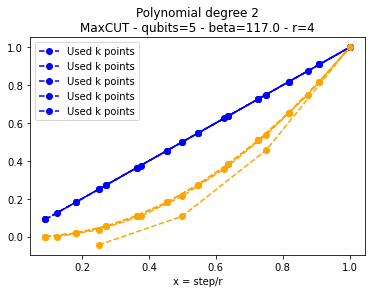

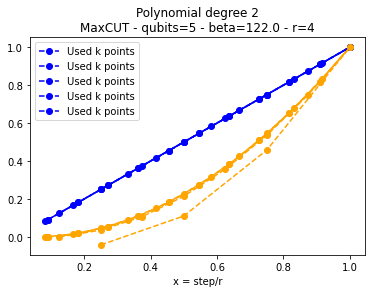

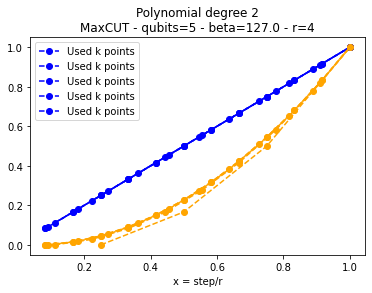

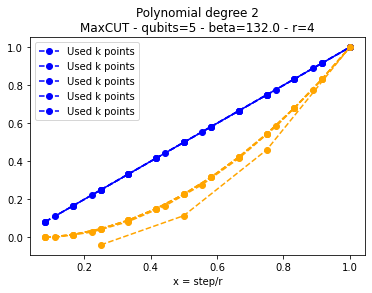

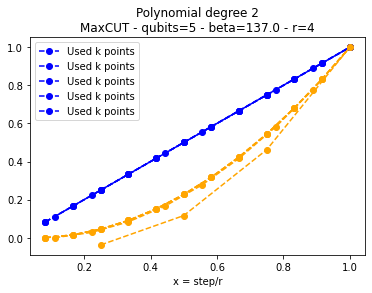

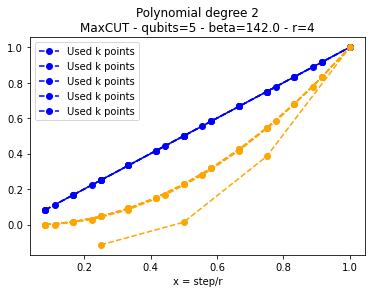

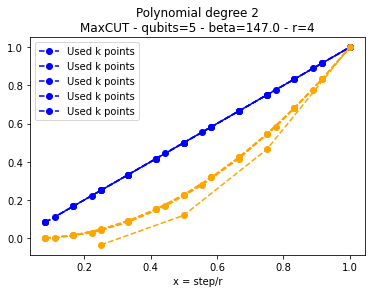

In [115]:
# plot
x = np.linspace(0,1,50)
for ii, beta in enumerate(beta_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    #plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        #plt.plot(x, [myschedule(i, parameters[ii][jj]) for i in x], color='orange');
        plt.plot(xr, xr, 'o--', color='blue', label='Used k points')        
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o--', color='orange')
    plt.xlabel('x = step/r')
    plt.legend();